In [2]:
import geopandas as gpd
from tqdm import tqdm
from shapely.validation import explain_validity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
from itertools import cycle

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
os.chdir("../scripts")
from clustering_operations import *
from HierarchicalClusteringOptimized import HierarchicalClustering

%load_ext autoreload
%autoreload 2

In [4]:
level = 6
shapefile_coarser = gpd.read_file(f'../data/shapefiles/FAPAN_level_0{level}/comparison_4na.shp')

In [5]:
shp = gpd.read_file('../data/shapefiles/FAPAN_domain_fixed_geometry/FAPAN_domain_fixed_geometry_availability05_final.shp')

#### Consider only the original sub-basins which fully compose a sub-basin in level X

In [6]:
df_coarser = pd.read_csv(f'../data/FAPAN_level_0{level}_corrected.csv', sep=',')
df = pd.read_csv("../data/FAPAN204_05.csv", sep=',')

In [7]:
subid_coarser = list(shapefile_coarser["SUBID"])

In [8]:
df_coarser_4na = df_coarser[df_coarser["HYBAS_ID"].isin(subid_coarser)]

In [9]:
valid_subids = set()
for index, row in df_coarser_4na.iterrows():
    subids = row["SUBIDs"].split("_")
    for subid in subids:
        valid_subids.add(subid)
        
print(len(valid_subids))
valid_subids = list(map(str, valid_subids))

23841


In [10]:
df['SUBID'] = df['SUBID'].astype(int).astype(str)
shp['SUBID'] = shp['SUBID'].astype(int).astype(str)
df = df[df["SUBID"].isin(valid_subids)].reset_index(drop=True)
shp = shp[shp["SUBID"].isin(valid_subids)].reset_index(drop=True)
print(df.shape)
print(shp.shape)

(23841, 207)
(23841, 22)


<AxesSubplot:>

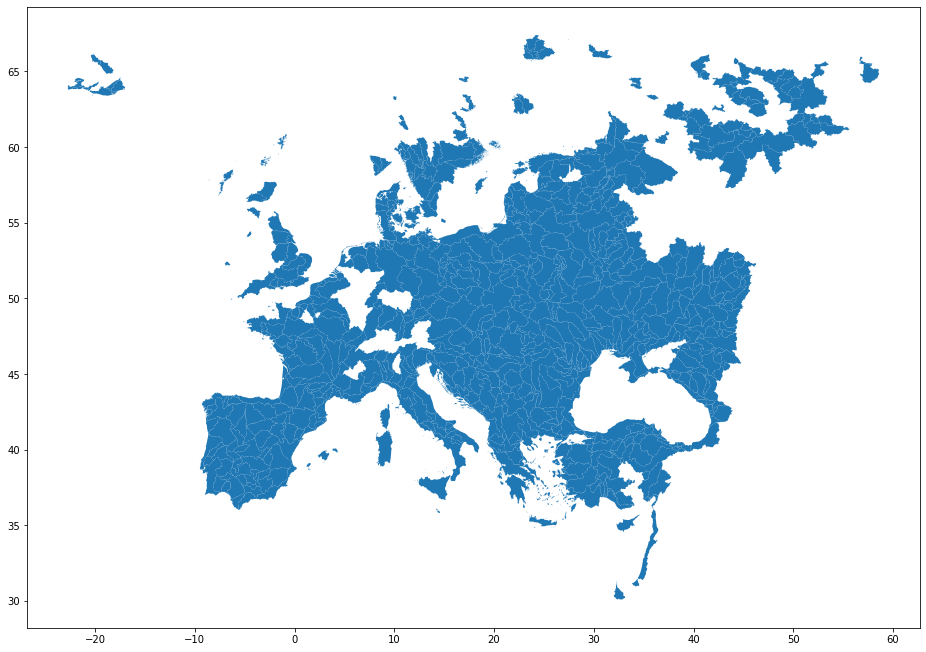

In [11]:
shapefile_coarser.plot(figsize=(16,16))

<AxesSubplot:>

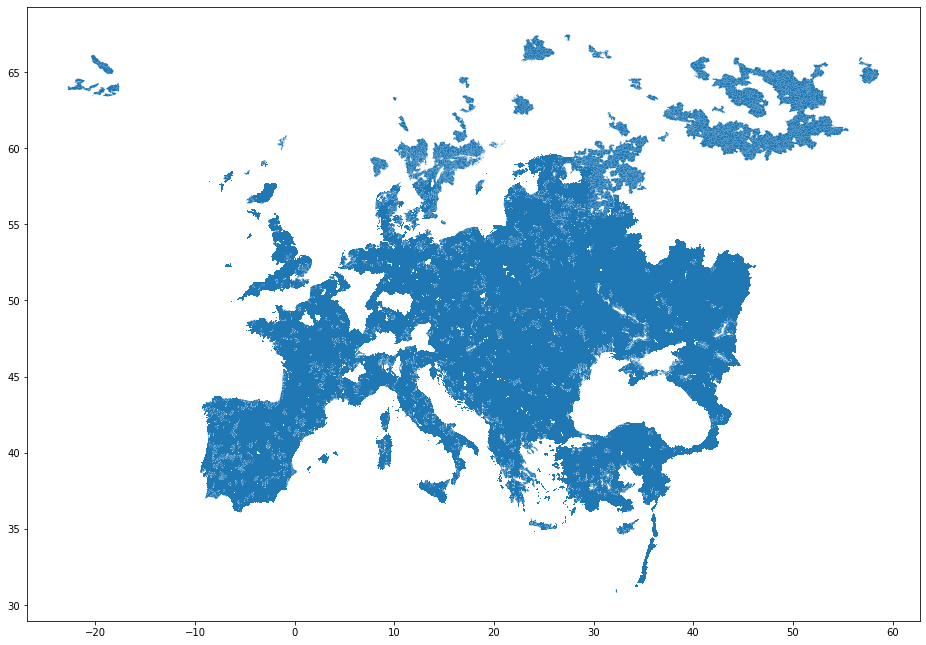

In [12]:
shp.plot(figsize=(16,16))

In [13]:
def select_columns_by_months(dataframe, selected_months):
    selected_columns = []

    for i in range((dataframe.shape[1] - 3) // 12):
        selected_columns.extend([month + i * 12 for month in selected_months])

    all_columns = np.arange(1, dataframe.shape[1]-2)
    columns_to_drop = np.setdiff1d(all_columns, np.array(selected_columns))
    columns_to_drop = [str(i) for i in columns_to_drop]

    filtered_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return filtered_dataframe

In [14]:
df = select_columns_by_months(df, [4,5,6,7,8,9])
df.shape

(23841, 105)

In [15]:
df.head()

,SUBID,x,y,4,5,6,7,8,9,16,...,186,187,188,189,196,197,198,199,200,201
0,8115258,8.7466,59.1359,-0.245083,0.815444,-0.115556,-0.607519,1.011852,0.708333,-0.594933,...,0.314370,0.490519,-0.576593,-2.895556,-1.772971,1.125889,0.715222,1.261407,-0.258074,-0.028667
1,8115717,9.2398,58.9271,0.242000,-0.082444,-1.187556,-0.751778,0.860667,1.069778,-0.592444,...,0.406667,0.541444,0.268444,-1.212222,-0.675084,1.587889,1.250889,1.530667,-0.349889,0.421222
2,8102609,9.1371,58.9647,0.371667,0.523533,-0.586733,-0.437733,0.851200,1.108467,-1.133250,...,0.870133,0.855667,0.562333,-2.557400,NaN,1.233200,1.278556,1.541600,-0.056200,-0.116467
3,8103951,9.0461,59.1257,0.090185,0.343000,-0.465481,-0.418556,0.877259,1.107815,-0.699926,...,0.779556,0.867926,0.726259,-2.251519,NaN,1.317556,0.857733,1.314333,0.112074,-0.040444
4,8000018,34.3101,64.3213,-0.557667,0.219333,0.504778,0.273444,0.653556,0.775667,-0.636969,...,-2.026444,-1.091778,-0.633778,-1.165778,-0.455889,0.393000,0.148444,0.615000,0.953444,0.537556


## Compute neighbours

In [16]:
# add neighbours column
shp["NEIGHBOURS"] = None  
    
progress_bar = tqdm(total=shp.shape[0], position=0, leave=True, smoothing=0)

for index, country in shp.iterrows():   
    #print(index)
    # get 'not disjoint' countries
    neighbours = shp[~shp.geometry.disjoint(country.geometry)]['SUBID'].tolist()

    # remove own name of the country from the list
    neighbours = [ name for name in neighbours if country['SUBID'] != name ]

    # add names of neighbours as neighbours value
    shp.at[index, "NEIGHBOURS"] = neighbours
                   
    progress_bar.update(1)  

100%|█████████▉| 23839/23841 [03:56<00:00, 100.91it/s]

In [17]:
# Create a set to store unique pairs
neighbours_pairs = set()

# Iterate over each row and generate pairs
for index, row in shp.iterrows():
    subid = row['SUBID']
    neighbors = row['NEIGHBOURS']
    
    # Generate pairs and add to the set
    for neighbor in neighbors:
        pair = tuple(sorted([subid, neighbor]))
        neighbours_pairs.add(pair)

df_without_neighbours = shp[shp["NEIGHBOURS"].apply(len)==0][["SUBID"]]
without_neighbours = df_without_neighbours["SUBID"].to_list()      

## Compute and visualize clusterings

In [18]:
# Transpose the DataFrame and set the "SUBID" column as the column names
df = df.set_index('SUBID').T
df = df.reset_index(drop=True)
df = df.rename_axis(None, axis=1)
df = df.astype(float)
df.head()

,8115258,8115717,8102609,8103951,8000018,8200275,8200309,8208362,8208864,8211662,...,9568337,9528282,9566462,9566535,9566624,9566991,9566510,9566395,9524166,9723401
0,8.746600,9.239800,9.137100,9.046100,34.310100,33.933900,35.917500,34.253500,33.992100,34.561500,...,0.000000,0.066700,0.358300,0.429200,0.275000,0.220800,0.164200,0.115800,-1.0625,29.1942
1,59.135900,58.927100,58.964700,59.125700,64.321300,64.350300,63.216100,64.487000,64.479700,64.231500,...,50.962500,50.841700,48.991700,49.212500,48.954200,49.125000,49.187500,49.317500,45.5008,36.6958
2,-0.245083,0.242000,0.371667,0.090185,-0.557667,-0.700250,-0.391667,-0.663958,-0.910333,-0.602111,...,0.366222,0.572667,0.831286,0.821733,0.943467,0.689667,0.638083,0.870333,-0.6570,-0.2001
3,0.815444,-0.082444,0.523533,0.343000,0.219333,0.159267,0.381967,0.046533,-0.169467,0.248333,...,-0.329778,-0.141333,-0.766611,-0.540400,-0.744600,-1.734000,-1.239000,-0.808333,0.1570,0.3108
4,-0.115556,-1.187556,-0.586733,-0.465481,0.504778,0.754933,-0.014767,0.592233,0.730467,0.556389,...,-0.312370,-0.484778,-1.160905,-0.826400,-0.524267,-1.406667,-1.086250,-0.600833,-0.9115,-0.2891


# Clustering

In [19]:
clustering = HierarchicalClustering(df, neighbours_pairs, without_neighbours, method='complete_correlation', threshold=0.4, missing_values=True)
clustering.compute_clusters()

Computing neighbours strengths...


100%|██████████| 66512/66512 [08:30<00:00, 130.20it/s]


Neighbours strengths computed.
Computing clusters...


  0%|          | 2/23841 [00:00<1:13:12,  5.43it/s]

B
B


  0%|          | 3/23841 [00:00<1:04:33,  6.15it/s]

B


  0%|          | 5/23841 [00:00<1:09:05,  5.75it/s]

B
B


  0%|          | 7/23841 [00:01<1:05:07,  6.10it/s]

B
B


  0%|          | 9/23841 [00:01<1:01:43,  6.44it/s]

B
B


  0%|          | 11/23841 [00:01<58:10,  6.83it/s] 

B
B


  0%|          | 13/23841 [00:01<56:58,  6.97it/s]

B
B


  0%|          | 15/23841 [00:02<55:42,  7.13it/s]

B
B


  0%|          | 17/23841 [00:02<58:12,  6.82it/s]

B
B


  0%|          | 19/23841 [00:02<57:01,  6.96it/s]

B
B


  0%|          | 21/23841 [00:03<57:11,  6.94it/s]

B
B


  0%|          | 23/23841 [00:03<57:28,  6.91it/s]

B
B


  0%|          | 25/23841 [00:03<56:59,  6.97it/s]

B
B


  0%|          | 26/23841 [00:03<57:03,  6.96it/s]

B


  0%|          | 28/23841 [00:04<59:52,  6.63it/s]

B
B


  0%|          | 30/23841 [00:04<59:20,  6.69it/s]

B
B


  0%|          | 32/23841 [00:04<59:18,  6.69it/s]

B
B


  0%|          | 34/23841 [00:05<58:56,  6.73it/s]

B
B


  0%|          | 36/23841 [00:05<58:49,  6.74it/s]

B
B


  0%|          | 37/23841 [00:05<58:10,  6.82it/s]

B


  0%|          | 39/23841 [00:05<1:01:25,  6.46it/s]

B
B


  0%|          | 41/23841 [00:06<1:01:02,  6.50it/s]

B
B


  0%|          | 43/23841 [00:06<1:00:38,  6.54it/s]

B
B


  0%|          | 45/23841 [00:06<1:00:24,  6.57it/s]

B
B


  0%|          | 47/23841 [00:07<59:19,  6.68it/s]  

B
B


  0%|          | 49/23841 [00:07<59:25,  6.67it/s]

B
B


  0%|          | 51/23841 [00:07<59:33,  6.66it/s]  

B
B


  0%|          | 53/23841 [00:07<59:12,  6.70it/s]

B
B


  0%|          | 54/23841 [00:08<58:36,  6.76it/s]

B


  0%|          | 56/23841 [00:08<1:01:02,  6.49it/s]

B
B


  0%|          | 58/23841 [00:08<1:00:10,  6.59it/s]

B
B


  0%|          | 60/23841 [00:09<59:26,  6.67it/s]  

B
B


  0%|          | 62/23841 [00:09<59:24,  6.67it/s]

B
B


  0%|          | 64/23841 [00:09<58:29,  6.78it/s]

B
B


  0%|          | 66/23841 [00:09<59:03,  6.71it/s]

B
B


  0%|          | 68/23841 [00:10<58:47,  6.74it/s]

B
B
B


  0%|          | 71/23841 [00:10<57:46,  6.86it/s]

B
B


  0%|          | 72/23841 [00:10<57:20,  6.91it/s]

B


  0%|          | 74/23841 [00:11<58:21,  6.79it/s]

B
B


  0%|          | 76/23841 [00:11<58:14,  6.80it/s]

B
B
B


  0%|          | 79/23841 [00:11<57:38,  6.87it/s]

B
B


  0%|          | 81/23841 [00:12<58:15,  6.80it/s]

B
B


  0%|          | 83/23841 [00:12<56:48,  6.97it/s]

B
B


  0%|          | 85/23841 [00:12<57:17,  6.91it/s]

B
B


  0%|          | 87/23841 [00:12<57:24,  6.90it/s]

B
B


  0%|          | 89/23841 [00:13<57:11,  6.92it/s]

B
B


  0%|          | 91/23841 [00:13<56:54,  6.96it/s]

B
B


  0%|          | 93/23841 [00:13<57:46,  6.85it/s]

B
B


  0%|          | 95/23841 [00:14<57:30,  6.88it/s]

B
B


  0%|          | 97/23841 [00:14<58:01,  6.82it/s]

B
B


  0%|          | 99/23841 [00:14<58:53,  6.72it/s]

B
B


  0%|          | 101/23841 [00:15<59:28,  6.65it/s]

B
B


  0%|          | 103/23841 [00:15<58:44,  6.73it/s]

B
B


  0%|          | 105/23841 [00:15<58:26,  6.77it/s]

B
B


  0%|          | 107/23841 [00:15<58:57,  6.71it/s]

B
B


  0%|          | 109/23841 [00:16<58:25,  6.77it/s]

B
B


  0%|          | 110/23841 [00:16<57:55,  6.83it/s]

B


  0%|          | 112/23841 [00:16<1:00:10,  6.57it/s]

B
B


  0%|          | 114/23841 [00:17<1:00:52,  6.50it/s]

B
B


  0%|          | 116/23841 [00:17<1:01:08,  6.47it/s]

B
B


  0%|          | 118/23841 [00:17<1:01:25,  6.44it/s]

B
B


  1%|          | 120/23841 [00:18<1:01:27,  6.43it/s]

B
B


  1%|          | 122/23841 [00:18<1:01:07,  6.47it/s]

B
B


  1%|          | 124/23841 [00:18<1:00:47,  6.50it/s]

B
B


  1%|          | 126/23841 [00:18<1:01:22,  6.44it/s]

B
B


  1%|          | 128/23841 [00:19<1:02:38,  6.31it/s]

B
B


  1%|          | 130/23841 [00:19<1:01:57,  6.38it/s]

B
B


  1%|          | 132/23841 [00:19<1:01:10,  6.46it/s]

B
B


  1%|          | 134/23841 [00:20<1:00:56,  6.48it/s]

B
B


  1%|          | 136/23841 [00:20<1:00:02,  6.58it/s]

B
B


  1%|          | 138/23841 [00:20<59:52,  6.60it/s]  

B
B


  1%|          | 140/23841 [00:20<59:02,  6.69it/s]

B
B


  1%|          | 142/23841 [00:21<58:59,  6.70it/s]

B
B


  1%|          | 143/23841 [00:21<58:12,  6.79it/s]

B


  1%|          | 145/23841 [00:21<1:01:19,  6.44it/s]

B
B


  1%|          | 147/23841 [00:22<1:01:06,  6.46it/s]

B
B


  1%|          | 149/23841 [00:22<1:01:15,  6.45it/s]

B
B


  1%|          | 151/23841 [00:22<1:01:01,  6.47it/s]

B
B


  1%|          | 153/23841 [00:23<1:01:35,  6.41it/s]

B
B


  1%|          | 155/23841 [00:23<1:00:48,  6.49it/s]

B
B


  1%|          | 157/23841 [00:23<1:00:47,  6.49it/s]

B
B


  1%|          | 159/23841 [00:23<1:00:47,  6.49it/s]

B
B


  1%|          | 160/23841 [00:24<1:00:49,  6.49it/s]

B


  1%|          | 162/23841 [00:24<1:02:37,  6.30it/s]

B
B


  1%|          | 164/23841 [00:24<1:03:04,  6.26it/s]

B
B


  1%|          | 166/23841 [00:25<1:03:50,  6.18it/s]

B
B


  1%|          | 168/23841 [00:25<1:02:37,  6.30it/s]

B
B


  1%|          | 170/23841 [00:25<1:01:49,  6.38it/s]

B
B


  1%|          | 172/23841 [00:26<1:02:00,  6.36it/s]

B
B


  1%|          | 174/23841 [00:26<1:02:00,  6.36it/s]

B
B


  1%|          | 175/23841 [00:26<1:02:05,  6.35it/s]

B


  1%|          | 177/23841 [00:27<1:04:08,  6.15it/s]

B
B


  1%|          | 179/23841 [00:27<1:02:50,  6.27it/s]

B
B


  1%|          | 181/23841 [00:27<1:03:31,  6.21it/s]

B
B


  1%|          | 183/23841 [00:27<1:03:46,  6.18it/s]

B
B


  1%|          | 185/23841 [00:28<1:03:09,  6.24it/s]

B
B


  1%|          | 187/23841 [00:28<1:03:17,  6.23it/s]

B
B


  1%|          | 189/23841 [00:28<1:02:52,  6.27it/s]

B
B


  1%|          | 191/23841 [00:29<1:03:55,  6.17it/s]

B
B


  1%|          | 192/23841 [00:29<1:04:29,  6.11it/s]

B


  1%|          | 194/23841 [00:29<1:05:19,  6.03it/s]

B
B


  1%|          | 196/23841 [00:30<1:04:45,  6.09it/s]

B
B


  1%|          | 198/23841 [00:30<1:04:22,  6.12it/s]

B
B


  1%|          | 200/23841 [00:30<1:04:23,  6.12it/s]

B
B


  1%|          | 202/23841 [00:31<1:03:05,  6.24it/s]

B
B


  1%|          | 204/23841 [00:31<1:03:33,  6.20it/s]

B
B


  1%|          | 206/23841 [00:31<1:02:38,  6.29it/s]

B
B


  1%|          | 208/23841 [00:32<1:05:37,  6.00it/s]

B
B


  1%|          | 210/23841 [00:32<1:04:46,  6.08it/s]

B
B


  1%|          | 212/23841 [00:32<1:05:11,  6.04it/s]

B
B


  1%|          | 214/23841 [00:33<1:05:33,  6.01it/s]

B
B


  1%|          | 216/23841 [00:33<1:04:07,  6.14it/s]

B
B


  1%|          | 218/23841 [00:33<1:04:01,  6.15it/s]

B
B


  1%|          | 220/23841 [00:33<1:03:57,  6.16it/s]

B
B


  1%|          | 221/23841 [00:34<1:03:55,  6.16it/s]

B


  1%|          | 223/23841 [00:34<1:05:52,  5.98it/s]

B
B


  1%|          | 225/23841 [00:34<1:05:13,  6.03it/s]

B
B


  1%|          | 227/23841 [00:35<1:04:22,  6.11it/s]

B
B


  1%|          | 228/23841 [00:35<1:03:14,  6.22it/s]

B


  1%|          | 230/23841 [00:35<1:05:11,  6.04it/s]

B
B


  1%|          | 232/23841 [00:36<1:04:59,  6.05it/s]

B
B


  1%|          | 234/23841 [00:36<1:05:07,  6.04it/s]

B
B


  1%|          | 235/23841 [00:36<1:04:50,  6.07it/s]

B


  1%|          | 237/23841 [00:36<1:07:09,  5.86it/s]

B
B


  1%|          | 239/23841 [00:37<1:06:54,  5.88it/s]

B
B


  1%|          | 241/23841 [00:37<1:06:17,  5.93it/s]

B
B


  1%|          | 243/23841 [00:37<1:05:53,  5.97it/s]

B
B


  1%|          | 245/23841 [00:38<1:05:18,  6.02it/s]

B
B


  1%|          | 247/23841 [00:38<1:05:36,  5.99it/s]

B
B


  1%|          | 249/23841 [00:38<1:05:45,  5.98it/s]

B
B


  1%|          | 251/23841 [00:39<1:05:31,  6.00it/s]

B
B


  1%|          | 252/23841 [00:39<1:05:18,  6.02it/s]

B


  1%|          | 254/23841 [00:39<1:05:33,  6.00it/s]

B
B


  1%|          | 256/23841 [00:40<1:05:05,  6.04it/s]

B
B


  1%|          | 258/23841 [00:40<1:05:13,  6.03it/s]

B
B


  1%|          | 260/23841 [00:40<1:04:58,  6.05it/s]

B
B


  1%|          | 262/23841 [00:40<1:03:50,  6.15it/s]

B
B


  1%|          | 264/23841 [00:41<1:03:53,  6.15it/s]

B
B


  1%|          | 265/23841 [00:41<1:03:24,  6.20it/s]

B


  1%|          | 267/23841 [00:41<1:05:11,  6.03it/s]

B
B


  1%|          | 269/23841 [00:42<1:04:45,  6.07it/s]

B
B


  1%|          | 271/23841 [00:42<1:04:40,  6.07it/s]

B
B


  1%|          | 273/23841 [00:42<1:04:54,  6.05it/s]

B
B


  1%|          | 275/23841 [00:43<1:05:27,  6.00it/s]

B
B


  1%|          | 277/23841 [00:43<1:04:20,  6.10it/s]

B
B


  1%|          | 279/23841 [00:43<1:03:34,  6.18it/s]

B
B


  1%|          | 281/23841 [00:44<1:06:34,  5.90it/s]

B
B


  1%|          | 283/23841 [00:44<1:05:53,  5.96it/s]

B
B


  1%|          | 285/23841 [00:44<1:05:14,  6.02it/s]

B
B


  1%|          | 287/23841 [00:45<1:05:38,  5.98it/s]

B
B


  1%|          | 289/23841 [00:45<1:05:04,  6.03it/s]

B
B


  1%|          | 291/23841 [00:45<1:04:23,  6.10it/s]

B
B


  1%|          | 293/23841 [00:46<1:04:21,  6.10it/s]

B
B


  1%|          | 294/23841 [00:46<1:04:40,  6.07it/s]

B


  1%|          | 296/23841 [00:46<1:06:44,  5.88it/s]

B
B


  1%|          | 298/23841 [00:47<1:06:31,  5.90it/s]

B
B


  1%|▏         | 300/23841 [00:47<1:06:51,  5.87it/s]

B
B


  1%|▏         | 302/23841 [00:47<1:05:33,  5.98it/s]

B
B


  1%|▏         | 304/23841 [00:48<1:06:32,  5.90it/s]

B
B


  1%|▏         | 306/23841 [00:48<1:07:02,  5.85it/s]

B
B


  1%|▏         | 308/23841 [00:48<1:06:23,  5.91it/s]

B
B


  1%|▏         | 310/23841 [00:49<1:06:39,  5.88it/s]

B
B


  1%|▏         | 311/23841 [00:49<1:07:28,  5.81it/s]

B


  1%|▏         | 313/23841 [00:49<1:08:40,  5.71it/s]

B
B


  1%|▏         | 315/23841 [00:50<1:08:17,  5.74it/s]

B
B


  1%|▏         | 317/23841 [00:50<1:11:00,  5.52it/s]

B
B


  1%|▏         | 319/23841 [00:50<1:10:13,  5.58it/s]

B
B


  1%|▏         | 321/23841 [00:51<1:09:57,  5.60it/s]

B
B


  1%|▏         | 323/23841 [00:51<1:09:16,  5.66it/s]

B
B


  1%|▏         | 325/23841 [00:52<1:10:54,  5.53it/s]

B
B


  1%|▏         | 327/23841 [00:52<1:09:39,  5.63it/s]

B
B


  1%|▏         | 329/23841 [00:52<1:09:21,  5.65it/s]

B
B


  1%|▏         | 331/23841 [00:52<1:08:42,  5.70it/s]

B
B


  1%|▏         | 333/23841 [00:53<1:07:20,  5.82it/s]

B
B


  1%|▏         | 335/23841 [00:53<1:07:29,  5.81it/s]

B
B


  1%|▏         | 336/23841 [00:53<1:07:09,  5.83it/s]

B


  1%|▏         | 337/23841 [00:53<1:08:00,  5.76it/s]

B


  1%|▏         | 339/23841 [00:54<1:10:14,  5.58it/s]

B
B


  1%|▏         | 341/23841 [00:54<1:09:18,  5.65it/s]

B
B


  1%|▏         | 343/23841 [00:55<1:09:16,  5.65it/s]

B
B


  1%|▏         | 345/23841 [00:55<1:09:11,  5.66it/s]

B
B


  1%|▏         | 347/23841 [00:55<1:09:00,  5.67it/s]

B
B


  1%|▏         | 349/23841 [00:56<1:07:24,  5.81it/s]

B
B


  1%|▏         | 351/23841 [00:56<1:06:55,  5.85it/s]

B
B


  1%|▏         | 352/23841 [00:56<1:05:51,  5.94it/s]

B


  1%|▏         | 353/23841 [00:56<1:08:07,  5.75it/s]

B


  1%|▏         | 355/23841 [00:57<1:09:48,  5.61it/s]

B
B


  1%|▏         | 357/23841 [00:57<1:08:42,  5.70it/s]

B
B


  2%|▏         | 359/23841 [00:57<1:07:59,  5.76it/s]

B
B


  2%|▏         | 360/23841 [00:58<1:08:01,  5.75it/s]

B


  2%|▏         | 362/23841 [00:58<1:10:56,  5.52it/s]

B
B


  2%|▏         | 364/23841 [00:58<1:10:55,  5.52it/s]

B
B


  2%|▏         | 366/23841 [00:59<1:11:08,  5.50it/s]

B
B


  2%|▏         | 368/23841 [00:59<1:10:21,  5.56it/s]

B
B


  2%|▏         | 370/23841 [00:59<1:09:30,  5.63it/s]

B
B


  2%|▏         | 372/23841 [01:00<1:10:21,  5.56it/s]

B
B


  2%|▏         | 374/23841 [01:00<1:09:16,  5.65it/s]

B
B


  2%|▏         | 376/23841 [01:00<1:09:53,  5.60it/s]

B
B


  2%|▏         | 378/23841 [01:01<1:09:47,  5.60it/s]

B
B


  2%|▏         | 379/23841 [01:01<1:09:38,  5.61it/s]

B


  2%|▏         | 380/23841 [01:01<1:10:54,  5.51it/s]

B


  2%|▏         | 382/23841 [01:02<1:12:11,  5.42it/s]

B
B


  2%|▏         | 384/23841 [01:02<1:11:59,  5.43it/s]

B
B


  2%|▏         | 386/23841 [01:02<1:11:19,  5.48it/s]

B
B


  2%|▏         | 388/23841 [01:03<1:09:41,  5.61it/s]

B
B


  2%|▏         | 390/23841 [01:03<1:08:47,  5.68it/s]

B
B


  2%|▏         | 392/23841 [01:03<1:08:19,  5.72it/s]

B
B


  2%|▏         | 394/23841 [01:04<1:08:48,  5.68it/s]

B
B


  2%|▏         | 396/23841 [01:04<1:10:26,  5.55it/s]

B
B


  2%|▏         | 398/23841 [01:04<1:08:58,  5.66it/s]

B
B


  2%|▏         | 400/23841 [01:05<1:08:19,  5.72it/s]

B
B


  2%|▏         | 402/23841 [01:05<1:07:51,  5.76it/s]

B
B


  2%|▏         | 404/23841 [01:05<1:07:07,  5.82it/s]

B
B


  2%|▏         | 406/23841 [01:06<1:06:41,  5.86it/s]

B
B


  2%|▏         | 408/23841 [01:06<1:06:45,  5.85it/s]

B
B


  2%|▏         | 410/23841 [01:06<1:07:42,  5.77it/s]

B
B


  2%|▏         | 412/23841 [01:07<1:06:44,  5.85it/s]

B
B


  2%|▏         | 414/23841 [01:07<1:06:15,  5.89it/s]

B
B


  2%|▏         | 415/23841 [01:07<1:06:03,  5.91it/s]

B


  2%|▏         | 417/23841 [01:08<1:06:11,  5.90it/s]

B
B
B


  2%|▏         | 420/23841 [01:08<1:07:42,  5.76it/s]

B
B


  2%|▏         | 422/23841 [01:08<1:07:34,  5.78it/s]

B
B


  2%|▏         | 424/23841 [01:09<1:09:10,  5.64it/s]

B
B


  2%|▏         | 426/23841 [01:09<1:08:46,  5.67it/s]

B
B


  2%|▏         | 428/23841 [01:10<1:08:32,  5.69it/s]

B
B


  2%|▏         | 430/23841 [01:10<1:07:26,  5.78it/s]

B
B


  2%|▏         | 432/23841 [01:10<1:07:37,  5.77it/s]

B
B


  2%|▏         | 434/23841 [01:11<1:07:42,  5.76it/s]

B
B


  2%|▏         | 436/23841 [01:11<1:06:58,  5.82it/s]

B
B


  2%|▏         | 438/23841 [01:11<1:06:32,  5.86it/s]

B
B


  2%|▏         | 439/23841 [01:11<1:05:19,  5.97it/s]

B


  2%|▏         | 441/23841 [01:12<1:06:47,  5.84it/s]

B
B


  2%|▏         | 443/23841 [01:12<1:07:03,  5.82it/s]

B
B


  2%|▏         | 445/23841 [01:12<1:06:33,  5.86it/s]

B
B


  2%|▏         | 447/23841 [01:13<1:05:39,  5.94it/s]

B
B


  2%|▏         | 449/23841 [01:13<1:04:52,  6.01it/s]

B
B
B


  2%|▏         | 451/23841 [01:13<1:05:18,  5.97it/s]

B


  2%|▏         | 453/23841 [01:14<1:06:49,  5.83it/s]

B
B


  2%|▏         | 454/23841 [01:14<1:06:56,  5.82it/s]

B


  2%|▏         | 456/23841 [01:14<1:07:41,  5.76it/s]

B
B


  2%|▏         | 458/23841 [01:15<1:06:58,  5.82it/s]

B
B


  2%|▏         | 460/23841 [01:15<1:06:32,  5.86it/s]

B
B


  2%|▏         | 462/23841 [01:15<1:07:34,  5.77it/s]

B
B


  2%|▏         | 464/23841 [01:16<1:06:50,  5.83it/s]

B
B


  2%|▏         | 466/23841 [01:16<1:08:51,  5.66it/s]

B
B


  2%|▏         | 468/23841 [01:16<1:07:36,  5.76it/s]

B
B


  2%|▏         | 470/23841 [01:17<1:06:49,  5.83it/s]

B
B


  2%|▏         | 472/23841 [01:17<1:06:51,  5.83it/s]

B
B


  2%|▏         | 474/23841 [01:17<1:06:06,  5.89it/s]

B
B


  2%|▏         | 476/23841 [01:18<1:05:25,  5.95it/s]

B
B


  2%|▏         | 478/23841 [01:18<1:05:25,  5.95it/s]

B
B


  2%|▏         | 479/23841 [01:18<1:07:20,  5.78it/s]

B


  2%|▏         | 481/23841 [01:19<1:08:25,  5.69it/s]

B
B


  2%|▏         | 483/23841 [01:19<1:07:38,  5.76it/s]

B
B


  2%|▏         | 485/23841 [01:19<1:07:32,  5.76it/s]

B
B


  2%|▏         | 487/23841 [01:20<1:07:36,  5.76it/s]

B
B


  2%|▏         | 489/23841 [01:20<1:06:10,  5.88it/s]

B
B


  2%|▏         | 491/23841 [01:20<1:05:53,  5.91it/s]

B
B


  2%|▏         | 493/23841 [01:21<1:05:35,  5.93it/s]

B
B


  2%|▏         | 495/23841 [01:21<1:05:42,  5.92it/s]

B
B


  2%|▏         | 497/23841 [01:21<1:05:21,  5.95it/s]

B
B


  2%|▏         | 498/23841 [01:21<1:06:16,  5.87it/s]

B


  2%|▏         | 500/23841 [01:22<1:08:05,  5.71it/s]

B
B


  2%|▏         | 502/23841 [01:22<1:07:02,  5.80it/s]

B
B


  2%|▏         | 504/23841 [01:23<1:08:25,  5.68it/s]

B
B


  2%|▏         | 506/23841 [01:23<1:07:19,  5.78it/s]

B
B


  2%|▏         | 508/23841 [01:23<1:07:05,  5.80it/s]

B
B


  2%|▏         | 510/23841 [01:23<1:05:10,  5.97it/s]

B
B


  2%|▏         | 512/23841 [01:24<1:04:46,  6.00it/s]

B
B


  2%|▏         | 514/23841 [01:24<1:04:38,  6.01it/s]

B
B


  2%|▏         | 515/23841 [01:24<1:03:59,  6.07it/s]

B


  2%|▏         | 517/23841 [01:25<1:05:53,  5.90it/s]

B
B


  2%|▏         | 519/23841 [01:25<1:05:28,  5.94it/s]

B
B


  2%|▏         | 521/23841 [01:25<1:05:59,  5.89it/s]

B
B


  2%|▏         | 523/23841 [01:26<1:05:35,  5.93it/s]

B
B


  2%|▏         | 525/23841 [01:26<1:05:09,  5.96it/s]

B
B


  2%|▏         | 527/23841 [01:26<1:05:06,  5.97it/s]

B
B


  2%|▏         | 529/23841 [01:27<1:04:33,  6.02it/s]

B
B


  2%|▏         | 531/23841 [01:27<1:04:55,  5.98it/s]

B
B


  2%|▏         | 532/23841 [01:27<1:04:48,  5.99it/s]

B


  2%|▏         | 533/23841 [01:27<1:06:41,  5.83it/s]

B


  2%|▏         | 534/23841 [01:28<1:08:31,  5.67it/s]

B


  2%|▏         | 536/23841 [01:28<1:10:26,  5.51it/s]

B
B


  2%|▏         | 538/23841 [01:28<1:08:12,  5.69it/s]

B
B


  2%|▏         | 540/23841 [01:29<1:07:37,  5.74it/s]

B
B


  2%|▏         | 542/23841 [01:29<1:07:18,  5.77it/s]

B
B


  2%|▏         | 544/23841 [01:29<1:05:13,  5.95it/s]

B
B


  2%|▏         | 546/23841 [01:30<1:04:14,  6.04it/s]

B
B


  2%|▏         | 548/23841 [01:30<1:04:21,  6.03it/s]

B
B


  2%|▏         | 550/23841 [01:30<1:06:14,  5.86it/s]

B
B


  2%|▏         | 552/23841 [01:31<1:06:09,  5.87it/s]

B
B


  2%|▏         | 554/23841 [01:31<1:06:07,  5.87it/s]

B
B


  2%|▏         | 556/23841 [01:31<1:05:13,  5.95it/s]

B
B


  2%|▏         | 558/23841 [01:32<1:05:21,  5.94it/s]

B
B


  2%|▏         | 560/23841 [01:32<1:04:53,  5.98it/s]

B
B


  2%|▏         | 562/23841 [01:32<1:03:15,  6.13it/s]

B
B


  2%|▏         | 564/23841 [01:33<1:03:11,  6.14it/s]

B
B


  2%|▏         | 566/23841 [01:33<1:02:18,  6.23it/s]

B
B


  2%|▏         | 568/23841 [01:33<1:02:51,  6.17it/s]

B
B


  2%|▏         | 570/23841 [01:34<1:04:45,  5.99it/s]

B
B


  2%|▏         | 572/23841 [01:34<1:03:55,  6.07it/s]

B
B


  2%|▏         | 574/23841 [01:34<1:03:13,  6.13it/s]

B
B


  2%|▏         | 576/23841 [01:34<1:02:35,  6.19it/s]

B
B


  2%|▏         | 577/23841 [01:35<1:02:24,  6.21it/s]

B


  2%|▏         | 579/23841 [01:35<1:03:49,  6.08it/s]

B
B


  2%|▏         | 581/23841 [01:35<1:03:09,  6.14it/s]

B
B


  2%|▏         | 583/23841 [01:36<1:01:52,  6.27it/s]

B
B


  2%|▏         | 585/23841 [01:36<1:02:14,  6.23it/s]

B
B


  2%|▏         | 586/23841 [01:36<1:02:00,  6.25it/s]

B


  2%|▏         | 587/23841 [01:36<1:03:06,  6.14it/s]

B


  2%|▏         | 589/23841 [01:37<1:04:19,  6.02it/s]

B
B


  2%|▏         | 591/23841 [01:37<1:04:04,  6.05it/s]

B
B


  2%|▏         | 593/23841 [01:37<1:03:28,  6.10it/s]

B
B


  2%|▏         | 595/23841 [01:38<1:03:23,  6.11it/s]

B
B


  3%|▎         | 597/23841 [01:38<1:02:54,  6.16it/s]

B
B


  3%|▎         | 599/23841 [01:38<1:02:28,  6.20it/s]

B
B


  3%|▎         | 601/23841 [01:39<1:02:11,  6.23it/s]

B
B


  3%|▎         | 603/23841 [01:39<1:02:08,  6.23it/s]

B
B


  3%|▎         | 604/23841 [01:39<1:03:28,  6.10it/s]

B


  3%|▎         | 605/23841 [01:39<1:05:55,  5.87it/s]

B


  3%|▎         | 606/23841 [01:40<1:07:08,  5.77it/s]

B


  3%|▎         | 607/23841 [01:40<1:07:55,  5.70it/s]

B


  3%|▎         | 609/23841 [01:40<1:08:40,  5.64it/s]

B
B


  3%|▎         | 611/23841 [01:41<1:08:01,  5.69it/s]

B
B


  3%|▎         | 613/23841 [01:41<1:06:49,  5.79it/s]

B
B


  3%|▎         | 615/23841 [01:41<1:06:30,  5.82it/s]

B
B


  3%|▎         | 617/23841 [01:42<1:07:53,  5.70it/s]

B
B


  3%|▎         | 619/23841 [01:42<1:07:10,  5.76it/s]

B
B


  3%|▎         | 621/23841 [01:42<1:06:01,  5.86it/s]

B
B


  3%|▎         | 623/23841 [01:42<1:05:45,  5.88it/s]

B
B


  3%|▎         | 625/23841 [01:43<1:05:15,  5.93it/s]

B
B


  3%|▎         | 627/23841 [01:43<1:04:26,  6.00it/s]

B
B


  3%|▎         | 628/23841 [01:43<1:03:45,  6.07it/s]

B


  3%|▎         | 630/23841 [01:44<1:05:26,  5.91it/s]

B
B


  3%|▎         | 632/23841 [01:44<1:03:50,  6.06it/s]

B
B


  3%|▎         | 634/23841 [01:44<1:03:39,  6.08it/s]

B
B


  3%|▎         | 636/23841 [01:45<1:04:11,  6.02it/s]

B
B


  3%|▎         | 638/23841 [01:45<1:05:00,  5.95it/s]

B
B


  3%|▎         | 639/23841 [01:45<1:04:38,  5.98it/s]

B


  3%|▎         | 640/23841 [01:45<1:06:53,  5.78it/s]

B


  3%|▎         | 642/23841 [01:46<1:08:11,  5.67it/s]

B
B


  3%|▎         | 644/23841 [01:46<1:09:13,  5.59it/s]

B
B


  3%|▎         | 646/23841 [01:47<1:10:16,  5.50it/s]

B
B


  3%|▎         | 648/23841 [01:47<1:08:47,  5.62it/s]

B
B


  3%|▎         | 650/23841 [01:47<1:08:23,  5.65it/s]

B
B


  3%|▎         | 652/23841 [01:48<1:07:34,  5.72it/s]

B
B


  3%|▎         | 654/23841 [01:48<1:05:43,  5.88it/s]

B
B


  3%|▎         | 656/23841 [01:48<1:05:39,  5.88it/s]

B
B


  3%|▎         | 658/23841 [01:48<1:05:02,  5.94it/s]

B
B


  3%|▎         | 660/23841 [01:49<1:04:27,  5.99it/s]

B
B


  3%|▎         | 662/23841 [01:49<1:04:34,  5.98it/s]

B
B


  3%|▎         | 664/23841 [01:49<1:04:34,  5.98it/s]

B
B


  3%|▎         | 666/23841 [01:50<1:04:54,  5.95it/s]

B
B


  3%|▎         | 668/23841 [01:50<1:06:29,  5.81it/s]

B
B


  3%|▎         | 670/23841 [01:51<1:06:29,  5.81it/s]

B
B


  3%|▎         | 672/23841 [01:51<1:05:34,  5.89it/s]

B
B


  3%|▎         | 674/23841 [01:51<1:05:08,  5.93it/s]

B
B


  3%|▎         | 676/23841 [01:52<1:05:02,  5.94it/s]

B
B


  3%|▎         | 678/23841 [01:52<1:05:08,  5.93it/s]

B
B


  3%|▎         | 680/23841 [01:52<1:05:07,  5.93it/s]

B
B


  3%|▎         | 682/23841 [01:53<1:04:39,  5.97it/s]

B
B


  3%|▎         | 684/23841 [01:53<1:05:36,  5.88it/s]

B
B


  3%|▎         | 686/23841 [01:53<1:05:17,  5.91it/s]

B
B


  3%|▎         | 688/23841 [01:54<1:04:12,  6.01it/s]

B
B


  3%|▎         | 690/23841 [01:54<1:04:27,  5.99it/s]

B
B


  3%|▎         | 692/23841 [01:54<1:03:46,  6.05it/s]

B
B


  3%|▎         | 694/23841 [01:54<1:03:51,  6.04it/s]

B
B


  3%|▎         | 696/23841 [01:55<1:03:36,  6.06it/s]

B
B
B


  3%|▎         | 699/23841 [01:55<1:00:53,  6.33it/s]

B
B


  3%|▎         | 701/23841 [01:56<1:02:20,  6.19it/s]

B
B


  3%|▎         | 702/23841 [01:56<1:02:18,  6.19it/s]

B


  3%|▎         | 704/23841 [01:56<1:04:19,  5.99it/s]

B
B


  3%|▎         | 705/23841 [01:56<1:04:23,  5.99it/s]

B


  3%|▎         | 707/23841 [01:57<1:06:03,  5.84it/s]

B
B


  3%|▎         | 709/23841 [01:57<1:05:56,  5.85it/s]

B
B


  3%|▎         | 711/23841 [01:57<1:05:49,  5.86it/s]

B
B


  3%|▎         | 713/23841 [01:58<1:05:54,  5.85it/s]

B
B


  3%|▎         | 715/23841 [01:58<1:05:09,  5.92it/s]

B
B


  3%|▎         | 717/23841 [01:58<1:05:16,  5.90it/s]

B
B


  3%|▎         | 718/23841 [01:59<1:04:44,  5.95it/s]

B


  3%|▎         | 720/23841 [01:59<1:12:22,  5.32it/s]

B
B


  3%|▎         | 722/23841 [02:00<1:11:55,  5.36it/s]

B
B


  3%|▎         | 724/23841 [02:00<1:10:32,  5.46it/s]

B
B


  3%|▎         | 726/23841 [02:00<1:09:10,  5.57it/s]

B
B


  3%|▎         | 728/23841 [02:01<1:08:55,  5.59it/s]

B
B


  3%|▎         | 730/23841 [02:01<1:08:04,  5.66it/s]

B
B


  3%|▎         | 732/23841 [02:01<1:07:07,  5.74it/s]

B
B


  3%|▎         | 734/23841 [02:02<1:06:17,  5.81it/s]

B
B


  3%|▎         | 735/23841 [02:02<1:05:30,  5.88it/s]

B


  3%|▎         | 737/23841 [02:02<1:06:39,  5.78it/s]

B
B


  3%|▎         | 739/23841 [02:02<1:06:13,  5.81it/s]

B
B


  3%|▎         | 741/23841 [02:03<1:05:53,  5.84it/s]

B
B


  3%|▎         | 742/23841 [02:03<1:05:54,  5.84it/s]

B


  3%|▎         | 744/23841 [02:03<1:08:13,  5.64it/s]

B
B


  3%|▎         | 746/23841 [02:04<1:08:25,  5.63it/s]

B
B


  3%|▎         | 748/23841 [02:04<1:07:59,  5.66it/s]

B
B


  3%|▎         | 750/23841 [02:04<1:07:49,  5.67it/s]

B
B


  3%|▎         | 752/23841 [02:05<1:06:37,  5.78it/s]

B
B


  3%|▎         | 753/23841 [02:05<1:06:38,  5.77it/s]

B


  3%|▎         | 755/23841 [02:05<1:08:43,  5.60it/s]

B
B


  3%|▎         | 757/23841 [02:06<1:08:22,  5.63it/s]

B
B


  3%|▎         | 759/23841 [02:06<1:07:06,  5.73it/s]

B
B


  3%|▎         | 761/23841 [02:06<1:06:13,  5.81it/s]

B
B


  3%|▎         | 763/23841 [02:07<1:06:03,  5.82it/s]

B
B


  3%|▎         | 765/23841 [02:07<1:04:48,  5.93it/s]

B
B


  3%|▎         | 767/23841 [02:07<1:04:17,  5.98it/s]

B
B


  3%|▎         | 769/23841 [02:07<1:03:49,  6.02it/s]

B
B


  3%|▎         | 771/23841 [02:08<1:06:20,  5.80it/s]

B
B


  3%|▎         | 773/23841 [02:08<1:06:27,  5.79it/s]

B
B


  3%|▎         | 775/23841 [02:09<1:06:38,  5.77it/s]

B
B


  3%|▎         | 776/23841 [02:09<1:06:12,  5.81it/s]

B


  3%|▎         | 777/23841 [02:09<1:07:09,  5.72it/s]

B


  3%|▎         | 778/23841 [02:09<1:08:14,  5.63it/s]

B


  3%|▎         | 780/23841 [02:10<1:08:47,  5.59it/s]

B
B


  3%|▎         | 782/23841 [02:10<1:08:57,  5.57it/s]

B
B


  3%|▎         | 783/23841 [02:10<1:09:00,  5.57it/s]

B


  3%|▎         | 785/23841 [02:11<1:11:26,  5.38it/s]

B
B


  3%|▎         | 786/23841 [02:11<1:11:49,  5.35it/s]

B


  3%|▎         | 788/23841 [02:11<1:12:08,  5.33it/s]

B
B


  3%|▎         | 789/23841 [02:11<1:11:25,  5.38it/s]

B


  3%|▎         | 791/23841 [02:12<1:10:36,  5.44it/s]

B
B


  3%|▎         | 793/23841 [02:12<1:09:51,  5.50it/s]

B
B


  3%|▎         | 795/23841 [02:12<1:09:09,  5.55it/s]

B
B


  3%|▎         | 797/23841 [02:13<1:08:12,  5.63it/s]

B
B


  3%|▎         | 799/23841 [02:13<1:07:13,  5.71it/s]

B
B


  3%|▎         | 801/23841 [02:13<1:08:04,  5.64it/s]

B
B


  3%|▎         | 803/23841 [02:14<1:09:16,  5.54it/s]

B
B


  3%|▎         | 805/23841 [02:14<1:07:52,  5.66it/s]

B
B


  3%|▎         | 807/23841 [02:14<1:07:03,  5.73it/s]

B
B


  3%|▎         | 809/23841 [02:15<1:07:32,  5.68it/s]

B
B


  3%|▎         | 811/23841 [02:15<1:08:00,  5.64it/s]

B
B


  3%|▎         | 813/23841 [02:16<1:07:13,  5.71it/s]

B
B


  3%|▎         | 815/23841 [02:16<1:06:29,  5.77it/s]

B
B


  3%|▎         | 816/23841 [02:16<1:06:30,  5.77it/s]

B


  3%|▎         | 818/23841 [02:17<1:11:01,  5.40it/s]

B
B


  3%|▎         | 820/23841 [02:17<1:09:55,  5.49it/s]

B
B


  3%|▎         | 822/23841 [02:17<1:08:17,  5.62it/s]

B
B


  3%|▎         | 823/23841 [02:17<1:07:20,  5.70it/s]

B


  3%|▎         | 824/23841 [02:18<1:08:21,  5.61it/s]

B


  3%|▎         | 826/23841 [02:18<1:08:24,  5.61it/s]

B
B


  3%|▎         | 828/23841 [02:18<1:06:53,  5.73it/s]

B
B


  3%|▎         | 830/23841 [02:18<1:06:23,  5.78it/s]

B
B


  3%|▎         | 831/23841 [02:19<1:07:34,  5.67it/s]

B


  3%|▎         | 832/23841 [02:19<1:08:21,  5.61it/s]

B


  3%|▎         | 834/23841 [02:19<1:08:42,  5.58it/s]

B
B


  4%|▎         | 835/23841 [02:19<1:08:30,  5.60it/s]

B


  4%|▎         | 837/23841 [02:20<1:08:31,  5.60it/s]

B
B


  4%|▎         | 839/23841 [02:20<1:07:15,  5.70it/s]

B
B


  4%|▎         | 841/23841 [02:20<1:07:00,  5.72it/s]

B
B


  4%|▎         | 843/23841 [02:21<1:07:24,  5.69it/s]

B
B


  4%|▎         | 844/23841 [02:21<1:07:54,  5.64it/s]

B


  4%|▎         | 846/23841 [02:21<1:09:03,  5.55it/s]

B
B


  4%|▎         | 847/23841 [02:22<1:08:50,  5.57it/s]

B


  4%|▎         | 849/23841 [02:22<1:09:19,  5.53it/s]

B
B


  4%|▎         | 851/23841 [02:22<1:08:48,  5.57it/s]

B
B


  4%|▎         | 853/23841 [02:23<1:08:04,  5.63it/s]

B
B


  4%|▎         | 855/23841 [02:23<1:07:05,  5.71it/s]

B
B


  4%|▎         | 857/23841 [02:23<1:05:51,  5.82it/s]

B
B


  4%|▎         | 859/23841 [02:24<1:05:47,  5.82it/s]

B
B


  4%|▎         | 861/23841 [02:24<1:08:22,  5.60it/s]

B
B


  4%|▎         | 863/23841 [02:24<1:07:58,  5.63it/s]

B
B


  4%|▎         | 865/23841 [02:25<1:07:31,  5.67it/s]

B
B


  4%|▎         | 867/23841 [02:25<1:06:57,  5.72it/s]

B
B


  4%|▎         | 869/23841 [02:25<1:06:39,  5.74it/s]

B
B


  4%|▎         | 871/23841 [02:26<1:05:36,  5.83it/s]

B
B


  4%|▎         | 872/23841 [02:26<1:05:33,  5.84it/s]

B


  4%|▎         | 874/23841 [02:26<1:06:24,  5.76it/s]

B
B


  4%|▎         | 875/23841 [02:26<1:07:09,  5.70it/s]

B


  4%|▎         | 877/23841 [02:27<1:08:28,  5.59it/s]

B
B


  4%|▎         | 879/23841 [02:27<1:08:18,  5.60it/s]

B
B


  4%|▎         | 880/23841 [02:27<1:07:50,  5.64it/s]

B


  4%|▎         | 881/23841 [02:28<1:08:42,  5.57it/s]

B


  4%|▎         | 883/23841 [02:28<1:16:47,  4.98it/s]

B
B


  4%|▎         | 885/23841 [02:29<1:15:55,  5.04it/s]

B
B


  4%|▎         | 887/23841 [02:29<1:14:07,  5.16it/s]

B
B


  4%|▎         | 889/23841 [02:29<1:12:50,  5.25it/s]

B
B


  4%|▎         | 890/23841 [02:30<1:12:26,  5.28it/s]

B


  4%|▎         | 892/23841 [02:30<1:13:26,  5.21it/s]

B
B


  4%|▎         | 894/23841 [02:30<1:12:40,  5.26it/s]

B
B


  4%|▍         | 896/23841 [02:31<1:11:37,  5.34it/s]

B
B


  4%|▍         | 898/23841 [02:31<1:09:56,  5.47it/s]

B
B


  4%|▍         | 900/23841 [02:31<1:08:52,  5.55it/s]

B
B


  4%|▍         | 902/23841 [02:32<1:07:56,  5.63it/s]

B
B


  4%|▍         | 904/23841 [02:32<1:07:18,  5.68it/s]

B
B


  4%|▍         | 905/23841 [02:32<1:10:50,  5.40it/s]

B


  4%|▍         | 907/23841 [02:33<1:12:14,  5.29it/s]

B
B


  4%|▍         | 908/23841 [02:33<1:11:22,  5.36it/s]

B


  4%|▍         | 910/23841 [02:33<1:12:32,  5.27it/s]

B
B


  4%|▍         | 912/23841 [02:34<1:11:46,  5.32it/s]

B
B


  4%|▍         | 914/23841 [02:34<1:11:02,  5.38it/s]

B
B


  4%|▍         | 916/23841 [02:34<1:10:47,  5.40it/s]

B
B


  4%|▍         | 917/23841 [02:35<1:10:44,  5.40it/s]

B


  4%|▍         | 918/23841 [02:35<1:11:19,  5.36it/s]

B


  4%|▍         | 920/23841 [02:35<1:13:13,  5.22it/s]

B
B


  4%|▍         | 922/23841 [02:36<1:14:33,  5.12it/s]

B
B


  4%|▍         | 923/23841 [02:36<1:14:02,  5.16it/s]

B


  4%|▍         | 925/23841 [02:36<1:15:31,  5.06it/s]

B
B


  4%|▍         | 927/23841 [02:37<1:14:20,  5.14it/s]

B
B


  4%|▍         | 928/23841 [02:37<1:14:20,  5.14it/s]

B


  4%|▍         | 930/23841 [02:37<1:13:52,  5.17it/s]

B
B


  4%|▍         | 932/23841 [02:38<1:12:24,  5.27it/s]

B
B


  4%|▍         | 934/23841 [02:38<1:13:20,  5.21it/s]

B
B


  4%|▍         | 936/23841 [02:38<1:12:07,  5.29it/s]

B
B


  4%|▍         | 938/23841 [02:39<1:11:30,  5.34it/s]

B
B


  4%|▍         | 940/23841 [02:39<1:10:00,  5.45it/s]

B
B


  4%|▍         | 942/23841 [02:39<1:09:43,  5.47it/s]

B
B


  4%|▍         | 943/23841 [02:39<1:09:01,  5.53it/s]

B


  4%|▍         | 944/23841 [02:40<1:09:55,  5.46it/s]

B


  4%|▍         | 945/23841 [02:40<1:10:17,  5.43it/s]

B


  4%|▍         | 947/23841 [02:40<1:13:09,  5.22it/s]

B
B


  4%|▍         | 949/23841 [02:41<1:11:57,  5.30it/s]

B
B


  4%|▍         | 950/23841 [02:41<1:10:29,  5.41it/s]

B


  4%|▍         | 952/23841 [02:41<1:10:28,  5.41it/s]

B
B


  4%|▍         | 953/23841 [02:41<1:10:11,  5.43it/s]

B


  4%|▍         | 955/23841 [02:42<1:10:28,  5.41it/s]

B
B


  4%|▍         | 957/23841 [02:42<1:09:49,  5.46it/s]

B
B


  4%|▍         | 958/23841 [02:42<1:09:18,  5.50it/s]

B


  4%|▍         | 959/23841 [02:42<1:09:54,  5.46it/s]

B


  4%|▍         | 961/23841 [02:43<1:11:40,  5.32it/s]

B
B


  4%|▍         | 963/23841 [02:43<1:10:57,  5.37it/s]

B
B


  4%|▍         | 965/23841 [02:44<1:10:26,  5.41it/s]

B
B


  4%|▍         | 967/23841 [02:44<1:09:49,  5.46it/s]

B
B


  4%|▍         | 969/23841 [02:44<1:09:32,  5.48it/s]

B
B


  4%|▍         | 971/23841 [02:45<1:08:52,  5.53it/s]

B
B


  4%|▍         | 973/23841 [02:45<1:08:32,  5.56it/s]

B
B


  4%|▍         | 975/23841 [02:45<1:08:31,  5.56it/s]

B
B


  4%|▍         | 977/23841 [02:46<1:09:42,  5.47it/s]

B
B


  4%|▍         | 979/23841 [02:46<1:09:09,  5.51it/s]

B
B


  4%|▍         | 980/23841 [02:46<1:08:58,  5.52it/s]

B


  4%|▍         | 981/23841 [02:47<1:11:23,  5.34it/s]

B


  4%|▍         | 982/23841 [02:47<1:12:59,  5.22it/s]

B


  4%|▍         | 984/23841 [02:47<1:12:57,  5.22it/s]

B
B


  4%|▍         | 986/23841 [02:48<1:11:59,  5.29it/s]

B
B


  4%|▍         | 988/23841 [02:48<1:10:45,  5.38it/s]

B
B


  4%|▍         | 989/23841 [02:48<1:11:40,  5.31it/s]

B


  4%|▍         | 991/23841 [02:48<1:12:24,  5.26it/s]

B
B


  4%|▍         | 993/23841 [02:49<1:11:02,  5.36it/s]

B
B


  4%|▍         | 995/23841 [02:49<1:10:15,  5.42it/s]

B
B


  4%|▍         | 997/23841 [02:50<1:11:29,  5.33it/s]

B
B


  4%|▍         | 999/23841 [02:50<1:10:05,  5.43it/s]

B
B


  4%|▍         | 1000/23841 [02:50<1:09:32,  5.47it/s]

B


  4%|▍         | 1002/23841 [02:50<1:10:48,  5.38it/s]

B
B


  4%|▍         | 1004/23841 [02:51<1:10:46,  5.38it/s]

B
B


  4%|▍         | 1006/23841 [02:51<1:12:32,  5.25it/s]

B
B


  4%|▍         | 1008/23841 [02:52<1:11:39,  5.31it/s]

B
B


  4%|▍         | 1010/23841 [02:52<1:10:04,  5.43it/s]

B
B


  4%|▍         | 1012/23841 [02:52<1:09:21,  5.49it/s]

B
B


  4%|▍         | 1014/23841 [02:53<1:09:10,  5.50it/s]

B
B


  4%|▍         | 1016/23841 [02:53<1:09:27,  5.48it/s]

B
B


  4%|▍         | 1018/23841 [02:54<1:13:21,  5.19it/s]

B
B


  4%|▍         | 1019/23841 [02:54<1:16:12,  4.99it/s]

B


  4%|▍         | 1021/23841 [02:54<1:16:20,  4.98it/s]

B
B


  4%|▍         | 1023/23841 [02:55<1:14:52,  5.08it/s]

B
B


  4%|▍         | 1025/23841 [02:55<1:14:01,  5.14it/s]

B
B


  4%|▍         | 1027/23841 [02:55<1:13:02,  5.21it/s]

B
B


  4%|▍         | 1029/23841 [02:56<1:11:58,  5.28it/s]

B
B


  4%|▍         | 1031/23841 [02:56<1:11:59,  5.28it/s]

B
B


  4%|▍         | 1033/23841 [02:56<1:12:07,  5.27it/s]

B
B


  4%|▍         | 1034/23841 [02:57<1:14:08,  5.13it/s]

B


  4%|▍         | 1036/23841 [02:57<1:14:12,  5.12it/s]

B
B


  4%|▍         | 1038/23841 [02:57<1:13:16,  5.19it/s]

B
B


  4%|▍         | 1040/23841 [02:58<1:11:39,  5.30it/s]

B
B


  4%|▍         | 1042/23841 [02:58<1:10:39,  5.38it/s]

B
B


  4%|▍         | 1044/23841 [02:58<1:09:07,  5.50it/s]

B
B


  4%|▍         | 1046/23841 [02:59<1:07:15,  5.65it/s]

B
B


  4%|▍         | 1048/23841 [02:59<1:10:29,  5.39it/s]

B
B


  4%|▍         | 1050/23841 [03:00<1:10:21,  5.40it/s]

B
B


  4%|▍         | 1052/23841 [03:00<1:09:21,  5.48it/s]

B
B


  4%|▍         | 1054/23841 [03:00<1:09:33,  5.46it/s]

B
B


  4%|▍         | 1056/23841 [03:00<1:07:37,  5.62it/s]

B
B


  4%|▍         | 1058/23841 [03:01<1:06:49,  5.68it/s]

B
B


  4%|▍         | 1060/23841 [03:01<1:07:39,  5.61it/s]

B
B


  4%|▍         | 1062/23841 [03:02<1:07:12,  5.65it/s]

B
B


  4%|▍         | 1064/23841 [03:02<1:08:24,  5.55it/s]

B
B


  4%|▍         | 1066/23841 [03:02<1:10:13,  5.41it/s]

B
B


  4%|▍         | 1068/23841 [03:03<1:09:49,  5.44it/s]

B
B


  4%|▍         | 1070/23841 [03:03<1:09:04,  5.49it/s]

B
B


  4%|▍         | 1072/23841 [03:03<1:08:23,  5.55it/s]

B
B


  5%|▍         | 1074/23841 [03:04<1:07:16,  5.64it/s]

B
B


  5%|▍         | 1076/23841 [03:04<1:07:49,  5.59it/s]

B
B


  5%|▍         | 1078/23841 [03:04<1:06:34,  5.70it/s]

B
B


  5%|▍         | 1080/23841 [03:05<1:07:56,  5.58it/s]

B
B


  5%|▍         | 1082/23841 [03:05<1:08:07,  5.57it/s]

B
B


  5%|▍         | 1083/23841 [03:05<1:07:34,  5.61it/s]

B


  5%|▍         | 1085/23841 [03:06<1:07:29,  5.62it/s]

B
B


  5%|▍         | 1087/23841 [03:06<1:06:42,  5.69it/s]

B
B


  5%|▍         | 1089/23841 [03:06<1:06:14,  5.72it/s]

B
B


  5%|▍         | 1091/23841 [03:07<1:06:03,  5.74it/s]

B
B


  5%|▍         | 1093/23841 [03:07<1:05:51,  5.76it/s]

B
B


  5%|▍         | 1095/23841 [03:07<1:06:05,  5.74it/s]

B
B


  5%|▍         | 1097/23841 [03:08<1:07:48,  5.59it/s]

B
B


  5%|▍         | 1099/23841 [03:08<1:08:14,  5.55it/s]

B
B


  5%|▍         | 1101/23841 [03:09<1:07:37,  5.60it/s]

B
B


  5%|▍         | 1103/23841 [03:09<1:07:03,  5.65it/s]

B
B


  5%|▍         | 1105/23841 [03:09<1:07:12,  5.64it/s]

B
B


  5%|▍         | 1107/23841 [03:10<1:10:00,  5.41it/s]

B
B


  5%|▍         | 1109/23841 [03:10<1:10:02,  5.41it/s]

B
B


  5%|▍         | 1111/23841 [03:10<1:09:39,  5.44it/s]

B
B


  5%|▍         | 1113/23841 [03:11<1:09:03,  5.49it/s]

B
B


  5%|▍         | 1115/23841 [03:11<1:10:09,  5.40it/s]

B
B


  5%|▍         | 1117/23841 [03:11<1:08:12,  5.55it/s]

B
B


  5%|▍         | 1119/23841 [03:12<1:07:57,  5.57it/s]

B
B


  5%|▍         | 1121/23841 [03:12<1:09:16,  5.47it/s]

B
B


  5%|▍         | 1123/23841 [03:13<1:09:22,  5.46it/s]

B
B


  5%|▍         | 1125/23841 [03:13<1:08:22,  5.54it/s]

B
B


  5%|▍         | 1126/23841 [03:13<1:08:21,  5.54it/s]

B


  5%|▍         | 1128/23841 [03:14<1:11:12,  5.32it/s]

B
B


  5%|▍         | 1130/23841 [03:14<1:10:28,  5.37it/s]

B
B


  5%|▍         | 1132/23841 [03:14<1:09:04,  5.48it/s]

B
B


  5%|▍         | 1134/23841 [03:15<1:08:29,  5.53it/s]

B
B


  5%|▍         | 1136/23841 [03:15<1:06:59,  5.65it/s]

B
B


  5%|▍         | 1138/23841 [03:15<1:08:23,  5.53it/s]

B
B


  5%|▍         | 1140/23841 [03:16<1:09:14,  5.46it/s]

B
B


  5%|▍         | 1142/23841 [03:16<1:08:22,  5.53it/s]

B
B


  5%|▍         | 1144/23841 [03:16<1:06:47,  5.66it/s]

B
B


  5%|▍         | 1146/23841 [03:17<1:06:23,  5.70it/s]

B
B


  5%|▍         | 1148/23841 [03:17<1:08:00,  5.56it/s]

B
B


  5%|▍         | 1149/23841 [03:17<1:08:04,  5.56it/s]

B


  5%|▍         | 1151/23841 [03:18<1:09:51,  5.41it/s]

B
B


  5%|▍         | 1153/23841 [03:18<1:09:51,  5.41it/s]

B
B


  5%|▍         | 1155/23841 [03:18<1:09:40,  5.43it/s]

B
B


  5%|▍         | 1157/23841 [03:19<1:09:03,  5.47it/s]

B
B


  5%|▍         | 1159/23841 [03:19<1:07:45,  5.58it/s]

B
B


  5%|▍         | 1161/23841 [03:19<1:07:34,  5.59it/s]

B
B


  5%|▍         | 1162/23841 [03:20<1:07:10,  5.63it/s]

B


  5%|▍         | 1163/23841 [03:20<1:07:36,  5.59it/s]

B


  5%|▍         | 1165/23841 [03:20<1:12:18,  5.23it/s]

B
B


  5%|▍         | 1167/23841 [03:21<1:11:50,  5.26it/s]

B
B


  5%|▍         | 1169/23841 [03:21<1:11:05,  5.31it/s]

B
B


  5%|▍         | 1170/23841 [03:21<1:10:45,  5.34it/s]

B


  5%|▍         | 1172/23841 [03:22<1:14:26,  5.07it/s]

B
B


  5%|▍         | 1174/23841 [03:22<1:16:14,  4.95it/s]

B
B


  5%|▍         | 1175/23841 [03:23<1:16:11,  4.96it/s]

B


  5%|▍         | 1177/23841 [03:23<1:15:43,  4.99it/s]

B
B


  5%|▍         | 1178/23841 [03:23<1:18:56,  4.78it/s]

B


  5%|▍         | 1179/23841 [03:24<1:19:29,  4.75it/s]

B


  5%|▍         | 1181/23841 [03:24<1:19:08,  4.77it/s]

B
B


  5%|▍         | 1183/23841 [03:24<1:17:45,  4.86it/s]

B
B


  5%|▍         | 1185/23841 [03:25<1:17:38,  4.86it/s]

B
B


  5%|▍         | 1186/23841 [03:25<1:19:29,  4.75it/s]

B


  5%|▍         | 1187/23841 [03:25<1:19:22,  4.76it/s]

B


  5%|▍         | 1188/23841 [03:25<1:19:59,  4.72it/s]

B


  5%|▍         | 1189/23841 [03:26<1:22:39,  4.57it/s]

B


  5%|▍         | 1190/23841 [03:26<1:22:22,  4.58it/s]

B


  5%|▍         | 1192/23841 [03:26<1:21:37,  4.62it/s]

B
B


  5%|▌         | 1193/23841 [03:27<1:20:32,  4.69it/s]

B


  5%|▌         | 1195/23841 [03:27<1:20:38,  4.68it/s]

B
B


  5%|▌         | 1196/23841 [03:27<1:20:17,  4.70it/s]

B


  5%|▌         | 1198/23841 [03:28<1:21:45,  4.62it/s]

B
B


  5%|▌         | 1200/23841 [03:28<1:22:16,  4.59it/s]

B
B


  5%|▌         | 1202/23841 [03:29<1:20:31,  4.69it/s]

B
B


  5%|▌         | 1204/23841 [03:29<1:19:05,  4.77it/s]

B
B


  5%|▌         | 1206/23841 [03:29<1:20:55,  4.66it/s]

B
B


  5%|▌         | 1208/23841 [03:30<1:18:36,  4.80it/s]

B
B


  5%|▌         | 1209/23841 [03:30<1:17:36,  4.86it/s]

B


  5%|▌         | 1210/23841 [03:30<1:19:53,  4.72it/s]

B


  5%|▌         | 1212/23841 [03:31<1:21:08,  4.65it/s]

B
B


  5%|▌         | 1214/23841 [03:31<1:20:11,  4.70it/s]

B
B


  5%|▌         | 1216/23841 [03:31<1:18:36,  4.80it/s]

B
B


  5%|▌         | 1218/23841 [03:32<1:16:57,  4.90it/s]

B
B


  5%|▌         | 1220/23841 [03:32<1:15:42,  4.98it/s]

B
B


  5%|▌         | 1222/23841 [03:32<1:14:45,  5.04it/s]

B
B


  5%|▌         | 1224/23841 [03:33<1:15:45,  4.98it/s]

B
B


  5%|▌         | 1226/23841 [03:33<1:15:02,  5.02it/s]

B
B


  5%|▌         | 1228/23841 [03:34<1:13:31,  5.13it/s]

B
B


  5%|▌         | 1230/23841 [03:34<1:12:10,  5.22it/s]

B
B


  5%|▌         | 1232/23841 [03:34<1:11:16,  5.29it/s]

B
B


  5%|▌         | 1234/23841 [03:35<1:11:52,  5.24it/s]

B
B


  5%|▌         | 1236/23841 [03:35<1:12:22,  5.21it/s]

B
B


  5%|▌         | 1238/23841 [03:35<1:13:43,  5.11it/s]

B
B


  5%|▌         | 1240/23841 [03:36<1:11:30,  5.27it/s]

B
B


  5%|▌         | 1242/23841 [03:36<1:09:44,  5.40it/s]

B
B


  5%|▌         | 1244/23841 [03:36<1:09:02,  5.46it/s]

B
B


  5%|▌         | 1246/23841 [03:37<1:08:07,  5.53it/s]

B
B


  5%|▌         | 1248/23841 [03:37<1:07:48,  5.55it/s]

B
B


  5%|▌         | 1250/23841 [03:37<1:08:44,  5.48it/s]

B
B


  5%|▌         | 1251/23841 [03:38<1:10:27,  5.34it/s]

B


  5%|▌         | 1253/23841 [03:39<1:18:01,  4.83it/s]

B
B


  5%|▌         | 1255/23841 [03:39<1:16:50,  4.90it/s]

B
B


  5%|▌         | 1257/23841 [03:39<1:15:21,  5.00it/s]

B
B


  5%|▌         | 1258/23841 [03:39<1:14:24,  5.06it/s]

B


  5%|▌         | 1260/23841 [03:40<1:16:02,  4.95it/s]

B
B


  5%|▌         | 1262/23841 [03:40<1:14:48,  5.03it/s]

B
B


  5%|▌         | 1264/23841 [03:41<1:15:00,  5.02it/s]

B
B


  5%|▌         | 1266/23841 [03:41<1:13:42,  5.10it/s]

B
B


  5%|▌         | 1268/23841 [03:41<1:14:11,  5.07it/s]

B
B


  5%|▌         | 1270/23841 [03:42<1:13:11,  5.14it/s]

B
B


  5%|▌         | 1271/23841 [03:42<1:12:57,  5.16it/s]

B


  5%|▌         | 1272/23841 [03:42<1:13:11,  5.14it/s]

B


  5%|▌         | 1274/23841 [03:43<1:19:04,  4.76it/s]

B
B


  5%|▌         | 1275/23841 [03:43<1:17:19,  4.86it/s]

B


  5%|▌         | 1277/23841 [03:43<1:18:19,  4.80it/s]

B
B


  5%|▌         | 1279/23841 [03:44<1:16:52,  4.89it/s]

B
B


  5%|▌         | 1280/23841 [03:44<1:16:25,  4.92it/s]

B


  5%|▌         | 1282/23841 [03:44<1:16:29,  4.92it/s]

B
B


  5%|▌         | 1284/23841 [03:45<1:14:25,  5.05it/s]

B
B


  5%|▌         | 1285/23841 [03:45<1:13:41,  5.10it/s]

B


  5%|▌         | 1287/23841 [03:45<1:13:22,  5.12it/s]

B
B


  5%|▌         | 1288/23841 [03:45<1:12:41,  5.17it/s]

B


  5%|▌         | 1290/23841 [03:46<1:14:06,  5.07it/s]

B
B


  5%|▌         | 1292/23841 [03:46<1:12:53,  5.16it/s]

B
B


  5%|▌         | 1294/23841 [03:46<1:12:05,  5.21it/s]

B
B


  5%|▌         | 1296/23841 [03:47<1:11:32,  5.25it/s]

B
B


  5%|▌         | 1297/23841 [03:47<1:12:06,  5.21it/s]

B


  5%|▌         | 1298/23841 [03:47<1:12:43,  5.17it/s]

B


  5%|▌         | 1299/23841 [03:47<1:13:07,  5.14it/s]

B


  5%|▌         | 1301/23841 [03:48<1:12:41,  5.17it/s]

B
B


  5%|▌         | 1302/23841 [03:48<1:14:00,  5.08it/s]

B


  5%|▌         | 1304/23841 [03:49<1:15:21,  4.98it/s]

B
B


  5%|▌         | 1305/23841 [03:49<1:14:41,  5.03it/s]

B


  5%|▌         | 1307/23841 [03:49<1:15:38,  4.97it/s]

B
B


  5%|▌         | 1308/23841 [03:49<1:15:09,  5.00it/s]

B


  5%|▌         | 1310/23841 [03:50<1:15:49,  4.95it/s]

B
B


  5%|▌         | 1311/23841 [03:50<1:14:51,  5.02it/s]

B


  6%|▌         | 1312/23841 [03:50<1:15:08,  5.00it/s]

B


  6%|▌         | 1313/23841 [03:50<1:17:21,  4.85it/s]

B


  6%|▌         | 1314/23841 [03:51<1:17:19,  4.86it/s]

B


  6%|▌         | 1316/23841 [03:51<1:21:22,  4.61it/s]

B
B


  6%|▌         | 1318/23841 [03:52<1:20:27,  4.67it/s]

B
B


  6%|▌         | 1320/23841 [03:52<1:19:16,  4.73it/s]

B
B


  6%|▌         | 1322/23841 [03:52<1:18:16,  4.80it/s]

B
B


  6%|▌         | 1323/23841 [03:53<1:18:06,  4.81it/s]

B


  6%|▌         | 1325/23841 [03:53<1:18:58,  4.75it/s]

B
B


  6%|▌         | 1327/23841 [03:53<1:18:22,  4.79it/s]

B
B


  6%|▌         | 1329/23841 [03:54<1:17:31,  4.84it/s]

B
B


  6%|▌         | 1331/23841 [03:54<1:16:00,  4.94it/s]

B
B


  6%|▌         | 1333/23841 [03:55<1:15:29,  4.97it/s]

B
B


  6%|▌         | 1335/23841 [03:55<1:12:50,  5.15it/s]

B
B


  6%|▌         | 1336/23841 [03:55<1:13:54,  5.07it/s]

B


  6%|▌         | 1338/23841 [03:56<1:16:36,  4.90it/s]

B
B


  6%|▌         | 1340/23841 [03:56<1:14:05,  5.06it/s]

B
B


  6%|▌         | 1342/23841 [03:56<1:13:27,  5.11it/s]

B
B


  6%|▌         | 1344/23841 [03:57<1:13:27,  5.10it/s]

B
B


  6%|▌         | 1346/23841 [03:57<1:12:33,  5.17it/s]

B
B


  6%|▌         | 1348/23841 [03:57<1:12:09,  5.20it/s]

B
B


  6%|▌         | 1350/23841 [03:58<1:11:22,  5.25it/s]

B
B


  6%|▌         | 1351/23841 [03:58<1:12:03,  5.20it/s]

B


  6%|▌         | 1353/23841 [03:58<1:12:09,  5.19it/s]

B
B


  6%|▌         | 1355/23841 [03:59<1:10:49,  5.29it/s]

B
B


  6%|▌         | 1357/23841 [03:59<1:13:19,  5.11it/s]

B
B


  6%|▌         | 1359/23841 [04:00<1:12:30,  5.17it/s]

B
B


  6%|▌         | 1361/23841 [04:00<1:11:58,  5.21it/s]

B
B


  6%|▌         | 1362/23841 [04:00<1:11:39,  5.23it/s]

B


  6%|▌         | 1363/23841 [04:00<1:13:08,  5.12it/s]

B


  6%|▌         | 1364/23841 [04:01<1:13:16,  5.11it/s]

B


  6%|▌         | 1366/23841 [04:01<1:13:51,  5.07it/s]

B
B


  6%|▌         | 1367/23841 [04:01<1:13:53,  5.07it/s]

B


  6%|▌         | 1369/23841 [04:02<1:13:46,  5.08it/s]

B
B


  6%|▌         | 1371/23841 [04:02<1:12:50,  5.14it/s]

B
B


  6%|▌         | 1372/23841 [04:02<1:12:12,  5.19it/s]

B


  6%|▌         | 1374/23841 [04:02<1:13:32,  5.09it/s]

B
B


  6%|▌         | 1376/23841 [04:03<1:12:19,  5.18it/s]

B
B


  6%|▌         | 1378/23841 [04:03<1:11:21,  5.25it/s]

B
B


  6%|▌         | 1380/23841 [04:03<1:10:10,  5.33it/s]

B
B


  6%|▌         | 1381/23841 [04:04<1:09:35,  5.38it/s]

B


  6%|▌         | 1382/23841 [04:04<1:10:34,  5.30it/s]

B


  6%|▌         | 1383/23841 [04:04<1:11:12,  5.26it/s]

B


  6%|▌         | 1385/23841 [04:05<1:12:31,  5.16it/s]

B
B


  6%|▌         | 1387/23841 [04:05<1:12:23,  5.17it/s]

B
B


  6%|▌         | 1389/23841 [04:05<1:11:10,  5.26it/s]

B
B


  6%|▌         | 1391/23841 [04:06<1:11:15,  5.25it/s]

B
B


  6%|▌         | 1393/23841 [04:06<1:10:05,  5.34it/s]

B
B


  6%|▌         | 1394/23841 [04:06<1:09:42,  5.37it/s]

B


  6%|▌         | 1396/23841 [04:07<1:15:38,  4.95it/s]

B
B


  6%|▌         | 1398/23841 [04:07<1:14:18,  5.03it/s]

B
B


  6%|▌         | 1400/23841 [04:07<1:12:56,  5.13it/s]

B
B


  6%|▌         | 1402/23841 [04:08<1:11:59,  5.19it/s]

B
B


  6%|▌         | 1403/23841 [04:08<1:11:32,  5.23it/s]

B


  6%|▌         | 1405/23841 [04:08<1:11:23,  5.24it/s]

B
B


  6%|▌         | 1406/23841 [04:09<1:11:13,  5.25it/s]

B


  6%|▌         | 1407/23841 [04:09<1:13:56,  5.06it/s]

B


  6%|▌         | 1408/23841 [04:09<1:16:11,  4.91it/s]

B


  6%|▌         | 1410/23841 [04:10<1:18:13,  4.78it/s]

B
B


  6%|▌         | 1412/23841 [04:10<1:16:55,  4.86it/s]

B
B


  6%|▌         | 1414/23841 [04:10<1:15:59,  4.92it/s]

B
B


  6%|▌         | 1415/23841 [04:11<1:19:17,  4.71it/s]

B


  6%|▌         | 1417/23841 [04:11<1:20:31,  4.64it/s]

B
B


  6%|▌         | 1418/23841 [04:11<1:19:19,  4.71it/s]

B


  6%|▌         | 1419/23841 [04:12<1:19:16,  4.71it/s]

B


  6%|▌         | 1421/23841 [04:12<1:24:02,  4.45it/s]

B
B


  6%|▌         | 1423/23841 [04:13<1:21:51,  4.56it/s]

B
B


  6%|▌         | 1425/23841 [04:13<1:20:19,  4.65it/s]

B
B


  6%|▌         | 1426/23841 [04:13<1:19:29,  4.70it/s]

B


  6%|▌         | 1427/23841 [04:14<1:21:03,  4.61it/s]

B
B

  6%|▌         | 1428/23841 [04:14<1:20:45,  4.63it/s]

  6%|▌         | 1429/23841 [04:14<1:20:44,  4.63it/s]

B


  6%|▌         | 1431/23841 [04:14<1:22:31,  4.53it/s]

B
B


  6%|▌         | 1433/23841 [04:15<1:20:08,  4.66it/s]

B
B


  6%|▌         | 1435/23841 [04:15<1:18:48,  4.74it/s]

B
B


  6%|▌         | 1437/23841 [04:16<1:19:30,  4.70it/s]

B
B


  6%|▌         | 1439/23841 [04:16<1:20:47,  4.62it/s]

B
B


  6%|▌         | 1441/23841 [04:16<1:18:23,  4.76it/s]

B
B


  6%|▌         | 1442/23841 [04:17<1:18:37,  4.75it/s]

B


  6%|▌         | 1444/23841 [04:17<1:18:16,  4.77it/s]

B
B


  6%|▌         | 1445/23841 [04:17<1:17:31,  4.81it/s]

B


  6%|▌         | 1446/23841 [04:17<1:17:52,  4.79it/s]

B


  6%|▌         | 1448/23841 [04:18<1:19:08,  4.72it/s]

B
B


  6%|▌         | 1450/23841 [04:18<1:17:58,  4.79it/s]

B
B


  6%|▌         | 1452/23841 [04:19<1:16:45,  4.86it/s]

B
B


  6%|▌         | 1454/23841 [04:19<1:15:06,  4.97it/s]

B
B


  6%|▌         | 1456/23841 [04:19<1:14:28,  5.01it/s]

B
B


  6%|▌         | 1457/23841 [04:19<1:13:57,  5.04it/s]

B


  6%|▌         | 1459/23841 [04:20<1:15:56,  4.91it/s]

B
B


  6%|▌         | 1461/23841 [04:20<1:14:41,  4.99it/s]

B
B


  6%|▌         | 1462/23841 [04:20<1:14:06,  5.03it/s]

B


  6%|▌         | 1464/23841 [04:21<1:15:27,  4.94it/s]

B
B


  6%|▌         | 1465/23841 [04:21<1:15:09,  4.96it/s]

B


  6%|▌         | 1467/23841 [04:22<1:16:45,  4.86it/s]

B
B


  6%|▌         | 1469/23841 [04:22<1:16:01,  4.90it/s]

B
B


  6%|▌         | 1471/23841 [04:23<1:17:11,  4.83it/s]

B
B


  6%|▌         | 1472/23841 [04:23<1:16:08,  4.90it/s]

B


  6%|▌         | 1474/23841 [04:23<1:16:09,  4.90it/s]

B
B


  6%|▌         | 1476/23841 [04:23<1:15:12,  4.96it/s]

B
B


  6%|▌         | 1478/23841 [04:24<1:13:54,  5.04it/s]

B
B


  6%|▌         | 1480/23841 [04:24<1:12:11,  5.16it/s]

B
B


  6%|▌         | 1482/23841 [04:25<1:15:59,  4.90it/s]

B
B


  6%|▌         | 1483/23841 [04:25<1:16:02,  4.90it/s]

B


  6%|▌         | 1485/23841 [04:25<1:16:14,  4.89it/s]

B
B


  6%|▌         | 1487/23841 [04:26<1:14:26,  5.00it/s]

B
B


  6%|▌         | 1489/23841 [04:26<1:14:10,  5.02it/s]

B
B


  6%|▌         | 1490/23841 [04:26<1:13:33,  5.06it/s]

B


  6%|▋         | 1492/23841 [04:27<1:14:50,  4.98it/s]

B
B


  6%|▋         | 1494/23841 [04:27<1:14:16,  5.02it/s]

B
B


  6%|▋         | 1495/23841 [04:27<1:14:32,  5.00it/s]

B


  6%|▋         | 1496/23841 [04:27<1:15:38,  4.92it/s]

B


  6%|▋         | 1497/23841 [04:28<1:16:43,  4.85it/s]

B


  6%|▋         | 1498/23841 [04:28<1:17:04,  4.83it/s]

B


  6%|▋         | 1499/23841 [04:28<1:20:10,  4.64it/s]

B


  6%|▋         | 1501/23841 [04:29<1:22:43,  4.50it/s]

B
B


  6%|▋         | 1502/23841 [04:29<1:21:46,  4.55it/s]

B


  6%|▋         | 1503/23841 [04:29<1:25:12,  4.37it/s]

B


  6%|▋         | 1505/23841 [04:30<1:24:53,  4.39it/s]

B
B


  6%|▋         | 1507/23841 [04:30<1:23:37,  4.45it/s]

B
B


  6%|▋         | 1509/23841 [04:31<1:22:40,  4.50it/s]

B
B


  6%|▋         | 1510/23841 [04:31<1:22:04,  4.53it/s]

B


  6%|▋         | 1512/23841 [04:31<1:21:05,  4.59it/s]

B
B


  6%|▋         | 1513/23841 [04:31<1:20:14,  4.64it/s]

B


  6%|▋         | 1514/23841 [04:32<1:21:11,  4.58it/s]

B


  6%|▋         | 1516/23841 [04:32<1:20:12,  4.64it/s]

B
B


  6%|▋         | 1518/23841 [04:32<1:19:13,  4.70it/s]

B
B


  6%|▋         | 1520/23841 [04:33<1:19:49,  4.66it/s]

B
B


  6%|▋         | 1522/23841 [04:33<1:19:05,  4.70it/s]

B
B


  6%|▋         | 1523/23841 [04:34<1:18:17,  4.75it/s]

B


  6%|▋         | 1525/23841 [04:34<1:20:22,  4.63it/s]

B
B


  6%|▋         | 1527/23841 [04:34<1:19:12,  4.70it/s]

B
B


  6%|▋         | 1528/23841 [04:35<1:19:05,  4.70it/s]

B


  6%|▋         | 1529/23841 [04:35<1:23:07,  4.47it/s]

B


  6%|▋         | 1531/23841 [04:36<1:24:15,  4.41it/s]

B
B


  6%|▋         | 1533/23841 [04:36<1:21:21,  4.57it/s]

B
B


  6%|▋         | 1534/23841 [04:36<1:22:29,  4.51it/s]

B


  6%|▋         | 1535/23841 [04:36<1:25:02,  4.37it/s]

B


  6%|▋         | 1537/23841 [04:37<1:24:29,  4.40it/s]

B
B


  6%|▋         | 1538/23841 [04:37<1:23:41,  4.44it/s]

B


  6%|▋         | 1540/23841 [04:38<1:24:41,  4.39it/s]

B
B


  6%|▋         | 1542/23841 [04:38<1:22:06,  4.53it/s]

B
B


  6%|▋         | 1544/23841 [04:38<1:21:12,  4.58it/s]

B
B


  6%|▋         | 1545/23841 [04:39<1:20:29,  4.62it/s]

B


  6%|▋         | 1546/23841 [04:39<1:21:13,  4.57it/s]

B


  6%|▋         | 1547/23841 [04:39<1:23:46,  4.44it/s]

B


  6%|▋         | 1548/23841 [04:39<1:23:27,  4.45it/s]

B


  7%|▋         | 1550/23841 [04:40<1:22:48,  4.49it/s]

B
B


  7%|▋         | 1552/23841 [04:40<1:21:02,  4.58it/s]

B
B


  7%|▋         | 1553/23841 [04:40<1:21:07,  4.58it/s]

B


  7%|▋         | 1555/23841 [04:41<1:23:34,  4.44it/s]

B
B


  7%|▋         | 1557/23841 [04:41<1:22:18,  4.51it/s]

B
B


  7%|▋         | 1559/23841 [04:42<1:22:19,  4.51it/s]

B
B


  7%|▋         | 1560/23841 [04:42<1:21:52,  4.54it/s]

B


  7%|▋         | 1561/23841 [04:42<1:22:34,  4.50it/s]

B


  7%|▋         | 1563/23841 [04:43<1:21:34,  4.55it/s]

B
B


  7%|▋         | 1564/23841 [04:43<1:20:02,  4.64it/s]

B


  7%|▋         | 1565/23841 [04:43<1:22:10,  4.52it/s]

B


  7%|▋         | 1567/23841 [04:43<1:22:26,  4.50it/s]

B
B


  7%|▋         | 1569/23841 [04:44<1:22:59,  4.47it/s]

B
B


  7%|▋         | 1571/23841 [04:44<1:21:20,  4.56it/s]

B
B


  7%|▋         | 1573/23841 [04:45<1:20:32,  4.61it/s]

B
B


  7%|▋         | 1575/23841 [04:45<1:18:41,  4.72it/s]

B
B


  7%|▋         | 1577/23841 [04:46<1:23:25,  4.45it/s]

B
B


  7%|▋         | 1579/23841 [04:46<1:21:43,  4.54it/s]

B
B


  7%|▋         | 1581/23841 [04:47<1:22:27,  4.50it/s]

B
B


  7%|▋         | 1582/23841 [04:47<1:20:30,  4.61it/s]

B


  7%|▋         | 1584/23841 [04:47<1:23:36,  4.44it/s]

B
B


  7%|▋         | 1586/23841 [04:48<1:23:26,  4.44it/s]

B
B


  7%|▋         | 1588/23841 [04:48<1:22:03,  4.52it/s]

B
B


  7%|▋         | 1590/23841 [04:49<1:20:44,  4.59it/s]

B
B


  7%|▋         | 1592/23841 [04:49<1:21:23,  4.56it/s]

B
B


  7%|▋         | 1594/23841 [04:49<1:19:08,  4.68it/s]

B
B


  7%|▋         | 1595/23841 [04:49<1:17:14,  4.80it/s]

B


  7%|▋         | 1596/23841 [04:50<1:18:18,  4.73it/s]

B


  7%|▋         | 1598/23841 [04:50<1:21:08,  4.57it/s]

B
B


  7%|▋         | 1599/23841 [04:50<1:20:57,  4.58it/s]

B


  7%|▋         | 1600/23841 [04:51<1:21:46,  4.53it/s]

B


  7%|▋         | 1601/23841 [04:51<1:21:57,  4.52it/s]

B


  7%|▋         | 1603/23841 [04:51<1:22:11,  4.51it/s]

B
B


  7%|▋         | 1605/23841 [04:52<1:19:35,  4.66it/s]

B
B


  7%|▋         | 1607/23841 [04:52<1:18:48,  4.70it/s]

B
B


  7%|▋         | 1609/23841 [04:52<1:17:22,  4.79it/s]

B
B


  7%|▋         | 1610/23841 [04:53<1:16:53,  4.82it/s]

B


  7%|▋         | 1611/23841 [04:53<1:19:11,  4.68it/s]

B


  7%|▋         | 1613/23841 [04:53<1:20:09,  4.62it/s]

B
B


  7%|▋         | 1615/23841 [04:54<1:19:47,  4.64it/s]

B
B


  7%|▋         | 1617/23841 [04:54<1:17:54,  4.75it/s]

B
B


  7%|▋         | 1618/23841 [04:54<1:16:08,  4.86it/s]

B


  7%|▋         | 1620/23841 [04:55<1:18:07,  4.74it/s]

B
B


  7%|▋         | 1621/23841 [04:55<1:17:11,  4.80it/s]

B


  7%|▋         | 1623/23841 [04:56<1:19:36,  4.65it/s]

B
B


  7%|▋         | 1624/23841 [04:56<1:18:54,  4.69it/s]

B


  7%|▋         | 1625/23841 [04:56<1:19:16,  4.67it/s]

B


  7%|▋         | 1627/23841 [04:56<1:17:45,  4.76it/s]

B
B


  7%|▋         | 1629/23841 [04:57<1:16:54,  4.81it/s]

B
B


  7%|▋         | 1631/23841 [04:57<1:16:19,  4.85it/s]

B
B


  7%|▋         | 1633/23841 [04:58<1:18:09,  4.74it/s]

B
B


  7%|▋         | 1634/23841 [04:58<1:17:53,  4.75it/s]

B


  7%|▋         | 1636/23841 [04:58<1:18:36,  4.71it/s]

B
B


  7%|▋         | 1638/23841 [04:59<1:23:19,  4.44it/s]

B
B


  7%|▋         | 1640/23841 [04:59<1:21:26,  4.54it/s]

B
B


  7%|▋         | 1641/23841 [04:59<1:20:25,  4.60it/s]

B


  7%|▋         | 1642/23841 [05:00<1:20:11,  4.61it/s]

B


  7%|▋         | 1644/23841 [05:00<1:21:59,  4.51it/s]

B
B


  7%|▋         | 1646/23841 [05:01<1:19:41,  4.64it/s]

B
B


  7%|▋         | 1648/23841 [05:01<1:18:31,  4.71it/s]

B
B


  7%|▋         | 1650/23841 [05:01<1:17:20,  4.78it/s]

B
B


  7%|▋         | 1651/23841 [05:01<1:16:53,  4.81it/s]

B


  7%|▋         | 1653/23841 [05:02<1:16:14,  4.85it/s]

B
B


  7%|▋         | 1654/23841 [05:02<1:15:58,  4.87it/s]

B


  7%|▋         | 1655/23841 [05:02<1:17:13,  4.79it/s]

B


  7%|▋         | 1657/23841 [05:03<1:18:32,  4.71it/s]

B
B


  7%|▋         | 1658/23841 [05:03<1:17:10,  4.79it/s]

B


  7%|▋         | 1660/23841 [05:03<1:16:57,  4.80it/s]

B
B


  7%|▋         | 1662/23841 [05:04<1:15:40,  4.88it/s]

B
B


  7%|▋         | 1664/23841 [05:04<1:15:04,  4.92it/s]

B
B


  7%|▋         | 1666/23841 [05:04<1:15:33,  4.89it/s]

B
B


  7%|▋         | 1668/23841 [05:05<1:15:11,  4.91it/s]

B
B


  7%|▋         | 1670/23841 [05:05<1:13:41,  5.01it/s]

B
B


  7%|▋         | 1672/23841 [05:06<1:12:18,  5.11it/s]

B
B


  7%|▋         | 1674/23841 [05:06<1:11:35,  5.16it/s]

B
B


  7%|▋         | 1675/23841 [05:06<1:11:19,  5.18it/s]

B


  7%|▋         | 1677/23841 [05:07<1:14:13,  4.98it/s]

B
B


  7%|▋         | 1678/23841 [05:07<1:13:43,  5.01it/s]

B


  7%|▋         | 1680/23841 [05:07<1:13:52,  5.00it/s]

B
B


  7%|▋         | 1682/23841 [05:08<1:12:34,  5.09it/s]

B
B


  7%|▋         | 1684/23841 [05:08<1:11:10,  5.19it/s]

B
B


  7%|▋         | 1686/23841 [05:08<1:10:26,  5.24it/s]

B
B


  7%|▋         | 1688/23841 [05:09<1:12:15,  5.11it/s]

B
B


  7%|▋         | 1690/23841 [05:09<1:11:41,  5.15it/s]

B
B


  7%|▋         | 1692/23841 [05:09<1:11:58,  5.13it/s]

B
B


  7%|▋         | 1694/23841 [05:10<1:11:15,  5.18it/s]

B
B


  7%|▋         | 1695/23841 [05:10<1:11:11,  5.18it/s]

B


  7%|▋         | 1696/23841 [05:10<1:11:42,  5.15it/s]

B


  7%|▋         | 1697/23841 [05:11<1:14:16,  4.97it/s]

B


  7%|▋         | 1698/23841 [05:11<1:17:08,  4.78it/s]

B


  7%|▋         | 1699/23841 [05:11<1:17:09,  4.78it/s]

B


  7%|▋         | 1701/23841 [05:11<1:17:01,  4.79it/s]

B
B


  7%|▋         | 1703/23841 [05:12<1:15:48,  4.87it/s]

B
B


  7%|▋         | 1704/23841 [05:12<1:15:35,  4.88it/s]

B


  7%|▋         | 1705/23841 [05:13<1:22:17,  4.48it/s]

B


  7%|▋         | 1706/23841 [05:13<1:23:40,  4.41it/s]

B


  7%|▋         | 1707/23841 [05:13<1:23:47,  4.40it/s]

B


  7%|▋         | 1708/23841 [05:13<1:23:26,  4.42it/s]

B


  7%|▋         | 1710/23841 [05:14<1:23:20,  4.43it/s]

B
B


  7%|▋         | 1712/23841 [05:14<1:22:54,  4.45it/s]

B
B


  7%|▋         | 1714/23841 [05:15<1:22:44,  4.46it/s]

B
B


  7%|▋         | 1716/23841 [05:15<1:21:14,  4.54it/s]

B
B


  7%|▋         | 1718/23841 [05:15<1:19:13,  4.65it/s]

B
B


  7%|▋         | 1720/23841 [05:16<1:18:05,  4.72it/s]

B
B


  7%|▋         | 1722/23841 [05:16<1:16:42,  4.81it/s]

B
B


  7%|▋         | 1723/23841 [05:16<1:19:10,  4.66it/s]

B


  7%|▋         | 1725/23841 [05:17<1:22:01,  4.49it/s]

B
B


  7%|▋         | 1727/23841 [05:17<1:20:55,  4.55it/s]

B
B


  7%|▋         | 1729/23841 [05:18<1:19:48,  4.62it/s]

B
B


  7%|▋         | 1730/23841 [05:18<1:21:41,  4.51it/s]

B


  7%|▋         | 1732/23841 [05:19<1:22:07,  4.49it/s]

B
B


  7%|▋         | 1734/23841 [05:19<1:22:58,  4.44it/s]

B
B


  7%|▋         | 1736/23841 [05:19<1:21:48,  4.50it/s]

B
B


  7%|▋         | 1738/23841 [05:20<1:20:32,  4.57it/s]

B
B


  7%|▋         | 1740/23841 [05:20<1:19:05,  4.66it/s]

B
B


  7%|▋         | 1742/23841 [05:21<1:18:12,  4.71it/s]

B
B


  7%|▋         | 1744/23841 [05:21<1:16:52,  4.79it/s]

B
B


  7%|▋         | 1746/23841 [05:21<1:18:01,  4.72it/s]

B
B


  7%|▋         | 1748/23841 [05:22<1:16:43,  4.80it/s]

B
B


  7%|▋         | 1749/23841 [05:22<1:16:21,  4.82it/s]

B


  7%|▋         | 1751/23841 [05:22<1:16:02,  4.84it/s]

B
B


  7%|▋         | 1753/23841 [05:23<1:15:04,  4.90it/s]

B
B


  7%|▋         | 1755/23841 [05:23<1:14:02,  4.97it/s]

B
B


  7%|▋         | 1757/23841 [05:24<1:15:51,  4.85it/s]

B
B


  7%|▋         | 1759/23841 [05:24<1:14:36,  4.93it/s]

B
B


  7%|▋         | 1761/23841 [05:24<1:15:52,  4.85it/s]

B
B


  7%|▋         | 1763/23841 [05:25<1:14:39,  4.93it/s]

B
B


  7%|▋         | 1764/23841 [05:25<1:13:40,  4.99it/s]

B


  7%|▋         | 1765/23841 [05:25<1:13:43,  4.99it/s]

B


  7%|▋         | 1766/23841 [05:25<1:14:03,  4.97it/s]

B


  7%|▋         | 1768/23841 [05:26<1:16:32,  4.81it/s]

B
B


  7%|▋         | 1770/23841 [05:26<1:17:16,  4.76it/s]

B
B


  7%|▋         | 1772/23841 [05:27<1:18:46,  4.67it/s]

B
B


  7%|▋         | 1774/23841 [05:27<1:18:24,  4.69it/s]

B
B


  7%|▋         | 1776/23841 [05:28<1:16:40,  4.80it/s]

B
B


  7%|▋         | 1777/23841 [05:28<1:15:31,  4.87it/s]

B


  7%|▋         | 1779/23841 [05:28<1:17:12,  4.76it/s]

B
B


  7%|▋         | 1780/23841 [05:28<1:16:57,  4.78it/s]

B


  7%|▋         | 1782/23841 [05:29<1:16:44,  4.79it/s]

B
B


  7%|▋         | 1783/23841 [05:29<1:16:12,  4.82it/s]

B


  7%|▋         | 1784/23841 [05:29<1:16:38,  4.80it/s]

B


  7%|▋         | 1786/23841 [05:30<1:24:21,  4.36it/s]

B
B


  7%|▋         | 1788/23841 [05:31<1:25:19,  4.31it/s]

B
B


  8%|▊         | 1790/23841 [05:31<1:22:19,  4.46it/s]

B
B


  8%|▊         | 1791/23841 [05:31<1:21:10,  4.53it/s]

B


  8%|▊         | 1793/23841 [05:31<1:20:20,  4.57it/s]

B
B


  8%|▊         | 1795/23841 [05:32<1:19:54,  4.60it/s]

B
B


  8%|▊         | 1797/23841 [05:32<1:18:49,  4.66it/s]

B
B


  8%|▊         | 1799/23841 [05:33<1:20:41,  4.55it/s]

B
B


  8%|▊         | 1801/23841 [05:33<1:18:51,  4.66it/s]

B
B


  8%|▊         | 1803/23841 [05:33<1:17:48,  4.72it/s]

B
B


  8%|▊         | 1805/23841 [05:34<1:16:24,  4.81it/s]

B
B


  8%|▊         | 1806/23841 [05:34<1:15:08,  4.89it/s]

B


  8%|▊         | 1808/23841 [05:34<1:14:51,  4.91it/s]

B
B


  8%|▊         | 1809/23841 [05:35<1:17:03,  4.76it/s]

B


  8%|▊         | 1811/23841 [05:35<1:18:23,  4.68it/s]

B
B


  8%|▊         | 1813/23841 [05:36<1:19:07,  4.64it/s]

B
B


  8%|▊         | 1815/23841 [05:36<1:16:36,  4.79it/s]

B
B


  8%|▊         | 1817/23841 [05:36<1:15:11,  4.88it/s]

B
B


  8%|▊         | 1819/23841 [05:37<1:13:53,  4.97it/s]

B
B


  8%|▊         | 1820/23841 [05:37<1:15:44,  4.85it/s]

B


  8%|▊         | 1822/23841 [05:37<1:15:28,  4.86it/s]

B
B


  8%|▊         | 1823/23841 [05:38<1:15:51,  4.84it/s]

B


  8%|▊         | 1825/23841 [05:38<1:15:20,  4.87it/s]

B
B


  8%|▊         | 1826/23841 [05:38<1:15:10,  4.88it/s]

B


  8%|▊         | 1828/23841 [05:39<1:15:02,  4.89it/s]

B
B


  8%|▊         | 1830/23841 [05:39<1:16:45,  4.78it/s]

B
B


  8%|▊         | 1831/23841 [05:39<1:16:19,  4.81it/s]

B


  8%|▊         | 1832/23841 [05:39<1:16:37,  4.79it/s]

B


  8%|▊         | 1834/23841 [05:40<1:16:54,  4.77it/s]

B
B


  8%|▊         | 1836/23841 [05:40<1:18:48,  4.65it/s]

B
B


  8%|▊         | 1837/23841 [05:41<1:18:30,  4.67it/s]

B


  8%|▊         | 1839/23841 [05:41<1:21:34,  4.49it/s]

B
B


  8%|▊         | 1841/23841 [05:42<1:20:16,  4.57it/s]

B
B


  8%|▊         | 1843/23841 [05:42<1:19:24,  4.62it/s]

B
B


  8%|▊         | 1845/23841 [05:42<1:18:01,  4.70it/s]

B
B


  8%|▊         | 1847/23841 [05:43<1:16:59,  4.76it/s]

B
B


  8%|▊         | 1848/23841 [05:43<1:17:06,  4.75it/s]

B


  8%|▊         | 1850/23841 [05:43<1:17:30,  4.73it/s]

B
B


  8%|▊         | 1852/23841 [05:44<1:17:27,  4.73it/s]

B
B


  8%|▊         | 1853/23841 [05:44<1:16:45,  4.77it/s]

B


  8%|▊         | 1855/23841 [05:45<1:21:44,  4.48it/s]

B
B


  8%|▊         | 1856/23841 [05:45<1:21:10,  4.51it/s]

B


  8%|▊         | 1858/23841 [05:45<1:20:29,  4.55it/s]

B
B


  8%|▊         | 1860/23841 [05:46<1:19:28,  4.61it/s]

B
B


  8%|▊         | 1862/23841 [05:46<1:18:24,  4.67it/s]

B
B


  8%|▊         | 1864/23841 [05:47<1:21:03,  4.52it/s]

B
B


  8%|▊         | 1866/23841 [05:47<1:19:57,  4.58it/s]

B
B


  8%|▊         | 1867/23841 [05:47<1:18:30,  4.67it/s]

B


  8%|▊         | 1869/23841 [05:48<1:17:58,  4.70it/s]

B
B


  8%|▊         | 1871/23841 [05:48<1:16:16,  4.80it/s]

B
B


  8%|▊         | 1873/23841 [05:48<1:15:19,  4.86it/s]

B
B


  8%|▊         | 1875/23841 [05:49<1:14:13,  4.93it/s]

B
B


  8%|▊         | 1877/23841 [05:49<1:15:40,  4.84it/s]

B
B


  8%|▊         | 1879/23841 [05:50<1:17:33,  4.72it/s]

B
B


  8%|▊         | 1881/23841 [05:50<1:16:10,  4.80it/s]

B
B


  8%|▊         | 1883/23841 [05:50<1:14:12,  4.93it/s]

B
B


  8%|▊         | 1884/23841 [05:50<1:13:23,  4.99it/s]

B


  8%|▊         | 1885/23841 [05:51<1:13:31,  4.98it/s]

B


  8%|▊         | 1886/23841 [05:51<1:13:37,  4.97it/s]

B


  8%|▊         | 1887/23841 [05:51<1:16:42,  4.77it/s]

B


  8%|▊         | 1888/23841 [05:52<1:18:54,  4.64it/s]

B


  8%|▊         | 1890/23841 [05:52<1:18:26,  4.66it/s]

B
B


  8%|▊         | 1891/23841 [05:52<1:16:38,  4.77it/s]

B


  8%|▊         | 1893/23841 [05:52<1:16:27,  4.78it/s]

B
B


  8%|▊         | 1895/23841 [05:53<1:15:39,  4.83it/s]

B
B


  8%|▊         | 1897/23841 [05:53<1:14:11,  4.93it/s]

B
B


  8%|▊         | 1898/23841 [05:53<1:14:20,  4.92it/s]

B


  8%|▊         | 1900/23841 [05:54<1:17:17,  4.73it/s]

B
B


  8%|▊         | 1901/23841 [05:54<1:18:06,  4.68it/s]

B


  8%|▊         | 1902/23841 [05:54<1:18:05,  4.68it/s]

B


  8%|▊         | 1903/23841 [05:55<1:18:10,  4.68it/s]

B


  8%|▊         | 1905/23841 [05:55<1:17:55,  4.69it/s]

B
B


  8%|▊         | 1907/23841 [05:55<1:16:28,  4.78it/s]

B
B


  8%|▊         | 1908/23841 [05:56<1:16:33,  4.78it/s]

B


  8%|▊         | 1910/23841 [05:56<1:17:56,  4.69it/s]

B
B


  8%|▊         | 1912/23841 [05:57<1:17:01,  4.75it/s]

B
B


  8%|▊         | 1914/23841 [05:57<1:15:59,  4.81it/s]

B
B


  8%|▊         | 1916/23841 [05:57<1:15:05,  4.87it/s]

B
B


  8%|▊         | 1917/23841 [05:57<1:15:32,  4.84it/s]

B


  8%|▊         | 1918/23841 [05:58<1:15:45,  4.82it/s]

B


  8%|▊         | 1919/23841 [05:58<1:15:57,  4.81it/s]

B


  8%|▊         | 1920/23841 [05:58<1:20:28,  4.54it/s]

B


  8%|▊         | 1922/23841 [05:59<1:20:49,  4.52it/s]

B
B


  8%|▊         | 1924/23841 [05:59<1:19:06,  4.62it/s]

B
B


  8%|▊         | 1925/23841 [05:59<1:18:03,  4.68it/s]

B


  8%|▊         | 1927/23841 [06:00<1:17:54,  4.69it/s]

B
B


  8%|▊         | 1929/23841 [06:00<1:17:41,  4.70it/s]

B
B


  8%|▊         | 1930/23841 [06:00<1:17:34,  4.71it/s]

B


  8%|▊         | 1931/23841 [06:01<1:25:50,  4.25it/s]

B


  8%|▊         | 1932/23841 [06:01<1:25:17,  4.28it/s]

B


  8%|▊         | 1934/23841 [06:02<1:23:45,  4.36it/s]

B
B


  8%|▊         | 1936/23841 [06:02<1:22:35,  4.42it/s]

B
B


  8%|▊         | 1938/23841 [06:03<1:30:51,  4.02it/s]

B
B


  8%|▊         | 1940/23841 [06:03<1:28:23,  4.13it/s]

B
B


  8%|▊         | 1942/23841 [06:04<1:26:46,  4.21it/s]

B
B


  8%|▊         | 1943/23841 [06:04<1:25:01,  4.29it/s]

B


  8%|▊         | 1945/23841 [06:04<1:25:59,  4.24it/s]

B
B


  8%|▊         | 1947/23841 [06:05<1:29:40,  4.07it/s]

B
B


  8%|▊         | 1949/23841 [06:05<1:27:11,  4.19it/s]

B
B


  8%|▊         | 1950/23841 [06:06<1:26:37,  4.21it/s]

B


  8%|▊         | 1952/23841 [06:06<1:26:00,  4.24it/s]

B
B


  8%|▊         | 1954/23841 [06:06<1:24:32,  4.32it/s]

B
B


  8%|▊         | 1955/23841 [06:07<1:23:43,  4.36it/s]

B


  8%|▊         | 1957/23841 [06:07<1:25:54,  4.25it/s]

B
B


  8%|▊         | 1958/23841 [06:08<1:28:39,  4.11it/s]

B


  8%|▊         | 1960/23841 [06:08<1:27:12,  4.18it/s]

B
B


  8%|▊         | 1961/23841 [06:08<1:26:10,  4.23it/s]

B


  8%|▊         | 1962/23841 [06:08<1:25:39,  4.26it/s]

B


  8%|▊         | 1964/23841 [06:09<1:25:20,  4.27it/s]

B
B


  8%|▊         | 1965/23841 [06:09<1:24:43,  4.30it/s]

B


  8%|▊         | 1966/23841 [06:09<1:26:48,  4.20it/s]

B


  8%|▊         | 1967/23841 [06:10<1:26:12,  4.23it/s]

B


  8%|▊         | 1969/23841 [06:10<1:27:37,  4.16it/s]

B
B


  8%|▊         | 1971/23841 [06:11<1:25:38,  4.26it/s]

B
B


  8%|▊         | 1973/23841 [06:11<1:23:10,  4.38it/s]

B
B


  8%|▊         | 1975/23841 [06:11<1:22:17,  4.43it/s]

B
B


  8%|▊         | 1976/23841 [06:11<1:21:43,  4.46it/s]

B


  8%|▊         | 1977/23841 [06:12<1:24:26,  4.32it/s]

B


  8%|▊         | 1978/23841 [06:12<1:26:07,  4.23it/s]

B


  8%|▊         | 1979/23841 [06:12<1:25:58,  4.24it/s]

B


  8%|▊         | 1980/23841 [06:13<1:25:32,  4.26it/s]

B


  8%|▊         | 1981/23841 [06:13<1:27:08,  4.18it/s]

B


  8%|▊         | 1983/23841 [06:14<1:29:43,  4.06it/s]

B
B


  8%|▊         | 1984/23841 [06:14<1:28:35,  4.11it/s]

B


  8%|▊         | 1985/23841 [06:14<1:36:30,  3.77it/s]

B


  8%|▊         | 1986/23841 [06:15<1:40:12,  3.64it/s]

B


  8%|▊         | 1988/23841 [06:16<1:42:44,  3.55it/s]

B
B


  8%|▊         | 1990/23841 [06:16<1:39:38,  3.66it/s]

B
B


  8%|▊         | 1991/23841 [06:16<1:38:20,  3.70it/s]

B


  8%|▊         | 1992/23841 [06:16<1:37:27,  3.74it/s]

B


  8%|▊         | 1993/23841 [06:17<1:36:26,  3.78it/s]

B


  8%|▊         | 1994/23841 [06:17<1:35:44,  3.80it/s]

B
B

  8%|▊         | 1996/23841 [06:17<1:33:00,  3.91it/s]


B


  8%|▊         | 1997/23841 [06:18<1:34:00,  3.87it/s]

B


  8%|▊         | 1998/23841 [06:18<1:34:59,  3.83it/s]

B


  8%|▊         | 2000/23841 [06:18<1:32:52,  3.92it/s]

B
B


  8%|▊         | 2002/23841 [06:19<1:30:59,  4.00it/s]

B
B


  8%|▊         | 2004/23841 [06:19<1:29:11,  4.08it/s]

B
B


  8%|▊         | 2006/23841 [06:19<1:25:05,  4.28it/s]

B
B


  8%|▊         | 2008/23841 [06:20<1:25:20,  4.26it/s]

B
B


  8%|▊         | 2009/23841 [06:20<1:24:58,  4.28it/s]

B


  8%|▊         | 2010/23841 [06:20<1:24:43,  4.29it/s]

B


  8%|▊         | 2011/23841 [06:20<1:24:22,  4.31it/s]

B


  8%|▊         | 2013/23841 [06:21<1:23:18,  4.37it/s]

B
B


  8%|▊         | 2014/23841 [06:21<1:22:44,  4.40it/s]

B


  8%|▊         | 2016/23841 [06:22<1:24:24,  4.31it/s]

B
B


  8%|▊         | 2018/23841 [06:22<1:24:23,  4.31it/s]

B
B


  8%|▊         | 2019/23841 [06:22<1:23:27,  4.36it/s]

B


  8%|▊         | 2020/23841 [06:22<1:23:24,  4.36it/s]

B


  8%|▊         | 2022/23841 [06:23<1:22:49,  4.39it/s]

B
B


  8%|▊         | 2024/23841 [06:23<1:21:12,  4.48it/s]

B
B


  8%|▊         | 2026/23841 [06:24<1:19:29,  4.57it/s]

B
B


  9%|▊         | 2028/23841 [06:24<1:20:05,  4.54it/s]

B
B


  9%|▊         | 2030/23841 [06:24<1:18:33,  4.63it/s]

B
B


  9%|▊         | 2032/23841 [06:25<1:16:51,  4.73it/s]

B
B


  9%|▊         | 2034/23841 [06:25<1:15:55,  4.79it/s]

B
B


  9%|▊         | 2035/23841 [06:25<1:14:10,  4.90it/s]

B


  9%|▊         | 2036/23841 [06:25<1:14:39,  4.87it/s]

B


  9%|▊         | 2038/23841 [06:26<1:18:16,  4.64it/s]

B
B


  9%|▊         | 2039/23841 [06:26<1:17:52,  4.67it/s]

B


  9%|▊         | 2041/23841 [06:27<1:18:36,  4.62it/s]

B
B


  9%|▊         | 2042/23841 [06:27<1:19:51,  4.55it/s]

B


  9%|▊         | 2043/23841 [06:27<1:19:32,  4.57it/s]

B


  9%|▊         | 2045/23841 [06:28<1:19:27,  4.57it/s]

B
B


  9%|▊         | 2046/23841 [06:28<1:20:43,  4.50it/s]

B


  9%|▊         | 2047/23841 [06:28<1:20:36,  4.51it/s]

B


  9%|▊         | 2048/23841 [06:28<1:20:35,  4.51it/s]

B


  9%|▊         | 2049/23841 [06:29<1:21:01,  4.48it/s]

B


  9%|▊         | 2051/23841 [06:29<1:20:59,  4.48it/s]

B
B


  9%|▊         | 2053/23841 [06:29<1:18:46,  4.61it/s]

B
B


  9%|▊         | 2055/23841 [06:30<1:19:44,  4.55it/s]

B
B


  9%|▊         | 2056/23841 [06:30<1:18:28,  4.63it/s]

B


  9%|▊         | 2057/23841 [06:30<1:18:53,  4.60it/s]

B


  9%|▊         | 2059/23841 [06:31<1:19:26,  4.57it/s]

B
B


  9%|▊         | 2061/23841 [06:31<1:17:50,  4.66it/s]

B
B


  9%|▊         | 2062/23841 [06:31<1:17:01,  4.71it/s]

B


  9%|▊         | 2064/23841 [06:32<1:18:30,  4.62it/s]

B
B


  9%|▊         | 2066/23841 [06:32<1:18:07,  4.65it/s]

B
B


  9%|▊         | 2068/23841 [06:33<1:17:16,  4.70it/s]

B
B


  9%|▊         | 2070/23841 [06:33<1:18:32,  4.62it/s]

B
B


  9%|▊         | 2072/23841 [06:33<1:16:56,  4.72it/s]

B
B


  9%|▊         | 2073/23841 [06:34<1:17:06,  4.70it/s]

B


  9%|▊         | 2074/23841 [06:34<1:19:11,  4.58it/s]

B


  9%|▊         | 2076/23841 [06:34<1:18:42,  4.61it/s]

B
B


  9%|▊         | 2078/23841 [06:35<1:18:16,  4.63it/s]

B
B


  9%|▊         | 2080/23841 [06:35<1:16:49,  4.72it/s]

B
B


  9%|▊         | 2082/23841 [06:36<1:16:20,  4.75it/s]

B
B


  9%|▊         | 2083/23841 [06:36<1:17:45,  4.66it/s]

B


  9%|▊         | 2085/23841 [06:36<1:17:06,  4.70it/s]

B
B


  9%|▊         | 2086/23841 [06:36<1:16:57,  4.71it/s]

B


  9%|▉         | 2088/23841 [06:37<1:21:41,  4.44it/s]

B
B


  9%|▉         | 2089/23841 [06:37<1:19:40,  4.55it/s]

B


  9%|▉         | 2090/23841 [06:38<1:20:17,  4.52it/s]

B


  9%|▉         | 2091/23841 [06:38<1:20:18,  4.51it/s]

B


  9%|▉         | 2093/23841 [06:38<1:23:04,  4.36it/s]

B
B


  9%|▉         | 2094/23841 [06:39<1:22:38,  4.39it/s]

B


  9%|▉         | 2096/23841 [06:39<1:22:56,  4.37it/s]

B
B


  9%|▉         | 2098/23841 [06:39<1:22:06,  4.41it/s]

B
B


  9%|▉         | 2099/23841 [06:40<1:22:03,  4.42it/s]

B


  9%|▉         | 2100/23841 [06:40<1:22:35,  4.39it/s]

B


  9%|▉         | 2102/23841 [06:40<1:23:27,  4.34it/s]

B
B


  9%|▉         | 2104/23841 [06:41<1:20:00,  4.53it/s]

B
B


  9%|▉         | 2106/23841 [06:41<1:18:52,  4.59it/s]

B
B


  9%|▉         | 2108/23841 [06:41<1:17:31,  4.67it/s]

B
B


  9%|▉         | 2110/23841 [06:42<1:20:43,  4.49it/s]

B
B


  9%|▉         | 2111/23841 [06:42<1:20:33,  4.50it/s]

B


  9%|▉         | 2112/23841 [06:43<1:23:06,  4.36it/s]

B


  9%|▉         | 2114/23841 [06:43<1:24:45,  4.27it/s]

B
B


  9%|▉         | 2116/23841 [06:44<1:23:04,  4.36it/s]

B
B


  9%|▉         | 2118/23841 [06:44<1:20:26,  4.50it/s]

B
B


  9%|▉         | 2120/23841 [06:44<1:21:22,  4.45it/s]

B
B


  9%|▉         | 2122/23841 [06:45<1:22:09,  4.41it/s]

B
B


  9%|▉         | 2124/23841 [06:45<1:19:45,  4.54it/s]

B
B


  9%|▉         | 2125/23841 [06:45<1:17:43,  4.66it/s]

B


  9%|▉         | 2127/23841 [06:46<1:18:10,  4.63it/s]

B
B


  9%|▉         | 2128/23841 [06:46<1:17:20,  4.68it/s]

B


  9%|▉         | 2130/23841 [06:47<1:21:02,  4.47it/s]

B
B


  9%|▉         | 2132/23841 [06:47<1:19:47,  4.53it/s]

B
B


  9%|▉         | 2134/23841 [06:47<1:18:09,  4.63it/s]

B
B


  9%|▉         | 2135/23841 [06:47<1:16:34,  4.72it/s]

B


  9%|▉         | 2136/23841 [06:48<1:17:11,  4.69it/s]

B


  9%|▉         | 2137/23841 [06:48<1:17:15,  4.68it/s]

B


  9%|▉         | 2138/23841 [06:48<1:18:43,  4.59it/s]

B


  9%|▉         | 2139/23841 [06:48<1:18:30,  4.61it/s]

B


  9%|▉         | 2140/23841 [06:49<1:18:24,  4.61it/s]

B


  9%|▉         | 2141/23841 [06:49<1:18:31,  4.61it/s]

B


  9%|▉         | 2143/23841 [06:49<1:21:13,  4.45it/s]

B
B


  9%|▉         | 2144/23841 [06:50<1:21:47,  4.42it/s]

B


  9%|▉         | 2146/23841 [06:50<1:21:09,  4.45it/s]

B
B


  9%|▉         | 2147/23841 [06:50<1:19:13,  4.56it/s]

B


  9%|▉         | 2148/23841 [06:50<1:19:16,  4.56it/s]

B


  9%|▉         | 2149/23841 [06:51<1:19:14,  4.56it/s]

B


  9%|▉         | 2150/23841 [06:51<1:19:46,  4.53it/s]

B


  9%|▉         | 2151/23841 [06:51<1:19:45,  4.53it/s]

B


  9%|▉         | 2153/23841 [06:52<1:22:02,  4.41it/s]

B
B


  9%|▉         | 2155/23841 [06:52<1:19:54,  4.52it/s]

B
B


  9%|▉         | 2156/23841 [06:52<1:18:06,  4.63it/s]

B


  9%|▉         | 2157/23841 [06:53<1:20:59,  4.46it/s]

B


  9%|▉         | 2159/23841 [06:53<1:19:45,  4.53it/s]

B
B


  9%|▉         | 2160/23841 [06:53<1:20:21,  4.50it/s]

B


  9%|▉         | 2162/23841 [06:54<1:19:42,  4.53it/s]

B
B


  9%|▉         | 2164/23841 [06:54<1:18:41,  4.59it/s]

B
B


  9%|▉         | 2165/23841 [06:54<1:18:08,  4.62it/s]

B


  9%|▉         | 2166/23841 [06:54<1:20:08,  4.51it/s]

B


  9%|▉         | 2167/23841 [06:55<1:19:57,  4.52it/s]

B


  9%|▉         | 2168/23841 [06:55<1:19:59,  4.52it/s]

B


  9%|▉         | 2170/23841 [06:56<1:23:28,  4.33it/s]

B
B


  9%|▉         | 2172/23841 [06:56<1:21:54,  4.41it/s]

B
B


  9%|▉         | 2173/23841 [06:56<1:20:51,  4.47it/s]

B


  9%|▉         | 2174/23841 [06:56<1:20:43,  4.47it/s]

B


  9%|▉         | 2176/23841 [06:57<1:19:39,  4.53it/s]

B
B


  9%|▉         | 2177/23841 [06:57<1:18:35,  4.59it/s]

B


  9%|▉         | 2179/23841 [06:57<1:19:26,  4.54it/s]

B
B


  9%|▉         | 2180/23841 [06:58<1:19:26,  4.54it/s]

B


  9%|▉         | 2181/23841 [06:58<1:20:08,  4.50it/s]

B


  9%|▉         | 2182/23841 [06:58<1:19:58,  4.51it/s]

B


  9%|▉         | 2183/23841 [06:58<1:19:43,  4.53it/s]

B


  9%|▉         | 2184/23841 [06:59<1:22:09,  4.39it/s]

B


  9%|▉         | 2185/23841 [06:59<1:21:51,  4.41it/s]

B


  9%|▉         | 2186/23841 [06:59<1:21:57,  4.40it/s]

B


  9%|▉         | 2187/23841 [06:59<1:22:05,  4.40it/s]

B


  9%|▉         | 2189/23841 [07:00<1:23:47,  4.31it/s]

B
B


  9%|▉         | 2190/23841 [07:00<1:23:03,  4.34it/s]

B


  9%|▉         | 2191/23841 [07:00<1:23:10,  4.34it/s]

B


  9%|▉         | 2193/23841 [07:01<1:25:53,  4.20it/s]

B
B


  9%|▉         | 2195/23841 [07:01<1:22:38,  4.37it/s]

B
B


  9%|▉         | 2196/23841 [07:01<1:22:24,  4.38it/s]

B


  9%|▉         | 2198/23841 [07:02<1:21:47,  4.41it/s]

B
B


  9%|▉         | 2199/23841 [07:02<1:21:22,  4.43it/s]

B


  9%|▉         | 2201/23841 [07:03<1:22:25,  4.38it/s]

B
B


  9%|▉         | 2203/23841 [07:03<1:20:32,  4.48it/s]

B
B


  9%|▉         | 2205/23841 [07:03<1:19:22,  4.54it/s]

B
B


  9%|▉         | 2207/23841 [07:04<1:19:21,  4.54it/s]

B
B


  9%|▉         | 2208/23841 [07:04<1:18:32,  4.59it/s]

B


  9%|▉         | 2209/23841 [07:04<1:18:31,  4.59it/s]

B


  9%|▉         | 2211/23841 [07:05<1:20:11,  4.50it/s]

B
B


  9%|▉         | 2212/23841 [07:05<1:20:28,  4.48it/s]

B


  9%|▉         | 2214/23841 [07:05<1:22:09,  4.39it/s]

B
B


  9%|▉         | 2215/23841 [07:06<1:22:13,  4.38it/s]

B


  9%|▉         | 2216/23841 [07:06<1:21:49,  4.41it/s]

B


  9%|▉         | 2217/23841 [07:06<1:21:38,  4.41it/s]

B


  9%|▉         | 2219/23841 [07:07<1:23:54,  4.29it/s]

B
B


  9%|▉         | 2220/23841 [07:07<1:22:55,  4.35it/s]

B


  9%|▉         | 2222/23841 [07:07<1:22:02,  4.39it/s]

B
B


  9%|▉         | 2223/23841 [07:07<1:21:13,  4.44it/s]

B


  9%|▉         | 2224/23841 [07:08<1:21:37,  4.41it/s]

B


  9%|▉         | 2225/23841 [07:08<1:23:47,  4.30it/s]

B


  9%|▉         | 2226/23841 [07:08<1:23:57,  4.29it/s]

B


  9%|▉         | 2227/23841 [07:09<1:23:46,  4.30it/s]

B


  9%|▉         | 2228/23841 [07:09<1:24:02,  4.29it/s]

B


  9%|▉         | 2229/23841 [07:09<1:23:46,  4.30it/s]

B


  9%|▉         | 2231/23841 [07:09<1:22:06,  4.39it/s]

B
B


  9%|▉         | 2232/23841 [07:10<1:22:56,  4.34it/s]

B


  9%|▉         | 2233/23841 [07:10<1:22:56,  4.34it/s]

B


  9%|▉         | 2234/23841 [07:10<1:22:38,  4.36it/s]

B
B


  9%|▉         | 2237/23841 [07:11<1:23:23,  4.32it/s]

B
B


  9%|▉         | 2238/23841 [07:11<1:22:40,  4.36it/s]

B


  9%|▉         | 2239/23841 [07:11<1:22:21,  4.37it/s]

B


  9%|▉         | 2240/23841 [07:11<1:22:25,  4.37it/s]

B


  9%|▉         | 2242/23841 [07:12<1:24:51,  4.24it/s]

B
B


  9%|▉         | 2243/23841 [07:12<1:25:14,  4.22it/s]

B


  9%|▉         | 2244/23841 [07:13<1:25:13,  4.22it/s]

B


  9%|▉         | 2245/23841 [07:13<1:24:46,  4.25it/s]

B


  9%|▉         | 2246/23841 [07:13<1:25:02,  4.23it/s]

B


  9%|▉         | 2247/23841 [07:13<1:24:53,  4.24it/s]

B


  9%|▉         | 2249/23841 [07:14<1:25:55,  4.19it/s]

B
B


  9%|▉         | 2250/23841 [07:14<1:25:38,  4.20it/s]

B


  9%|▉         | 2251/23841 [07:14<1:25:24,  4.21it/s]

B


  9%|▉         | 2252/23841 [07:15<1:27:22,  4.12it/s]

B


  9%|▉         | 2253/23841 [07:15<1:26:51,  4.14it/s]

B


  9%|▉         | 2254/23841 [07:15<1:26:29,  4.16it/s]

B


  9%|▉         | 2255/23841 [07:15<1:29:05,  4.04it/s]

B


  9%|▉         | 2256/23841 [07:16<1:28:51,  4.05it/s]

B


  9%|▉         | 2257/23841 [07:16<1:28:15,  4.08it/s]

B


  9%|▉         | 2259/23841 [07:16<1:26:55,  4.14it/s]

B
B


  9%|▉         | 2260/23841 [07:16<1:26:21,  4.17it/s]

B


  9%|▉         | 2261/23841 [07:17<1:28:15,  4.07it/s]

B


  9%|▉         | 2262/23841 [07:17<1:27:50,  4.09it/s]

B


  9%|▉         | 2264/23841 [07:18<1:33:15,  3.86it/s]

B
B


 10%|▉         | 2266/23841 [07:18<1:31:28,  3.93it/s]

B
B


 10%|▉         | 2267/23841 [07:18<1:30:14,  3.98it/s]

B


 10%|▉         | 2268/23841 [07:19<1:36:14,  3.74it/s]

B


 10%|▉         | 2269/23841 [07:19<1:37:35,  3.68it/s]

B


 10%|▉         | 2270/23841 [07:20<1:36:23,  3.73it/s]

B


 10%|▉         | 2271/23841 [07:20<1:35:51,  3.75it/s]

B


 10%|▉         | 2272/23841 [07:20<1:35:01,  3.78it/s]

B


 10%|▉         | 2274/23841 [07:20<1:32:56,  3.87it/s]

B
B


 10%|▉         | 2275/23841 [07:21<1:30:15,  3.98it/s]

B


 10%|▉         | 2277/23841 [07:21<1:31:27,  3.93it/s]

B
B


 10%|▉         | 2279/23841 [07:22<1:30:26,  3.97it/s]

B
B


 10%|▉         | 2280/23841 [07:22<1:32:39,  3.88it/s]

B


 10%|▉         | 2281/23841 [07:22<1:32:20,  3.89it/s]

B


 10%|▉         | 2283/23841 [07:23<1:31:38,  3.92it/s]

B
B


 10%|▉         | 2285/23841 [07:23<1:29:06,  4.03it/s]

B
B


 10%|▉         | 2287/23841 [07:23<1:26:55,  4.13it/s]

B
B


 10%|▉         | 2288/23841 [07:24<1:28:24,  4.06it/s]

B


 10%|▉         | 2289/23841 [07:24<1:28:35,  4.05it/s]

B


 10%|▉         | 2291/23841 [07:24<1:28:20,  4.07it/s]

B
B


 10%|▉         | 2293/23841 [07:25<1:28:46,  4.05it/s]

B
B


 10%|▉         | 2295/23841 [07:25<1:26:59,  4.13it/s]

B
B


 10%|▉         | 2297/23841 [07:26<1:25:42,  4.19it/s]

B
B


 10%|▉         | 2298/23841 [07:26<1:25:34,  4.20it/s]

B


 10%|▉         | 2299/23841 [07:27<1:32:03,  3.90it/s]

B


 10%|▉         | 2300/23841 [07:27<1:31:13,  3.94it/s]

B


 10%|▉         | 2302/23841 [07:27<1:32:08,  3.90it/s]

B
B


 10%|▉         | 2303/23841 [07:28<1:32:37,  3.88it/s]

B


 10%|▉         | 2304/23841 [07:28<1:31:51,  3.91it/s]

B


 10%|▉         | 2306/23841 [07:28<1:30:11,  3.98it/s]

B
B


 10%|▉         | 2307/23841 [07:29<1:33:21,  3.84it/s]

B


 10%|▉         | 2308/23841 [07:29<1:32:30,  3.88it/s]

B


 10%|▉         | 2309/23841 [07:29<1:32:30,  3.88it/s]

B


 10%|▉         | 2310/23841 [07:29<1:32:30,  3.88it/s]

B


 10%|▉         | 2311/23841 [07:30<1:32:19,  3.89it/s]

B


 10%|▉         | 2312/23841 [07:30<1:32:01,  3.90it/s]

B


 10%|▉         | 2313/23841 [07:30<1:32:40,  3.87it/s]

B


 10%|▉         | 2314/23841 [07:31<1:32:23,  3.88it/s]

B


 10%|▉         | 2316/23841 [07:31<1:32:05,  3.90it/s]

B
B


 10%|▉         | 2317/23841 [07:31<1:31:14,  3.93it/s]

B


 10%|▉         | 2318/23841 [07:31<1:30:56,  3.94it/s]

B


 10%|▉         | 2319/23841 [07:32<1:30:39,  3.96it/s]

B


 10%|▉         | 2320/23841 [07:32<1:32:40,  3.87it/s]

B


 10%|▉         | 2322/23841 [07:33<1:33:20,  3.84it/s]

B
B


 10%|▉         | 2323/23841 [07:33<1:37:05,  3.69it/s]

B


 10%|▉         | 2325/23841 [07:34<1:38:04,  3.66it/s]

B
B


 10%|▉         | 2326/23841 [07:34<1:36:57,  3.70it/s]

B


 10%|▉         | 2328/23841 [07:34<1:37:29,  3.68it/s]

B
B


 10%|▉         | 2330/23841 [07:35<1:34:16,  3.80it/s]

B
B


 10%|▉         | 2331/23841 [07:35<1:33:47,  3.82it/s]

B


 10%|▉         | 2332/23841 [07:35<1:35:54,  3.74it/s]

B


 10%|▉         | 2334/23841 [07:36<1:33:29,  3.83it/s]

B
B


 10%|▉         | 2335/23841 [07:36<1:32:37,  3.87it/s]

B


 10%|▉         | 2336/23841 [07:36<1:35:29,  3.75it/s]

B


 10%|▉         | 2337/23841 [07:37<1:34:55,  3.78it/s]

B


 10%|▉         | 2339/23841 [07:37<1:34:53,  3.78it/s]

B
B


 10%|▉         | 2341/23841 [07:38<1:32:49,  3.86it/s]

B
B


 10%|▉         | 2343/23841 [07:38<1:29:01,  4.02it/s]

B
B


 10%|▉         | 2344/23841 [07:38<1:27:40,  4.09it/s]

B


 10%|▉         | 2345/23841 [07:38<1:28:33,  4.05it/s]

B


 10%|▉         | 2346/23841 [07:39<1:28:13,  4.06it/s]

B


 10%|▉         | 2348/23841 [07:39<1:30:06,  3.98it/s]

B
B


 10%|▉         | 2349/23841 [07:39<1:28:49,  4.03it/s]

B


 10%|▉         | 2350/23841 [07:40<1:28:55,  4.03it/s]

B


 10%|▉         | 2351/23841 [07:40<1:28:26,  4.05it/s]

B


 10%|▉         | 2352/23841 [07:40<1:30:13,  3.97it/s]

B


 10%|▉         | 2353/23841 [07:41<1:31:55,  3.90it/s]

B


 10%|▉         | 2354/23841 [07:41<1:31:21,  3.92it/s]

B


 10%|▉         | 2355/23841 [07:41<1:30:39,  3.95it/s]

B


 10%|▉         | 2357/23841 [07:42<1:32:06,  3.89it/s]

B
B


 10%|▉         | 2359/23841 [07:42<1:31:39,  3.91it/s]

B
B


 10%|▉         | 2361/23841 [07:42<1:28:43,  4.04it/s]

B
B


 10%|▉         | 2363/23841 [07:43<1:27:19,  4.10it/s]

B
B


 10%|▉         | 2364/23841 [07:43<1:26:05,  4.16it/s]

B


 10%|▉         | 2365/23841 [07:43<1:25:57,  4.16it/s]

B


 10%|▉         | 2367/23841 [07:44<1:29:53,  3.98it/s]

B
B


 10%|▉         | 2369/23841 [07:44<1:28:41,  4.03it/s]

B
B


 10%|▉         | 2371/23841 [07:45<1:26:42,  4.13it/s]

B
B


 10%|▉         | 2373/23841 [07:45<1:29:16,  4.01it/s]

B
B


 10%|▉         | 2374/23841 [07:46<1:28:34,  4.04it/s]

B


 10%|▉         | 2375/23841 [07:46<1:27:53,  4.07it/s]

B


 10%|▉         | 2376/23841 [07:46<1:31:13,  3.92it/s]

B


 10%|▉         | 2377/23841 [07:47<1:30:19,  3.96it/s]

B


 10%|▉         | 2378/23841 [07:47<1:32:05,  3.88it/s]

B


 10%|▉         | 2379/23841 [07:47<1:31:32,  3.91it/s]

B


 10%|▉         | 2381/23841 [07:48<1:31:17,  3.92it/s]

B
B


 10%|▉         | 2382/23841 [07:48<1:30:29,  3.95it/s]

B


 10%|▉         | 2383/23841 [07:48<1:32:29,  3.87it/s]

B


 10%|▉         | 2384/23841 [07:48<1:31:54,  3.89it/s]

B


 10%|█         | 2386/23841 [07:49<1:30:31,  3.95it/s]

B
B


 10%|█         | 2387/23841 [07:49<1:29:20,  4.00it/s]

B


 10%|█         | 2388/23841 [07:50<1:35:15,  3.75it/s]

B


 10%|█         | 2389/23841 [07:50<1:35:43,  3.73it/s]

B


 10%|█         | 2390/23841 [07:50<1:35:29,  3.74it/s]

B


 10%|█         | 2392/23841 [07:51<1:33:52,  3.81it/s]

B
B


 10%|█         | 2394/23841 [07:51<1:33:21,  3.83it/s]

B
B


 10%|█         | 2395/23841 [07:51<1:33:31,  3.82it/s]

B


 10%|█         | 2396/23841 [07:52<1:33:12,  3.83it/s]

B


 10%|█         | 2398/23841 [07:52<1:33:45,  3.81it/s]

B
B


 10%|█         | 2400/23841 [07:53<1:31:02,  3.92it/s]

B
B


 10%|█         | 2402/23841 [07:53<1:28:41,  4.03it/s]

B
B


 10%|█         | 2403/23841 [07:53<1:26:37,  4.12it/s]

B


 10%|█         | 2404/23841 [07:53<1:26:28,  4.13it/s]

B


 10%|█         | 2405/23841 [07:54<1:28:04,  4.06it/s]

B


 10%|█         | 2406/23841 [07:54<1:27:43,  4.07it/s]

B


 10%|█         | 2407/23841 [07:54<1:27:19,  4.09it/s]

B


 10%|█         | 2408/23841 [07:54<1:27:15,  4.09it/s]

B


 10%|█         | 2410/23841 [07:55<1:26:04,  4.15it/s]

B
B


 10%|█         | 2412/23841 [07:55<1:24:06,  4.25it/s]

B
B


 10%|█         | 2413/23841 [07:55<1:24:20,  4.23it/s]

B


 10%|█         | 2415/23841 [07:56<1:25:21,  4.18it/s]

B
B


 10%|█         | 2417/23841 [07:56<1:23:23,  4.28it/s]

B
B


 10%|█         | 2418/23841 [07:56<1:22:40,  4.32it/s]

B


 10%|█         | 2419/23841 [07:57<1:22:39,  4.32it/s]

B


 10%|█         | 2420/23841 [07:57<1:24:38,  4.22it/s]

B


 10%|█         | 2422/23841 [07:58<1:25:28,  4.18it/s]

B
B


 10%|█         | 2424/23841 [07:58<1:22:39,  4.32it/s]

B
B


 10%|█         | 2426/23841 [07:58<1:20:51,  4.41it/s]

B
B


 10%|█         | 2427/23841 [07:58<1:20:37,  4.43it/s]

B


 10%|█         | 2429/23841 [07:59<1:22:56,  4.30it/s]

B
B


 10%|█         | 2430/23841 [07:59<1:22:38,  4.32it/s]

B


 10%|█         | 2431/23841 [08:00<1:25:52,  4.16it/s]

B


 10%|█         | 2432/23841 [08:00<1:25:39,  4.17it/s]

B


 10%|█         | 2433/23841 [08:00<1:25:16,  4.18it/s]

B


 10%|█         | 2435/23841 [08:00<1:23:03,  4.30it/s]

B
B


 10%|█         | 2436/23841 [08:01<1:21:50,  4.36it/s]

B


 10%|█         | 2437/23841 [08:01<1:21:55,  4.35it/s]

B


 10%|█         | 2438/23841 [08:01<1:21:58,  4.35it/s]

B


 10%|█         | 2439/23841 [08:01<1:24:21,  4.23it/s]

B


 10%|█         | 2440/23841 [08:02<1:23:48,  4.26it/s]

B


 10%|█         | 2441/23841 [08:02<1:23:17,  4.28it/s]

B


 10%|█         | 2442/23841 [08:02<1:24:29,  4.22it/s]

B


 10%|█         | 2443/23841 [08:03<1:26:45,  4.11it/s]

B


 10%|█         | 2444/23841 [08:03<1:26:01,  4.15it/s]

B


 10%|█         | 2446/23841 [08:03<1:26:39,  4.12it/s]

B
B


 10%|█         | 2447/23841 [08:03<1:25:38,  4.16it/s]

B


 10%|█         | 2449/23841 [08:04<1:25:05,  4.19it/s]

B
B


 10%|█         | 2451/23841 [08:04<1:24:48,  4.20it/s]

B
B


 10%|█         | 2453/23841 [08:05<1:23:43,  4.26it/s]

B
B


 10%|█         | 2455/23841 [08:05<1:21:55,  4.35it/s]

B
B


 10%|█         | 2456/23841 [08:05<1:21:06,  4.39it/s]

B


 10%|█         | 2458/23841 [08:06<1:20:02,  4.45it/s]

B
B


 10%|█         | 2459/23841 [08:06<1:22:02,  4.34it/s]

B


 10%|█         | 2460/23841 [08:06<1:22:31,  4.32it/s]

B


 10%|█         | 2461/23841 [08:07<1:23:04,  4.29it/s]

B


 10%|█         | 2462/23841 [08:07<1:22:44,  4.31it/s]

B


 10%|█         | 2463/23841 [08:07<1:22:32,  4.32it/s]

B


 10%|█         | 2464/23841 [08:08<1:26:57,  4.10it/s]

B


 10%|█         | 2465/23841 [08:08<1:26:13,  4.13it/s]

B


 10%|█         | 2466/23841 [08:08<1:28:44,  4.01it/s]

B


 10%|█         | 2468/23841 [08:08<1:26:52,  4.10it/s]

B
B


 10%|█         | 2469/23841 [08:09<1:27:19,  4.08it/s]

B


 10%|█         | 2470/23841 [08:09<1:28:28,  4.03it/s]

B


 10%|█         | 2472/23841 [08:10<1:29:21,  3.99it/s]

B
B


 10%|█         | 2473/23841 [08:10<1:29:04,  4.00it/s]

B


 10%|█         | 2474/23841 [08:10<1:29:00,  4.00it/s]

B


 10%|█         | 2475/23841 [08:10<1:29:37,  3.97it/s]

B


 10%|█         | 2476/23841 [08:11<1:35:33,  3.73it/s]

B


 10%|█         | 2478/23841 [08:11<1:35:01,  3.75it/s]

B
B


 10%|█         | 2480/23841 [08:12<1:32:40,  3.84it/s]

B
B


 10%|█         | 2482/23841 [08:12<1:32:33,  3.85it/s]

B
B


 10%|█         | 2483/23841 [08:13<1:31:23,  3.89it/s]

B


 10%|█         | 2485/23841 [08:13<1:32:57,  3.83it/s]

B
B


 10%|█         | 2487/23841 [08:14<1:30:41,  3.92it/s]

B
B


 10%|█         | 2488/23841 [08:14<1:29:21,  3.98it/s]

B


 10%|█         | 2489/23841 [08:14<1:32:42,  3.84it/s]

B


 10%|█         | 2490/23841 [08:15<1:34:05,  3.78it/s]

B


 10%|█         | 2492/23841 [08:15<1:33:49,  3.79it/s]

B
B


 10%|█         | 2494/23841 [08:15<1:31:37,  3.88it/s]

B
B


 10%|█         | 2496/23841 [08:16<1:32:23,  3.85it/s]

B
B


 10%|█         | 2498/23841 [08:16<1:29:48,  3.96it/s]

B
B


 10%|█         | 2499/23841 [08:17<1:28:25,  4.02it/s]

B


 10%|█         | 2501/23841 [08:17<1:26:49,  4.10it/s]

B
B


 10%|█         | 2502/23841 [08:17<1:25:37,  4.15it/s]

B


 11%|█         | 2504/23841 [08:18<1:23:33,  4.26it/s]

B
B


 11%|█         | 2505/23841 [08:18<1:24:09,  4.23it/s]

B


 11%|█         | 2506/23841 [08:18<1:27:18,  4.07it/s]

B


 11%|█         | 2508/23841 [08:19<1:30:11,  3.94it/s]

B
B


 11%|█         | 2510/23841 [08:19<1:27:34,  4.06it/s]

B
B


 11%|█         | 2511/23841 [08:19<1:26:57,  4.09it/s]

B


 11%|█         | 2512/23841 [08:20<1:26:32,  4.11it/s]

B


 11%|█         | 2514/23841 [08:21<1:32:06,  3.86it/s]

B
B


 11%|█         | 2515/23841 [08:21<1:30:33,  3.92it/s]

B


 11%|█         | 2517/23841 [08:21<1:32:46,  3.83it/s]

B
B


 11%|█         | 2518/23841 [08:22<1:31:23,  3.89it/s]

B


 11%|█         | 2519/23841 [08:22<1:30:39,  3.92it/s]

B


 11%|█         | 2520/23841 [08:22<1:34:02,  3.78it/s]

B


 11%|█         | 2521/23841 [08:22<1:33:13,  3.81it/s]

B


 11%|█         | 2522/23841 [08:23<1:32:29,  3.84it/s]

B


 11%|█         | 2523/23841 [08:23<1:33:23,  3.80it/s]

B


 11%|█         | 2524/23841 [08:23<1:35:27,  3.72it/s]

B


 11%|█         | 2526/23841 [08:24<1:35:36,  3.72it/s]

B
B


 11%|█         | 2527/23841 [08:24<1:35:11,  3.73it/s]

B


 11%|█         | 2528/23841 [08:24<1:35:10,  3.73it/s]

B


 11%|█         | 2529/23841 [08:25<1:34:18,  3.77it/s]

B


 11%|█         | 2531/23841 [08:25<1:35:19,  3.73it/s]

B
B


 11%|█         | 2532/23841 [08:25<1:35:13,  3.73it/s]

B


 11%|█         | 2533/23841 [08:26<1:34:16,  3.77it/s]

B


 11%|█         | 2534/23841 [08:26<1:33:48,  3.79it/s]

B


 11%|█         | 2536/23841 [08:27<1:37:23,  3.65it/s]

B
B


 11%|█         | 2538/23841 [08:27<1:34:22,  3.76it/s]

B
B


 11%|█         | 2540/23841 [08:27<1:33:06,  3.81it/s]

B
B


 11%|█         | 2541/23841 [08:28<1:32:17,  3.85it/s]

B


 11%|█         | 2542/23841 [08:28<1:34:32,  3.75it/s]

B


 11%|█         | 2543/23841 [08:28<1:33:34,  3.79it/s]

B


 11%|█         | 2544/23841 [08:29<1:34:14,  3.77it/s]

B


 11%|█         | 2545/23841 [08:29<1:33:44,  3.79it/s]

B


 11%|█         | 2546/23841 [08:29<1:38:25,  3.61it/s]

B


 11%|█         | 2547/23841 [08:30<1:37:17,  3.65it/s]

B


 11%|█         | 2548/23841 [08:30<1:36:47,  3.67it/s]

B


 11%|█         | 2549/23841 [08:30<1:36:32,  3.68it/s]

B


 11%|█         | 2550/23841 [08:30<1:38:24,  3.61it/s]

B


 11%|█         | 2552/23841 [08:31<1:39:54,  3.55it/s]

B
B


 11%|█         | 2554/23841 [08:32<1:46:22,  3.34it/s]

B
B


 11%|█         | 2556/23841 [08:32<1:43:02,  3.44it/s]

B
B


 11%|█         | 2558/23841 [08:33<1:39:54,  3.55it/s]

B
B


 11%|█         | 2559/23841 [08:33<1:38:34,  3.60it/s]

B


 11%|█         | 2560/23841 [08:33<1:38:16,  3.61it/s]

B


 11%|█         | 2561/23841 [08:34<1:45:34,  3.36it/s]

B


 11%|█         | 2562/23841 [08:34<1:44:23,  3.40it/s]

B


 11%|█         | 2563/23841 [08:34<1:43:20,  3.43it/s]

B


 11%|█         | 2564/23841 [08:35<1:41:47,  3.48it/s]

B


 11%|█         | 2566/23841 [08:35<1:44:05,  3.41it/s]

B
B


 11%|█         | 2567/23841 [08:36<1:42:15,  3.47it/s]

B


 11%|█         | 2569/23841 [08:36<1:42:00,  3.48it/s]

B
B


 11%|█         | 2570/23841 [08:36<1:41:00,  3.51it/s]

B


 11%|█         | 2571/23841 [08:37<1:41:05,  3.51it/s]

B


 11%|█         | 2573/23841 [08:37<1:39:36,  3.56it/s]

B
B


 11%|█         | 2574/23841 [08:37<1:38:07,  3.61it/s]

B


 11%|█         | 2575/23841 [08:38<1:37:08,  3.65it/s]

B


 11%|█         | 2577/23841 [08:38<1:38:44,  3.59it/s]

B
B


 11%|█         | 2578/23841 [08:38<1:36:54,  3.66it/s]

B


 11%|█         | 2579/23841 [08:39<1:36:04,  3.69it/s]

B


 11%|█         | 2581/23841 [08:39<1:34:19,  3.76it/s]

B
B


 11%|█         | 2582/23841 [08:39<1:33:19,  3.80it/s]

B


 11%|█         | 2584/23841 [08:40<1:35:31,  3.71it/s]

B
B


 11%|█         | 2586/23841 [08:40<1:32:32,  3.83it/s]

B
B


 11%|█         | 2588/23841 [08:41<1:31:12,  3.88it/s]

B
B


 11%|█         | 2589/23841 [08:41<1:28:54,  3.98it/s]

B


 11%|█         | 2591/23841 [08:41<1:27:08,  4.06it/s]

B
B


 11%|█         | 2593/23841 [08:42<1:27:51,  4.03it/s]

B
B


 11%|█         | 2594/23841 [08:42<1:26:52,  4.08it/s]

B


 11%|█         | 2596/23841 [08:43<1:26:46,  4.08it/s]

B
B


 11%|█         | 2598/23841 [08:43<1:24:13,  4.20it/s]

B
B


 11%|█         | 2600/23841 [08:43<1:23:12,  4.25it/s]

B
B


 11%|█         | 2601/23841 [08:43<1:21:45,  4.33it/s]

B


 11%|█         | 2603/23841 [08:44<1:23:50,  4.22it/s]

B
B


 11%|█         | 2605/23841 [08:44<1:22:57,  4.27it/s]

B
B


 11%|█         | 2607/23841 [08:45<1:21:21,  4.35it/s]

B
B


 11%|█         | 2608/23841 [08:45<1:20:50,  4.38it/s]

B
B

 11%|█         | 2609/23841 [08:45<1:22:12,  4.30it/s]

 11%|█         | 2610/23841 [08:46<1:22:47,  4.27it/s]

B


 11%|█         | 2611/23841 [08:46<1:23:46,  4.22it/s]

B


 11%|█         | 2612/23841 [08:46<1:23:45,  4.22it/s]

B


 11%|█         | 2613/23841 [08:46<1:23:57,  4.21it/s]

B


 11%|█         | 2614/23841 [08:47<1:23:38,  4.23it/s]

B


 11%|█         | 2615/23841 [08:47<1:25:47,  4.12it/s]

B


 11%|█         | 2616/23841 [08:47<1:25:47,  4.12it/s]

B


 11%|█         | 2617/23841 [08:47<1:25:35,  4.13it/s]

B


 11%|█         | 2618/23841 [08:48<1:26:18,  4.10it/s]

B


 11%|█         | 2619/23841 [08:48<1:26:34,  4.09it/s]

B


 11%|█         | 2620/23841 [08:48<1:26:50,  4.07it/s]

B


 11%|█         | 2621/23841 [08:49<1:33:52,  3.77it/s]

B


 11%|█         | 2622/23841 [08:49<1:32:58,  3.80it/s]

B


 11%|█         | 2623/23841 [08:49<1:32:46,  3.81it/s]

B


 11%|█         | 2624/23841 [08:50<1:33:52,  3.77it/s]

B


 11%|█         | 2625/23841 [08:50<1:32:57,  3.80it/s]

B


 11%|█         | 2626/23841 [08:50<1:34:20,  3.75it/s]

B


 11%|█         | 2627/23841 [08:50<1:33:33,  3.78it/s]

B


 11%|█         | 2628/23841 [08:51<1:32:55,  3.80it/s]

B


 11%|█         | 2629/23841 [08:51<1:32:34,  3.82it/s]

B


 11%|█         | 2630/23841 [08:51<1:32:22,  3.83it/s]

B


 11%|█         | 2631/23841 [08:52<1:34:43,  3.73it/s]

B


 11%|█         | 2632/23841 [08:52<1:33:39,  3.77it/s]

B


 11%|█         | 2634/23841 [08:52<1:33:53,  3.76it/s]

B
B


 11%|█         | 2635/23841 [08:53<1:33:31,  3.78it/s]

B


 11%|█         | 2636/23841 [08:53<1:36:41,  3.66it/s]

B


 11%|█         | 2638/23841 [08:54<1:36:41,  3.65it/s]

B
B


 11%|█         | 2640/23841 [08:54<1:33:51,  3.76it/s]

B
B


 11%|█         | 2642/23841 [08:54<1:31:19,  3.87it/s]

B
B


 11%|█         | 2643/23841 [08:55<1:37:19,  3.63it/s]

B


 11%|█         | 2644/23841 [08:55<1:40:32,  3.51it/s]

B


 11%|█         | 2645/23841 [08:56<1:43:37,  3.41it/s]

B


 11%|█         | 2646/23841 [08:56<1:46:22,  3.32it/s]

B


 11%|█         | 2647/23841 [08:57<1:44:51,  3.37it/s]

B


 11%|█         | 2648/23841 [08:57<1:46:15,  3.32it/s]

B


 11%|█         | 2650/23841 [08:57<1:44:00,  3.40it/s]

B
B


 11%|█         | 2651/23841 [08:58<1:42:29,  3.45it/s]

B


 11%|█         | 2652/23841 [08:58<1:44:13,  3.39it/s]

B


 11%|█         | 2653/23841 [08:58<1:42:59,  3.43it/s]

B


 11%|█         | 2654/23841 [08:58<1:41:43,  3.47it/s]

B


 11%|█         | 2656/23841 [08:59<1:41:20,  3.48it/s]

B
B


 11%|█         | 2658/23841 [08:59<1:40:07,  3.53it/s]

B
B


 11%|█         | 2659/23841 [09:00<1:38:49,  3.57it/s]

B


 11%|█         | 2660/23841 [09:00<1:37:39,  3.61it/s]

B


 11%|█         | 2661/23841 [09:00<1:39:51,  3.54it/s]

B


 11%|█         | 2662/23841 [09:01<1:46:45,  3.31it/s]

B


 11%|█         | 2663/23841 [09:01<1:46:56,  3.30it/s]

B


 11%|█         | 2664/23841 [09:02<1:45:36,  3.34it/s]

B


 11%|█         | 2665/23841 [09:02<1:44:29,  3.38it/s]

B


 11%|█         | 2666/23841 [09:02<1:45:17,  3.35it/s]

B


 11%|█         | 2667/23841 [09:02<1:45:48,  3.34it/s]

B


 11%|█         | 2668/23841 [09:03<1:45:29,  3.35it/s]

B


 11%|█         | 2669/23841 [09:03<1:47:18,  3.29it/s]

B


 11%|█         | 2670/23841 [09:03<1:47:23,  3.29it/s]

B


 11%|█         | 2671/23841 [09:04<1:45:50,  3.33it/s]

B


 11%|█         | 2672/23841 [09:04<1:46:45,  3.30it/s]

B


 11%|█         | 2673/23841 [09:05<1:51:52,  3.15it/s]

B


 11%|█         | 2674/23841 [09:05<1:53:15,  3.11it/s]

B


 11%|█         | 2675/23841 [09:05<1:51:23,  3.17it/s]

B


 11%|█         | 2676/23841 [09:05<1:50:43,  3.19it/s]

B


 11%|█         | 2677/23841 [09:06<1:53:13,  3.12it/s]

B


 11%|█         | 2678/23841 [09:06<1:51:31,  3.16it/s]

B


 11%|█         | 2679/23841 [09:06<1:50:23,  3.19it/s]

B


 11%|█         | 2680/23841 [09:07<1:48:59,  3.24it/s]

B


 11%|█         | 2681/23841 [09:07<1:49:09,  3.23it/s]

B


 11%|█         | 2682/23841 [09:07<1:49:58,  3.21it/s]

B


 11%|█▏        | 2683/23841 [09:08<1:48:37,  3.25it/s]

B


 11%|█▏        | 2684/23841 [09:08<1:47:18,  3.29it/s]

B


 11%|█▏        | 2685/23841 [09:08<1:46:59,  3.30it/s]

B


 11%|█▏        | 2686/23841 [09:08<1:47:59,  3.27it/s]

B


 11%|█▏        | 2687/23841 [09:09<1:46:50,  3.30it/s]

B


 11%|█▏        | 2688/23841 [09:09<1:45:26,  3.34it/s]

B


 11%|█▏        | 2689/23841 [09:09<1:43:48,  3.40it/s]

B


 11%|█▏        | 2690/23841 [09:09<1:45:15,  3.35it/s]

B


 11%|█▏        | 2691/23841 [09:10<1:43:51,  3.39it/s]

B


 11%|█▏        | 2692/23841 [09:10<1:42:40,  3.43it/s]

B


 11%|█▏        | 2693/23841 [09:10<1:41:24,  3.48it/s]

B


 11%|█▏        | 2694/23841 [09:11<1:44:30,  3.37it/s]

B


 11%|█▏        | 2695/23841 [09:11<1:42:59,  3.42it/s]

B


 11%|█▏        | 2696/23841 [09:11<1:42:14,  3.45it/s]

B


 11%|█▏        | 2697/23841 [09:11<1:41:45,  3.46it/s]

B
B

 11%|█▏        | 2698/23841 [09:12<1:40:46,  3.50it/s]

 11%|█▏        | 2700/23841 [09:12<1:39:35,  3.54it/s]

B
B


 11%|█▏        | 2702/23841 [09:12<1:36:18,  3.66it/s]

B
B


 11%|█▏        | 2703/23841 [09:13<1:33:17,  3.78it/s]

B


 11%|█▏        | 2704/23841 [09:13<1:32:51,  3.79it/s]

B


 11%|█▏        | 2706/23841 [09:13<1:34:47,  3.72it/s]

B
B


 11%|█▏        | 2707/23841 [09:14<1:33:53,  3.75it/s]

B


 11%|█▏        | 2708/23841 [09:14<1:33:03,  3.78it/s]

B


 11%|█▏        | 2709/23841 [09:14<1:32:52,  3.79it/s]

B


 11%|█▏        | 2710/23841 [09:14<1:31:53,  3.83it/s]

B


 11%|█▏        | 2711/23841 [09:15<1:33:06,  3.78it/s]

B


 11%|█▏        | 2712/23841 [09:15<1:32:52,  3.79it/s]

B


 11%|█▏        | 2713/23841 [09:15<1:32:50,  3.79it/s]

B


 11%|█▏        | 2715/23841 [09:16<1:35:03,  3.70it/s]

B
B


 11%|█▏        | 2717/23841 [09:16<1:32:20,  3.81it/s]

B
B


 11%|█▏        | 2719/23841 [09:17<1:30:34,  3.89it/s]

B
B


 11%|█▏        | 2721/23841 [09:17<1:29:08,  3.95it/s]

B
B


 11%|█▏        | 2722/23841 [09:17<1:28:18,  3.99it/s]

B


 11%|█▏        | 2723/23841 [09:18<1:35:39,  3.68it/s]

B


 11%|█▏        | 2724/23841 [09:18<1:35:32,  3.68it/s]

B


 11%|█▏        | 2725/23841 [09:18<1:35:20,  3.69it/s]

B


 11%|█▏        | 2726/23841 [09:19<1:34:23,  3.73it/s]

B


 11%|█▏        | 2728/23841 [09:19<1:37:16,  3.62it/s]

B
B


 11%|█▏        | 2729/23841 [09:20<1:36:33,  3.64it/s]

B


 11%|█▏        | 2730/23841 [09:20<1:35:40,  3.68it/s]

B


 11%|█▏        | 2731/23841 [09:20<1:35:24,  3.69it/s]

B


 11%|█▏        | 2732/23841 [09:21<1:41:09,  3.48it/s]

B


 11%|█▏        | 2734/23841 [09:21<1:38:07,  3.59it/s]

B
B


 11%|█▏        | 2735/23841 [09:22<1:41:57,  3.45it/s]

B


 11%|█▏        | 2736/23841 [09:22<1:41:03,  3.48it/s]

B


 11%|█▏        | 2737/23841 [09:22<1:40:06,  3.51it/s]

B


 11%|█▏        | 2738/23841 [09:22<1:40:21,  3.50it/s]

B


 11%|█▏        | 2739/23841 [09:23<1:39:51,  3.52it/s]

B


 11%|█▏        | 2741/23841 [09:23<1:41:26,  3.47it/s]

B
B


 12%|█▏        | 2743/23841 [09:24<1:37:55,  3.59it/s]

B
B


 12%|█▏        | 2744/23841 [09:24<1:37:56,  3.59it/s]

B


 12%|█▏        | 2745/23841 [09:24<1:36:49,  3.63it/s]

B
B


 12%|█▏        | 2748/23841 [09:25<1:32:37,  3.80it/s]

B
B


 12%|█▏        | 2750/23841 [09:25<1:30:07,  3.90it/s]

B
B


 12%|█▏        | 2752/23841 [09:26<1:29:09,  3.94it/s]

B
B


 12%|█▏        | 2753/23841 [09:26<1:27:47,  4.00it/s]

B


 12%|█▏        | 2754/23841 [09:26<1:27:30,  4.02it/s]

B


 12%|█▏        | 2755/23841 [09:26<1:27:11,  4.03it/s]

B


 12%|█▏        | 2756/23841 [09:27<1:29:04,  3.95it/s]

B


 12%|█▏        | 2758/23841 [09:27<1:30:04,  3.90it/s]

B
B


 12%|█▏        | 2760/23841 [09:28<1:31:15,  3.85it/s]

B
B


 12%|█▏        | 2762/23841 [09:28<1:31:38,  3.83it/s]

B
B


 12%|█▏        | 2764/23841 [09:29<1:28:47,  3.96it/s]

B
B


 12%|█▏        | 2765/23841 [09:29<1:26:27,  4.06it/s]

B


 12%|█▏        | 2766/23841 [09:29<1:26:23,  4.07it/s]

B


 12%|█▏        | 2767/23841 [09:29<1:28:51,  3.95it/s]

B


 12%|█▏        | 2768/23841 [09:30<1:28:12,  3.98it/s]

B


 12%|█▏        | 2770/23841 [09:30<1:26:35,  4.06it/s]

B
B


 12%|█▏        | 2771/23841 [09:30<1:24:57,  4.13it/s]

B


 12%|█▏        | 2772/23841 [09:30<1:24:34,  4.15it/s]

B


 12%|█▏        | 2773/23841 [09:31<1:34:04,  3.73it/s]

B


 12%|█▏        | 2774/23841 [09:31<1:33:26,  3.76it/s]

B


 12%|█▏        | 2775/23841 [09:32<1:41:22,  3.46it/s]

B


 12%|█▏        | 2776/23841 [09:33<1:44:05,  3.37it/s]

B


 12%|█▏        | 2777/23841 [09:33<1:47:34,  3.26it/s]

B


 12%|█▏        | 2778/23841 [09:33<1:45:47,  3.32it/s]

B


 12%|█▏        | 2780/23841 [09:34<1:43:44,  3.38it/s]

B
B


 12%|█▏        | 2781/23841 [09:34<1:44:09,  3.37it/s]

B


 12%|█▏        | 2782/23841 [09:34<1:42:49,  3.41it/s]

B


 12%|█▏        | 2783/23841 [09:35<1:45:07,  3.34it/s]

B


 12%|█▏        | 2784/23841 [09:35<1:43:55,  3.38it/s]

B


 12%|█▏        | 2785/23841 [09:36<1:50:10,  3.19it/s]

B


 12%|█▏        | 2786/23841 [09:36<1:48:16,  3.24it/s]

B


 12%|█▏        | 2787/23841 [09:36<1:46:32,  3.29it/s]

B


 12%|█▏        | 2788/23841 [09:36<1:45:17,  3.33it/s]

B


 12%|█▏        | 2790/23841 [09:37<1:43:53,  3.38it/s]

B
B


 12%|█▏        | 2792/23841 [09:37<1:40:09,  3.50it/s]

B
B


 12%|█▏        | 2793/23841 [09:37<1:38:32,  3.56it/s]

B


 12%|█▏        | 2794/23841 [09:38<1:37:09,  3.61it/s]

B


 12%|█▏        | 2795/23841 [09:38<1:37:37,  3.59it/s]

B


 12%|█▏        | 2796/23841 [09:38<1:37:32,  3.60it/s]

B


 12%|█▏        | 2797/23841 [09:38<1:36:52,  3.62it/s]

B


 12%|█▏        | 2798/23841 [09:39<1:36:41,  3.63it/s]

B


 12%|█▏        | 2799/23841 [09:39<1:38:58,  3.54it/s]

B


 12%|█▏        | 2800/23841 [09:39<1:37:46,  3.59it/s]

B


 12%|█▏        | 2802/23841 [09:40<1:37:44,  3.59it/s]

B
B


 12%|█▏        | 2803/23841 [09:40<1:38:36,  3.56it/s]

B


 12%|█▏        | 2804/23841 [09:40<1:38:17,  3.57it/s]

B


 12%|█▏        | 2805/23841 [09:41<1:37:37,  3.59it/s]

B


 12%|█▏        | 2806/23841 [09:41<1:40:25,  3.49it/s]

B


 12%|█▏        | 2807/23841 [09:41<1:41:54,  3.44it/s]

B


 12%|█▏        | 2809/23841 [09:42<1:42:21,  3.42it/s]

B
B


 12%|█▏        | 2811/23841 [09:42<1:38:09,  3.57it/s]

B
B


 12%|█▏        | 2812/23841 [09:43<1:38:48,  3.55it/s]

B


 12%|█▏        | 2813/23841 [09:43<1:37:43,  3.59it/s]

B


 12%|█▏        | 2815/23841 [09:44<1:44:10,  3.36it/s]

B
B


 12%|█▏        | 2816/23841 [09:44<1:42:39,  3.41it/s]

B


 12%|█▏        | 2818/23841 [09:45<1:42:09,  3.43it/s]

B
B


 12%|█▏        | 2820/23841 [09:45<1:38:53,  3.54it/s]

B
B


 12%|█▏        | 2821/23841 [09:45<1:37:26,  3.60it/s]

B


 12%|█▏        | 2822/23841 [09:46<1:36:38,  3.62it/s]

B


 12%|█▏        | 2823/23841 [09:46<1:35:44,  3.66it/s]

B


 12%|█▏        | 2824/23841 [09:46<1:37:39,  3.59it/s]

B


 12%|█▏        | 2825/23841 [09:46<1:37:08,  3.61it/s]

B


 12%|█▏        | 2826/23841 [09:47<1:37:57,  3.58it/s]

B


 12%|█▏        | 2827/23841 [09:47<1:38:31,  3.55it/s]

B


 12%|█▏        | 2829/23841 [09:47<1:36:15,  3.64it/s]

B
B


 12%|█▏        | 2831/23841 [09:48<1:36:26,  3.63it/s]

B
B


 12%|█▏        | 2832/23841 [09:48<1:34:42,  3.70it/s]

B


 12%|█▏        | 2833/23841 [09:49<1:36:26,  3.63it/s]

B


 12%|█▏        | 2835/23841 [09:49<1:34:00,  3.72it/s]

B
B


 12%|█▏        | 2837/23841 [09:49<1:31:39,  3.82it/s]

B
B


 12%|█▏        | 2839/23841 [09:50<1:29:41,  3.90it/s]

B
B


 12%|█▏        | 2841/23841 [09:50<1:29:22,  3.92it/s]

B
B


 12%|█▏        | 2842/23841 [09:50<1:28:34,  3.95it/s]

B


 12%|█▏        | 2843/23841 [09:51<1:27:51,  3.98it/s]

B


 12%|█▏        | 2845/23841 [09:51<1:29:42,  3.90it/s]

B
B


 12%|█▏        | 2846/23841 [09:51<1:27:22,  4.00it/s]

B


 12%|█▏        | 2847/23841 [09:52<1:27:32,  4.00it/s]

B


 12%|█▏        | 2849/23841 [09:52<1:25:50,  4.08it/s]

B
B


 12%|█▏        | 2850/23841 [09:52<1:24:55,  4.12it/s]

B


 12%|█▏        | 2851/23841 [09:53<1:26:14,  4.06it/s]

B


 12%|█▏        | 2852/23841 [09:53<1:25:54,  4.07it/s]

B


 12%|█▏        | 2853/23841 [09:53<1:28:34,  3.95it/s]

B


 12%|█▏        | 2854/23841 [09:53<1:27:53,  3.98it/s]

B


 12%|█▏        | 2855/23841 [09:54<1:29:56,  3.89it/s]

B


 12%|█▏        | 2856/23841 [09:54<1:30:41,  3.86it/s]

B


 12%|█▏        | 2857/23841 [09:54<1:30:22,  3.87it/s]

B


 12%|█▏        | 2858/23841 [09:55<1:29:23,  3.91it/s]

B


 12%|█▏        | 2859/23841 [09:55<1:28:29,  3.95it/s]

B


 12%|█▏        | 2860/23841 [09:55<1:32:00,  3.80it/s]

B


 12%|█▏        | 2861/23841 [09:56<1:34:29,  3.70it/s]

B


 12%|█▏        | 2862/23841 [09:56<1:33:31,  3.74it/s]

B


 12%|█▏        | 2863/23841 [09:56<1:33:58,  3.72it/s]

B


 12%|█▏        | 2864/23841 [09:56<1:33:37,  3.73it/s]

B


 12%|█▏        | 2866/23841 [09:57<1:34:12,  3.71it/s]

B
B


 12%|█▏        | 2868/23841 [09:57<1:32:41,  3.77it/s]

B
B


 12%|█▏        | 2870/23841 [09:58<1:34:41,  3.69it/s]

B
B


 12%|█▏        | 2872/23841 [09:59<1:33:55,  3.72it/s]

B
B


 12%|█▏        | 2874/23841 [09:59<1:29:47,  3.89it/s]

B
B


 12%|█▏        | 2875/23841 [09:59<1:29:29,  3.90it/s]

B


 12%|█▏        | 2876/23841 [09:59<1:31:46,  3.81it/s]

B


 12%|█▏        | 2877/23841 [10:00<1:31:07,  3.83it/s]

B


 12%|█▏        | 2878/23841 [10:00<1:30:37,  3.86it/s]

B


 12%|█▏        | 2879/23841 [10:00<1:31:11,  3.83it/s]

B


 12%|█▏        | 2880/23841 [10:01<1:33:07,  3.75it/s]

B


 12%|█▏        | 2881/23841 [10:01<1:32:17,  3.79it/s]

B


 12%|█▏        | 2882/23841 [10:01<1:32:27,  3.78it/s]

B


 12%|█▏        | 2883/23841 [10:02<1:35:56,  3.64it/s]

B


 12%|█▏        | 2884/23841 [10:02<1:34:51,  3.68it/s]

B


 12%|█▏        | 2885/23841 [10:02<1:35:10,  3.67it/s]

B


 12%|█▏        | 2886/23841 [10:02<1:37:13,  3.59it/s]

B


 12%|█▏        | 2887/23841 [10:03<1:37:54,  3.57it/s]

B


 12%|█▏        | 2888/23841 [10:03<1:39:02,  3.53it/s]

B


 12%|█▏        | 2889/23841 [10:03<1:38:25,  3.55it/s]

B


 12%|█▏        | 2890/23841 [10:04<1:38:03,  3.56it/s]

B


 12%|█▏        | 2891/23841 [10:04<1:40:00,  3.49it/s]

B


 12%|█▏        | 2893/23841 [10:05<1:38:56,  3.53it/s]

B
B


 12%|█▏        | 2895/23841 [10:05<1:36:29,  3.62it/s]

B
B


 12%|█▏        | 2896/23841 [10:05<1:37:04,  3.60it/s]

B


 12%|█▏        | 2898/23841 [10:06<1:37:30,  3.58it/s]

B
B


 12%|█▏        | 2900/23841 [10:06<1:34:43,  3.68it/s]

B
B


 12%|█▏        | 2901/23841 [10:07<1:34:06,  3.71it/s]

B


 12%|█▏        | 2902/23841 [10:07<1:33:18,  3.74it/s]

B


 12%|█▏        | 2903/23841 [10:07<1:34:19,  3.70it/s]

B


 12%|█▏        | 2904/23841 [10:07<1:33:38,  3.73it/s]

B


 12%|█▏        | 2905/23841 [10:09<1:50:13,  3.17it/s]

B


 12%|█▏        | 2906/23841 [10:09<1:51:52,  3.12it/s]

B


 12%|█▏        | 2907/23841 [10:09<1:50:48,  3.15it/s]

B


 12%|█▏        | 2909/23841 [10:10<1:56:30,  2.99it/s]

B
B


 12%|█▏        | 2910/23841 [10:10<1:54:07,  3.06it/s]

B


 12%|█▏        | 2912/23841 [10:11<1:49:52,  3.17it/s]

B
B


 12%|█▏        | 2914/23841 [10:11<1:50:19,  3.16it/s]

B
B


 12%|█▏        | 2915/23841 [10:12<1:48:41,  3.21it/s]

B


 12%|█▏        | 2916/23841 [10:12<1:47:54,  3.23it/s]

B


 12%|█▏        | 2917/23841 [10:12<1:46:54,  3.26it/s]

B


 12%|█▏        | 2918/23841 [10:13<1:47:11,  3.25it/s]

B


 12%|█▏        | 2919/23841 [10:13<1:47:30,  3.24it/s]

B


 12%|█▏        | 2921/23841 [10:13<1:46:10,  3.28it/s]

B
B


 12%|█▏        | 2922/23841 [10:14<1:44:45,  3.33it/s]

B


 12%|█▏        | 2923/23841 [10:14<1:43:29,  3.37it/s]

B


 12%|█▏        | 2925/23841 [10:14<1:43:11,  3.38it/s]

B
B


 12%|█▏        | 2926/23841 [10:15<1:42:19,  3.41it/s]

B


 12%|█▏        | 2927/23841 [10:15<1:40:45,  3.46it/s]

B


 12%|█▏        | 2929/23841 [10:15<1:41:43,  3.43it/s]

B
B


 12%|█▏        | 2931/23841 [10:16<1:38:37,  3.53it/s]

B
B


 12%|█▏        | 2932/23841 [10:16<1:37:24,  3.58it/s]

B


 12%|█▏        | 2933/23841 [10:16<1:36:13,  3.62it/s]

B


 12%|█▏        | 2935/23841 [10:17<1:37:09,  3.59it/s]

B
B


 12%|█▏        | 2937/23841 [10:17<1:35:56,  3.63it/s]

B
B


 12%|█▏        | 2939/23841 [10:18<1:33:47,  3.71it/s]

B
B


 12%|█▏        | 2941/23841 [10:18<1:33:43,  3.72it/s]

B
B


 12%|█▏        | 2942/23841 [10:19<1:32:06,  3.78it/s]

B


 12%|█▏        | 2943/23841 [10:19<1:31:12,  3.82it/s]

B


 12%|█▏        | 2944/23841 [10:19<1:30:28,  3.85it/s]

B


 12%|█▏        | 2945/23841 [10:19<1:30:30,  3.85it/s]

B


 12%|█▏        | 2946/23841 [10:20<1:33:24,  3.73it/s]

B


 12%|█▏        | 2947/23841 [10:20<1:33:12,  3.74it/s]

B


 12%|█▏        | 2948/23841 [10:21<1:40:26,  3.47it/s]

B


 12%|█▏        | 2949/23841 [10:21<1:42:35,  3.39it/s]

B


 12%|█▏        | 2951/23841 [10:22<1:42:26,  3.40it/s]

B
B


 12%|█▏        | 2952/23841 [10:22<1:40:50,  3.45it/s]

B


 12%|█▏        | 2953/23841 [10:22<1:39:55,  3.48it/s]

B


 12%|█▏        | 2954/23841 [10:22<1:39:02,  3.51it/s]

B


 12%|█▏        | 2955/23841 [10:23<1:41:21,  3.43it/s]

B


 12%|█▏        | 2956/23841 [10:23<1:39:59,  3.48it/s]

B


 12%|█▏        | 2958/23841 [10:23<1:37:39,  3.56it/s]

B
B


 12%|█▏        | 2959/23841 [10:24<1:35:58,  3.63it/s]

B


 12%|█▏        | 2960/23841 [10:25<1:53:46,  3.06it/s]

B


 12%|█▏        | 2962/23841 [10:26<1:55:46,  3.01it/s]

B
B


 12%|█▏        | 2963/23841 [10:26<1:53:26,  3.07it/s]

B


 12%|█▏        | 2964/23841 [10:26<1:53:57,  3.05it/s]

B


 12%|█▏        | 2965/23841 [10:27<1:59:49,  2.90it/s]

B


 12%|█▏        | 2966/23841 [10:27<1:57:38,  2.96it/s]

B


 12%|█▏        | 2967/23841 [10:27<1:55:44,  3.01it/s]

B


 12%|█▏        | 2968/23841 [10:28<1:54:12,  3.05it/s]

B


 12%|█▏        | 2969/23841 [10:28<1:54:22,  3.04it/s]

B


 12%|█▏        | 2971/23841 [10:28<1:50:54,  3.14it/s]

B
B


 12%|█▏        | 2972/23841 [10:29<1:48:30,  3.21it/s]

B


 12%|█▏        | 2973/23841 [10:29<1:47:04,  3.25it/s]

B


 12%|█▏        | 2974/23841 [10:29<1:49:01,  3.19it/s]

B


 12%|█▏        | 2975/23841 [10:29<1:48:17,  3.21it/s]

B


 12%|█▏        | 2976/23841 [10:30<1:48:28,  3.21it/s]

B


 12%|█▏        | 2977/23841 [10:30<1:48:35,  3.20it/s]

B


 12%|█▏        | 2978/23841 [10:30<1:48:30,  3.20it/s]

B


 12%|█▏        | 2979/23841 [10:31<1:47:07,  3.25it/s]

B


 13%|█▎        | 2981/23841 [10:31<1:47:47,  3.23it/s]

B
B


 13%|█▎        | 2982/23841 [10:32<1:46:22,  3.27it/s]

B


 13%|█▎        | 2983/23841 [10:32<1:45:11,  3.30it/s]

B


 13%|█▎        | 2984/23841 [10:32<1:45:20,  3.30it/s]

B


 13%|█▎        | 2985/23841 [10:33<1:50:09,  3.16it/s]

B


 13%|█▎        | 2986/23841 [10:33<1:48:32,  3.20it/s]

B


 13%|█▎        | 2988/23841 [10:33<1:47:22,  3.24it/s]

B
B


 13%|█▎        | 2989/23841 [10:34<1:46:55,  3.25it/s]

B


 13%|█▎        | 2990/23841 [10:34<1:47:26,  3.23it/s]

B


 13%|█▎        | 2991/23841 [10:34<1:45:56,  3.28it/s]

B


 13%|█▎        | 2993/23841 [10:35<1:45:02,  3.31it/s]

B
B


 13%|█▎        | 2994/23841 [10:35<1:45:30,  3.29it/s]

B


 13%|█▎        | 2995/23841 [10:35<1:44:07,  3.34it/s]

B


 13%|█▎        | 2997/23841 [10:36<1:51:12,  3.12it/s]

B
B


 13%|█▎        | 2998/23841 [10:37<1:50:31,  3.14it/s]

B


 13%|█▎        | 2999/23841 [10:37<1:51:12,  3.12it/s]

B


 13%|█▎        | 3000/23841 [10:37<1:49:55,  3.16it/s]

B


 13%|█▎        | 3001/23841 [10:38<1:48:04,  3.21it/s]

B


 13%|█▎        | 3002/23841 [10:38<1:47:21,  3.23it/s]

B


 13%|█▎        | 3003/23841 [10:38<1:45:43,  3.29it/s]

B


 13%|█▎        | 3004/23841 [10:38<1:44:58,  3.31it/s]

B


 13%|█▎        | 3005/23841 [10:39<1:45:19,  3.30it/s]

B


 13%|█▎        | 3006/23841 [10:39<1:43:42,  3.35it/s]

B


 13%|█▎        | 3007/23841 [10:39<1:43:03,  3.37it/s]

B


 13%|█▎        | 3008/23841 [10:39<1:43:36,  3.35it/s]

B


 13%|█▎        | 3009/23841 [10:40<1:42:58,  3.37it/s]

B


 13%|█▎        | 3010/23841 [10:40<1:41:29,  3.42it/s]

B


 13%|█▎        | 3012/23841 [10:40<1:38:21,  3.53it/s]

B
B


 13%|█▎        | 3013/23841 [10:41<1:37:18,  3.57it/s]

B


 13%|█▎        | 3014/23841 [10:41<1:38:54,  3.51it/s]

B


 13%|█▎        | 3015/23841 [10:41<1:38:01,  3.54it/s]

B


 13%|█▎        | 3016/23841 [10:41<1:37:32,  3.56it/s]

B


 13%|█▎        | 3017/23841 [10:42<1:36:56,  3.58it/s]

B


 13%|█▎        | 3019/23841 [10:43<1:43:50,  3.34it/s]

B
B


 13%|█▎        | 3020/23841 [10:43<1:41:24,  3.42it/s]

B


 13%|█▎        | 3021/23841 [10:43<1:40:54,  3.44it/s]

B


 13%|█▎        | 3022/23841 [10:43<1:40:18,  3.46it/s]

B


 13%|█▎        | 3023/23841 [10:44<1:42:03,  3.40it/s]

B


 13%|█▎        | 3024/23841 [10:44<1:40:46,  3.44it/s]

B


 13%|█▎        | 3025/23841 [10:44<1:41:38,  3.41it/s]

B


 13%|█▎        | 3026/23841 [10:44<1:40:39,  3.45it/s]

B


 13%|█▎        | 3027/23841 [10:45<1:44:13,  3.33it/s]

B


 13%|█▎        | 3028/23841 [10:45<1:42:34,  3.38it/s]

B


 13%|█▎        | 3029/23841 [10:45<1:41:59,  3.40it/s]

B


 13%|█▎        | 3030/23841 [10:46<1:41:23,  3.42it/s]

B


 13%|█▎        | 3031/23841 [10:46<1:43:19,  3.36it/s]

B


 13%|█▎        | 3032/23841 [10:46<1:42:58,  3.37it/s]

B


 13%|█▎        | 3033/23841 [10:47<1:45:39,  3.28it/s]

B


 13%|█▎        | 3034/23841 [10:47<1:43:59,  3.33it/s]

B
B

 13%|█▎        | 3035/23841 [10:47<1:42:53,  3.37it/s]

 13%|█▎        | 3036/23841 [10:48<1:44:47,  3.31it/s]

B


 13%|█▎        | 3037/23841 [10:48<1:45:42,  3.28it/s]

B


 13%|█▎        | 3038/23841 [10:48<1:46:13,  3.26it/s]

B


 13%|█▎        | 3039/23841 [10:49<1:44:34,  3.32it/s]

B


 13%|█▎        | 3040/23841 [10:49<1:45:36,  3.28it/s]

B


 13%|█▎        | 3041/23841 [10:49<1:45:46,  3.28it/s]

B


 13%|█▎        | 3042/23841 [10:49<1:44:04,  3.33it/s]

B


 13%|█▎        | 3044/23841 [10:50<1:44:56,  3.30it/s]

B
B


 13%|█▎        | 3045/23841 [10:50<1:45:56,  3.27it/s]

B


 13%|█▎        | 3046/23841 [10:51<1:44:25,  3.32it/s]

B


 13%|█▎        | 3047/23841 [10:51<1:45:05,  3.30it/s]

B


 13%|█▎        | 3048/23841 [10:51<1:44:10,  3.33it/s]

B


 13%|█▎        | 3050/23841 [10:52<1:46:04,  3.27it/s]

B
B


 13%|█▎        | 3051/23841 [10:52<1:47:04,  3.24it/s]

B


 13%|█▎        | 3052/23841 [10:53<1:45:31,  3.28it/s]

B


 13%|█▎        | 3053/23841 [10:53<1:45:34,  3.28it/s]

B


 13%|█▎        | 3054/23841 [10:53<1:45:21,  3.29it/s]

B


 13%|█▎        | 3055/23841 [10:53<1:43:51,  3.34it/s]

B


 13%|█▎        | 3056/23841 [10:54<1:42:47,  3.37it/s]

B


 13%|█▎        | 3058/23841 [10:54<1:38:37,  3.51it/s]

B
B


 13%|█▎        | 3060/23841 [10:54<1:37:07,  3.57it/s]

B
B


 13%|█▎        | 3061/23841 [10:55<1:37:11,  3.56it/s]

B


 13%|█▎        | 3062/23841 [10:55<1:36:07,  3.60it/s]

B


 13%|█▎        | 3063/23841 [10:55<1:35:38,  3.62it/s]

B


 13%|█▎        | 3064/23841 [10:56<1:41:03,  3.43it/s]

B


 13%|█▎        | 3065/23841 [10:56<1:39:42,  3.47it/s]

B


 13%|█▎        | 3066/23841 [10:56<1:38:56,  3.50it/s]

B


 13%|█▎        | 3068/23841 [10:57<1:42:35,  3.37it/s]

B
B


 13%|█▎        | 3069/23841 [10:57<1:41:27,  3.41it/s]

B


 13%|█▎        | 3070/23841 [10:58<1:42:02,  3.39it/s]

B


 13%|█▎        | 3071/23841 [10:58<1:41:19,  3.42it/s]

B


 13%|█▎        | 3072/23841 [10:58<1:42:20,  3.38it/s]

B


 13%|█▎        | 3073/23841 [10:59<1:41:52,  3.40it/s]

B


 13%|█▎        | 3074/23841 [10:59<1:41:17,  3.42it/s]

B


 13%|█▎        | 3075/23841 [10:59<1:40:35,  3.44it/s]

B


 13%|█▎        | 3076/23841 [10:59<1:39:52,  3.46it/s]

B


 13%|█▎        | 3078/23841 [11:00<1:41:54,  3.40it/s]

B
B


 13%|█▎        | 3079/23841 [11:00<1:40:54,  3.43it/s]

B


 13%|█▎        | 3080/23841 [11:00<1:39:29,  3.48it/s]

B


 13%|█▎        | 3082/23841 [11:01<1:42:37,  3.37it/s]

B
B


 13%|█▎        | 3084/23841 [11:02<1:39:25,  3.48it/s]

B
B


 13%|█▎        | 3085/23841 [11:02<1:36:25,  3.59it/s]

B


 13%|█▎        | 3086/23841 [11:02<1:35:59,  3.60it/s]

B


 13%|█▎        | 3087/23841 [11:02<1:36:42,  3.58it/s]

B


 13%|█▎        | 3088/23841 [11:03<1:36:17,  3.59it/s]

B


 13%|█▎        | 3089/23841 [11:03<1:36:04,  3.60it/s]

B


 13%|█▎        | 3090/23841 [11:03<1:36:40,  3.58it/s]

B


 13%|█▎        | 3092/23841 [11:04<1:38:39,  3.51it/s]

B
B


 13%|█▎        | 3094/23841 [11:04<1:35:06,  3.64it/s]

B
B


 13%|█▎        | 3095/23841 [11:04<1:33:44,  3.69it/s]

B


 13%|█▎        | 3096/23841 [11:05<1:35:15,  3.63it/s]

B


 13%|█▎        | 3097/23841 [11:05<1:36:17,  3.59it/s]

B


 13%|█▎        | 3098/23841 [11:05<1:37:56,  3.53it/s]

B


 13%|█▎        | 3100/23841 [11:06<1:34:01,  3.68it/s]

B
B


 13%|█▎        | 3101/23841 [11:06<1:35:40,  3.61it/s]

B


 13%|█▎        | 3102/23841 [11:06<1:36:35,  3.58it/s]

B


 13%|█▎        | 3103/23841 [11:07<1:35:56,  3.60it/s]

B


 13%|█▎        | 3104/23841 [11:07<1:35:44,  3.61it/s]

B


 13%|█▎        | 3105/23841 [11:07<1:35:11,  3.63it/s]

B


 13%|█▎        | 3106/23841 [11:08<1:36:58,  3.56it/s]

B


 13%|█▎        | 3107/23841 [11:08<1:37:24,  3.55it/s]

B


 13%|█▎        | 3108/23841 [11:08<1:35:59,  3.60it/s]

B


 13%|█▎        | 3109/23841 [11:08<1:37:05,  3.56it/s]

B


 13%|█▎        | 3110/23841 [11:09<1:37:30,  3.54it/s]

B


 13%|█▎        | 3111/23841 [11:09<1:37:41,  3.54it/s]

B


 13%|█▎        | 3112/23841 [11:09<1:36:20,  3.59it/s]

B


 13%|█▎        | 3113/23841 [11:10<1:36:10,  3.59it/s]

B


 13%|█▎        | 3114/23841 [11:10<1:37:42,  3.54it/s]

B


 13%|█▎        | 3115/23841 [11:10<1:37:21,  3.55it/s]

B


 13%|█▎        | 3116/23841 [11:10<1:36:32,  3.58it/s]

B


 13%|█▎        | 3117/23841 [11:11<1:36:05,  3.59it/s]

B


 13%|█▎        | 3118/23841 [11:11<1:36:06,  3.59it/s]

B


 13%|█▎        | 3119/23841 [11:11<1:35:06,  3.63it/s]

B


 13%|█▎        | 3120/23841 [11:12<1:38:33,  3.50it/s]

B


 13%|█▎        | 3121/23841 [11:12<1:38:28,  3.51it/s]

B


 13%|█▎        | 3122/23841 [11:12<1:39:01,  3.49it/s]

B


 13%|█▎        | 3123/23841 [11:13<1:40:48,  3.43it/s]

B


 13%|█▎        | 3124/23841 [11:13<1:43:10,  3.35it/s]

B


 13%|█▎        | 3125/23841 [11:13<1:42:05,  3.38it/s]

B


 13%|█▎        | 3126/23841 [11:14<1:41:28,  3.40it/s]

B


 13%|█▎        | 3127/23841 [11:14<1:43:49,  3.33it/s]

B


 13%|█▎        | 3128/23841 [11:14<1:45:15,  3.28it/s]

B


 13%|█▎        | 3129/23841 [11:15<1:44:35,  3.30it/s]

B


 13%|█▎        | 3130/23841 [11:15<1:45:51,  3.26it/s]

B


 13%|█▎        | 3132/23841 [11:16<1:45:13,  3.28it/s]

B
B


 13%|█▎        | 3133/23841 [11:16<1:43:28,  3.34it/s]

B


 13%|█▎        | 3135/23841 [11:16<1:42:06,  3.38it/s]

B
B


 13%|█▎        | 3136/23841 [11:16<1:39:50,  3.46it/s]

B


 13%|█▎        | 3137/23841 [11:17<1:41:44,  3.39it/s]

B


 13%|█▎        | 3138/23841 [11:17<1:40:27,  3.44it/s]

B


 13%|█▎        | 3139/23841 [11:18<1:42:30,  3.37it/s]

B


 13%|█▎        | 3140/23841 [11:18<1:41:05,  3.41it/s]

B


 13%|█▎        | 3141/23841 [11:18<1:40:30,  3.43it/s]

B


 13%|█▎        | 3143/23841 [11:19<1:42:21,  3.37it/s]

B
B


 13%|█▎        | 3145/23841 [11:19<1:38:55,  3.49it/s]

B
B


 13%|█▎        | 3146/23841 [11:20<1:43:29,  3.33it/s]

B


 13%|█▎        | 3147/23841 [11:20<1:42:11,  3.38it/s]

B


 13%|█▎        | 3148/23841 [11:20<1:43:32,  3.33it/s]

B


 13%|█▎        | 3150/23841 [11:21<1:42:18,  3.37it/s]

B
B


 13%|█▎        | 3151/23841 [11:21<1:42:11,  3.37it/s]

B


 13%|█▎        | 3153/23841 [11:22<1:42:09,  3.38it/s]

B
B


 13%|█▎        | 3154/23841 [11:22<1:40:34,  3.43it/s]

B


 13%|█▎        | 3155/23841 [11:22<1:39:16,  3.47it/s]

B


 13%|█▎        | 3156/23841 [11:22<1:41:11,  3.41it/s]

B


 13%|█▎        | 3157/23841 [11:23<1:40:12,  3.44it/s]

B


 13%|█▎        | 3158/23841 [11:23<1:40:45,  3.42it/s]

B


 13%|█▎        | 3159/23841 [11:23<1:39:37,  3.46it/s]

B


 13%|█▎        | 3160/23841 [11:23<1:38:57,  3.48it/s]

B


 13%|█▎        | 3161/23841 [11:24<1:39:50,  3.45it/s]

B


 13%|█▎        | 3162/23841 [11:24<1:39:09,  3.48it/s]

B


 13%|█▎        | 3163/23841 [11:24<1:38:39,  3.49it/s]

B


 13%|█▎        | 3164/23841 [11:25<1:40:13,  3.44it/s]

B


 13%|█▎        | 3165/23841 [11:25<1:45:55,  3.25it/s]

B


 13%|█▎        | 3166/23841 [11:26<1:44:25,  3.30it/s]

B


 13%|█▎        | 3167/23841 [11:26<1:43:43,  3.32it/s]

B


 13%|█▎        | 3168/23841 [11:26<1:42:31,  3.36it/s]

B


 13%|█▎        | 3169/23841 [11:27<1:52:50,  3.05it/s]

B


 13%|█▎        | 3171/23841 [11:28<1:58:53,  2.90it/s]

B
B


 13%|█▎        | 3173/23841 [11:28<1:54:00,  3.02it/s]

B
B


 13%|█▎        | 3174/23841 [11:29<1:56:22,  2.96it/s]

B


 13%|█▎        | 3175/23841 [11:29<1:54:23,  3.01it/s]

B


 13%|█▎        | 3176/23841 [11:29<1:55:11,  2.99it/s]

B


 13%|█▎        | 3177/23841 [11:30<1:55:55,  2.97it/s]

B


 13%|█▎        | 3178/23841 [11:30<1:53:59,  3.02it/s]

B


 13%|█▎        | 3179/23841 [11:30<1:52:50,  3.05it/s]

B


 13%|█▎        | 3180/23841 [11:31<1:53:45,  3.03it/s]

B


 13%|█▎        | 3182/23841 [11:31<1:53:13,  3.04it/s]

B
B


 13%|█▎        | 3183/23841 [11:32<1:51:32,  3.09it/s]

B


 13%|█▎        | 3184/23841 [11:32<1:49:46,  3.14it/s]

B


 13%|█▎        | 3185/23841 [11:32<1:51:36,  3.08it/s]

B


 13%|█▎        | 3186/23841 [11:32<1:49:22,  3.15it/s]

B


 13%|█▎        | 3187/23841 [11:33<1:48:05,  3.18it/s]

B


 13%|█▎        | 3188/23841 [11:33<1:46:31,  3.23it/s]

B


 13%|█▎        | 3189/23841 [11:33<1:45:09,  3.27it/s]

B


 13%|█▎        | 3191/23841 [11:34<1:46:49,  3.22it/s]

B
B


 13%|█▎        | 3192/23841 [11:34<1:44:38,  3.29it/s]

B


 13%|█▎        | 3193/23841 [11:34<1:43:28,  3.33it/s]

B


 13%|█▎        | 3194/23841 [11:35<1:42:38,  3.35it/s]

B


 13%|█▎        | 3195/23841 [11:35<1:43:49,  3.31it/s]

B


 13%|█▎        | 3196/23841 [11:35<1:48:58,  3.16it/s]

B


 13%|█▎        | 3197/23841 [11:36<1:48:08,  3.18it/s]

B


 13%|█▎        | 3198/23841 [11:36<1:48:25,  3.17it/s]

B


 13%|█▎        | 3199/23841 [11:36<1:50:02,  3.13it/s]

B


 13%|█▎        | 3200/23841 [11:37<1:48:34,  3.17it/s]

B


 13%|█▎        | 3201/23841 [11:37<1:49:06,  3.15it/s]

B


 13%|█▎        | 3202/23841 [11:37<1:47:37,  3.20it/s]

B


 13%|█▎        | 3203/23841 [11:38<1:48:58,  3.16it/s]

B


 13%|█▎        | 3204/23841 [11:38<1:48:56,  3.16it/s]

B


 13%|█▎        | 3205/23841 [11:38<1:47:12,  3.21it/s]

B


 13%|█▎        | 3206/23841 [11:38<1:45:55,  3.25it/s]

B


 13%|█▎        | 3207/23841 [11:39<1:51:41,  3.08it/s]

B


 13%|█▎        | 3208/23841 [11:39<1:52:05,  3.07it/s]

B


 13%|█▎        | 3209/23841 [11:40<1:50:49,  3.10it/s]

B


 13%|█▎        | 3210/23841 [11:40<1:49:21,  3.14it/s]

B


 13%|█▎        | 3211/23841 [11:40<1:48:43,  3.16it/s]

B


 13%|█▎        | 3212/23841 [11:40<1:47:54,  3.19it/s]

B


 13%|█▎        | 3213/23841 [11:41<1:45:58,  3.24it/s]

B


 13%|█▎        | 3214/23841 [11:41<1:48:11,  3.18it/s]

B


 13%|█▎        | 3215/23841 [11:41<1:47:10,  3.21it/s]

B
B


 13%|█▎        | 3217/23841 [11:42<1:45:29,  3.26it/s]

B


 13%|█▎        | 3218/23841 [11:42<1:47:54,  3.19it/s]

B


 14%|█▎        | 3219/23841 [11:43<1:46:44,  3.22it/s]

B


 14%|█▎        | 3220/23841 [11:44<2:01:23,  2.83it/s]

B


 14%|█▎        | 3221/23841 [11:44<1:58:58,  2.89it/s]

B


 14%|█▎        | 3222/23841 [11:44<1:58:18,  2.90it/s]

B


 14%|█▎        | 3223/23841 [11:45<1:56:52,  2.94it/s]

B


 14%|█▎        | 3224/23841 [11:45<1:54:53,  2.99it/s]

B


 14%|█▎        | 3225/23841 [11:45<1:53:23,  3.03it/s]

B


 14%|█▎        | 3226/23841 [11:45<1:53:01,  3.04it/s]

B


 14%|█▎        | 3227/23841 [11:46<1:55:07,  2.98it/s]

B


 14%|█▎        | 3228/23841 [11:46<1:53:56,  3.02it/s]

B


 14%|█▎        | 3229/23841 [11:47<1:56:52,  2.94it/s]

B


 14%|█▎        | 3230/23841 [11:47<1:57:11,  2.93it/s]

B


 14%|█▎        | 3231/23841 [11:47<1:55:20,  2.98it/s]

B


 14%|█▎        | 3232/23841 [11:47<1:55:40,  2.97it/s]

B


 14%|█▎        | 3234/23841 [11:48<1:54:15,  3.01it/s]

B
B


 14%|█▎        | 3235/23841 [11:49<2:02:47,  2.80it/s]

B


 14%|█▎        | 3236/23841 [11:49<2:02:28,  2.80it/s]

B


 14%|█▎        | 3237/23841 [11:50<2:04:01,  2.77it/s]

B


 14%|█▎        | 3238/23841 [11:50<2:01:51,  2.82it/s]

B


 14%|█▎        | 3239/23841 [11:50<2:02:20,  2.81it/s]

B


 14%|█▎        | 3240/23841 [11:51<1:59:59,  2.86it/s]

B


 14%|█▎        | 3242/23841 [11:51<1:59:36,  2.87it/s]

B
B


 14%|█▎        | 3243/23841 [11:51<1:58:04,  2.91it/s]

B


 14%|█▎        | 3244/23841 [11:52<1:55:51,  2.96it/s]

B


 14%|█▎        | 3245/23841 [11:52<1:57:01,  2.93it/s]

B


 14%|█▎        | 3246/23841 [11:52<1:56:40,  2.94it/s]

B


 14%|█▎        | 3247/23841 [11:53<1:55:04,  2.98it/s]

B


 14%|█▎        | 3248/23841 [11:53<1:53:57,  3.01it/s]

B


 14%|█▎        | 3249/23841 [11:53<1:52:42,  3.05it/s]

B


 14%|█▎        | 3250/23841 [11:53<1:51:23,  3.08it/s]

B


 14%|█▎        | 3251/23841 [11:54<1:51:14,  3.08it/s]

B


 14%|█▎        | 3252/23841 [11:54<1:50:10,  3.11it/s]

B


 14%|█▎        | 3253/23841 [11:54<1:51:00,  3.09it/s]

B


 14%|█▎        | 3254/23841 [11:55<1:49:25,  3.14it/s]

B


 14%|█▎        | 3255/23841 [11:55<1:50:59,  3.09it/s]

B


 14%|█▎        | 3256/23841 [11:56<1:57:20,  2.92it/s]

B


 14%|█▎        | 3257/23841 [11:56<1:55:28,  2.97it/s]

B


 14%|█▎        | 3258/23841 [11:56<1:55:25,  2.97it/s]

B


 14%|█▎        | 3259/23841 [11:57<1:55:21,  2.97it/s]

B


 14%|█▎        | 3261/23841 [11:57<1:51:59,  3.06it/s]

B
B


 14%|█▎        | 3262/23841 [11:58<1:56:48,  2.94it/s]

B


 14%|█▎        | 3263/23841 [11:58<1:54:58,  2.98it/s]

B


 14%|█▎        | 3264/23841 [11:58<1:56:21,  2.95it/s]

B


 14%|█▎        | 3266/23841 [11:59<1:51:09,  3.08it/s]

B
B


 14%|█▎        | 3267/23841 [11:59<1:50:26,  3.10it/s]

B


 14%|█▎        | 3268/23841 [11:59<1:51:41,  3.07it/s]

B


 14%|█▎        | 3269/23841 [12:00<1:51:31,  3.07it/s]

B


 14%|█▎        | 3270/23841 [12:00<1:49:48,  3.12it/s]

B


 14%|█▎        | 3271/23841 [12:00<1:49:24,  3.13it/s]

B
B


 14%|█▎        | 3273/23841 [12:01<1:45:33,  3.25it/s]

B


 14%|█▎        | 3274/23841 [12:01<1:43:48,  3.30it/s]

B


 14%|█▎        | 3275/23841 [12:01<1:47:53,  3.18it/s]

B


 14%|█▎        | 3276/23841 [12:02<1:46:37,  3.21it/s]

B


 14%|█▎        | 3277/23841 [12:02<1:45:55,  3.24it/s]

B


 14%|█▎        | 3278/23841 [12:02<1:45:33,  3.25it/s]

B


 14%|█▍        | 3279/23841 [12:03<1:53:42,  3.01it/s]

B


 14%|█▍        | 3281/23841 [12:04<1:51:35,  3.07it/s]

B
B


 14%|█▍        | 3283/23841 [12:04<1:48:23,  3.16it/s]

B
B


 14%|█▍        | 3284/23841 [12:04<1:46:45,  3.21it/s]

B


 14%|█▍        | 3285/23841 [12:05<1:47:50,  3.18it/s]

B


 14%|█▍        | 3286/23841 [12:05<1:51:01,  3.09it/s]

B
B


 14%|█▍        | 3288/23841 [12:06<1:46:51,  3.21it/s]

B


 14%|█▍        | 3289/23841 [12:06<1:47:52,  3.18it/s]

B


 14%|█▍        | 3290/23841 [12:06<1:46:23,  3.22it/s]

B


 14%|█▍        | 3291/23841 [12:06<1:45:58,  3.23it/s]

B


 14%|█▍        | 3293/23841 [12:07<1:45:53,  3.23it/s]

B
B


 14%|█▍        | 3295/23841 [12:08<1:44:57,  3.26it/s]

B
B


 14%|█▍        | 3296/23841 [12:08<1:42:25,  3.34it/s]

B


 14%|█▍        | 3298/23841 [12:08<1:40:07,  3.42it/s]

B
B


 14%|█▍        | 3299/23841 [12:08<1:38:09,  3.49it/s]

B


 14%|█▍        | 3300/23841 [12:09<1:38:27,  3.48it/s]

B


 14%|█▍        | 3301/23841 [12:09<1:37:53,  3.50it/s]

B


 14%|█▍        | 3302/23841 [12:09<1:38:09,  3.49it/s]

B


 14%|█▍        | 3303/23841 [12:09<1:36:44,  3.54it/s]

B


 14%|█▍        | 3304/23841 [12:10<1:36:26,  3.55it/s]

B


 14%|█▍        | 3305/23841 [12:10<1:35:43,  3.58it/s]

B


 14%|█▍        | 3307/23841 [12:11<1:37:57,  3.49it/s]

B
B


 14%|█▍        | 3308/23841 [12:11<1:39:09,  3.45it/s]

B


 14%|█▍        | 3309/23841 [12:11<1:42:02,  3.35it/s]

B


 14%|█▍        | 3311/23841 [12:12<1:38:30,  3.47it/s]

B
B


 14%|█▍        | 3313/23841 [12:12<1:35:59,  3.56it/s]

B
B


 14%|█▍        | 3315/23841 [12:13<1:35:13,  3.59it/s]

B
B


 14%|█▍        | 3316/23841 [12:13<1:38:16,  3.48it/s]

B


 14%|█▍        | 3317/23841 [12:14<1:39:45,  3.43it/s]

B


 14%|█▍        | 3318/23841 [12:14<1:38:55,  3.46it/s]

B


 14%|█▍        | 3319/23841 [12:14<1:37:55,  3.49it/s]

B


 14%|█▍        | 3320/23841 [12:14<1:37:54,  3.49it/s]

B


 14%|█▍        | 3321/23841 [12:15<1:40:09,  3.41it/s]

B


 14%|█▍        | 3322/23841 [12:15<1:39:40,  3.43it/s]

B


 14%|█▍        | 3323/23841 [12:15<1:41:23,  3.37it/s]

B


 14%|█▍        | 3324/23841 [12:16<1:45:23,  3.24it/s]

B


 14%|█▍        | 3326/23841 [12:16<1:41:22,  3.37it/s]

B
B


 14%|█▍        | 3327/23841 [12:17<1:41:32,  3.37it/s]

B


 14%|█▍        | 3328/23841 [12:17<1:40:06,  3.41it/s]

B


 14%|█▍        | 3329/23841 [12:17<1:41:41,  3.36it/s]

B


 14%|█▍        | 3330/23841 [12:18<1:41:48,  3.36it/s]

B


 14%|█▍        | 3331/23841 [12:18<1:41:00,  3.38it/s]

B


 14%|█▍        | 3332/23841 [12:18<1:40:17,  3.41it/s]

B


 14%|█▍        | 3333/23841 [12:18<1:39:20,  3.44it/s]

B


 14%|█▍        | 3334/23841 [12:19<1:39:49,  3.42it/s]

B


 14%|█▍        | 3335/23841 [12:19<1:39:34,  3.43it/s]

B


 14%|█▍        | 3336/23841 [12:19<1:39:16,  3.44it/s]

B


 14%|█▍        | 3337/23841 [12:20<1:45:26,  3.24it/s]

B


 14%|█▍        | 3338/23841 [12:20<1:45:44,  3.23it/s]

B


 14%|█▍        | 3339/23841 [12:20<1:45:06,  3.25it/s]

B


 14%|█▍        | 3340/23841 [12:21<1:43:26,  3.30it/s]

B


 14%|█▍        | 3341/23841 [12:21<1:44:24,  3.27it/s]

B


 14%|█▍        | 3342/23841 [12:21<1:43:49,  3.29it/s]

B


 14%|█▍        | 3343/23841 [12:22<1:45:34,  3.24it/s]

B


 14%|█▍        | 3344/23841 [12:22<1:44:21,  3.27it/s]

B


 14%|█▍        | 3345/23841 [12:22<1:44:21,  3.27it/s]

B


 14%|█▍        | 3346/23841 [12:22<1:43:15,  3.31it/s]

B


 14%|█▍        | 3347/23841 [12:24<2:01:04,  2.82it/s]

B


 14%|█▍        | 3348/23841 [12:24<1:59:01,  2.87it/s]

B


 14%|█▍        | 3349/23841 [12:25<2:01:30,  2.81it/s]

B


 14%|█▍        | 3350/23841 [12:25<1:58:58,  2.87it/s]

B


 14%|█▍        | 3351/23841 [12:25<1:59:33,  2.86it/s]

B


 14%|█▍        | 3352/23841 [12:25<1:58:34,  2.88it/s]

B


 14%|█▍        | 3353/23841 [12:26<1:56:53,  2.92it/s]

B


 14%|█▍        | 3354/23841 [12:26<1:56:06,  2.94it/s]

B


 14%|█▍        | 3355/23841 [12:26<1:57:20,  2.91it/s]

B


 14%|█▍        | 3356/23841 [12:27<1:55:30,  2.96it/s]

B


 14%|█▍        | 3357/23841 [12:27<1:56:04,  2.94it/s]

B


 14%|█▍        | 3358/23841 [12:27<1:54:16,  2.99it/s]

B


 14%|█▍        | 3359/23841 [12:28<1:55:03,  2.97it/s]

B


 14%|█▍        | 3360/23841 [12:28<1:53:36,  3.00it/s]

B


 14%|█▍        | 3361/23841 [12:28<1:53:05,  3.02it/s]

B


 14%|█▍        | 3362/23841 [12:28<1:51:09,  3.07it/s]

B


 14%|█▍        | 3363/23841 [12:29<1:52:37,  3.03it/s]

B


 14%|█▍        | 3364/23841 [12:29<1:53:10,  3.02it/s]

B


 14%|█▍        | 3365/23841 [12:29<1:52:28,  3.03it/s]

B


 14%|█▍        | 3366/23841 [12:30<1:51:20,  3.06it/s]

B


 14%|█▍        | 3367/23841 [12:30<1:49:44,  3.11it/s]

B


 14%|█▍        | 3368/23841 [12:30<1:50:15,  3.09it/s]

B


 14%|█▍        | 3369/23841 [12:31<1:48:57,  3.13it/s]

B


 14%|█▍        | 3370/23841 [12:31<1:47:53,  3.16it/s]

B


 14%|█▍        | 3371/23841 [12:31<1:46:34,  3.20it/s]

B


 14%|█▍        | 3373/23841 [12:32<1:44:48,  3.25it/s]

B
B


 14%|█▍        | 3374/23841 [12:32<1:44:09,  3.28it/s]

B


 14%|█▍        | 3375/23841 [12:32<1:43:05,  3.31it/s]

B


 14%|█▍        | 3376/23841 [12:32<1:42:40,  3.32it/s]

B


 14%|█▍        | 3377/23841 [12:33<1:42:26,  3.33it/s]

B


 14%|█▍        | 3378/23841 [12:33<1:44:34,  3.26it/s]

B


 14%|█▍        | 3379/23841 [12:33<1:44:23,  3.27it/s]

B


 14%|█▍        | 3380/23841 [12:34<1:43:06,  3.31it/s]

B


 14%|█▍        | 3381/23841 [12:34<1:43:44,  3.29it/s]

B


 14%|█▍        | 3382/23841 [12:34<1:47:04,  3.18it/s]

B


 14%|█▍        | 3383/23841 [12:35<1:46:57,  3.19it/s]

B


 14%|█▍        | 3384/23841 [12:35<1:47:37,  3.17it/s]

B


 14%|█▍        | 3385/23841 [12:36<1:51:00,  3.07it/s]

B


 14%|█▍        | 3386/23841 [12:36<1:49:09,  3.12it/s]

B


 14%|█▍        | 3387/23841 [12:36<1:51:38,  3.05it/s]

B


 14%|█▍        | 3388/23841 [12:37<1:52:53,  3.02it/s]

B


 14%|█▍        | 3389/23841 [12:37<1:51:29,  3.06it/s]

B


 14%|█▍        | 3390/23841 [12:38<1:59:21,  2.86it/s]

B


 14%|█▍        | 3391/23841 [12:38<2:02:22,  2.79it/s]

B


 14%|█▍        | 3392/23841 [12:39<2:00:24,  2.83it/s]

B


 14%|█▍        | 3393/23841 [12:39<1:58:45,  2.87it/s]

B


 14%|█▍        | 3394/23841 [12:39<1:57:57,  2.89it/s]

B


 14%|█▍        | 3395/23841 [12:39<1:56:14,  2.93it/s]

B


 14%|█▍        | 3396/23841 [12:40<1:56:47,  2.92it/s]

B


 14%|█▍        | 3397/23841 [12:40<1:55:25,  2.95it/s]

B


 14%|█▍        | 3399/23841 [12:40<1:50:34,  3.08it/s]

B
B


 14%|█▍        | 3400/23841 [12:41<1:49:49,  3.10it/s]

B


 14%|█▍        | 3401/23841 [12:41<1:48:24,  3.14it/s]

B


 14%|█▍        | 3402/23841 [12:42<1:54:04,  2.99it/s]

B


 14%|█▍        | 3404/23841 [12:42<1:51:50,  3.05it/s]

B
B


 14%|█▍        | 3406/23841 [12:42<1:47:55,  3.16it/s]

B
B


 14%|█▍        | 3407/23841 [12:43<1:49:08,  3.12it/s]

B


 14%|█▍        | 3408/23841 [12:43<1:49:34,  3.11it/s]

B


 14%|█▍        | 3409/23841 [12:43<1:48:19,  3.14it/s]

B


 14%|█▍        | 3410/23841 [12:44<1:47:29,  3.17it/s]

B


 14%|█▍        | 3411/23841 [12:44<1:45:54,  3.21it/s]

B


 14%|█▍        | 3412/23841 [12:44<1:48:13,  3.15it/s]

B


 14%|█▍        | 3413/23841 [12:45<1:48:11,  3.15it/s]

B


 14%|█▍        | 3414/23841 [12:45<1:46:31,  3.20it/s]

B


 14%|█▍        | 3415/23841 [12:45<1:45:09,  3.24it/s]

B
B


 14%|█▍        | 3418/23841 [12:46<1:45:02,  3.24it/s]

B
B


 14%|█▍        | 3419/23841 [12:46<1:43:36,  3.29it/s]

B


 14%|█▍        | 3421/23841 [12:47<1:43:40,  3.28it/s]

B
B


 14%|█▍        | 3422/23841 [12:47<1:43:30,  3.29it/s]

B


 14%|█▍        | 3423/23841 [12:47<1:42:13,  3.33it/s]

B


 14%|█▍        | 3424/23841 [12:48<1:41:22,  3.36it/s]

B


 14%|█▍        | 3425/23841 [12:48<1:42:13,  3.33it/s]

B


 14%|█▍        | 3426/23841 [12:48<1:40:45,  3.38it/s]

B


 14%|█▍        | 3427/23841 [12:49<1:41:02,  3.37it/s]

B


 14%|█▍        | 3428/23841 [12:49<1:40:23,  3.39it/s]

B


 14%|█▍        | 3429/23841 [12:49<1:41:47,  3.34it/s]

B


 14%|█▍        | 3430/23841 [12:49<1:40:34,  3.38it/s]

B


 14%|█▍        | 3431/23841 [12:50<1:42:39,  3.31it/s]

B


 14%|█▍        | 3433/23841 [12:50<1:40:08,  3.40it/s]

B
B


 14%|█▍        | 3434/23841 [12:51<1:40:43,  3.38it/s]

B


 14%|█▍        | 3435/23841 [12:51<1:41:03,  3.37it/s]

B


 14%|█▍        | 3436/23841 [12:51<1:41:02,  3.37it/s]

B


 14%|█▍        | 3437/23841 [12:52<1:43:31,  3.29it/s]

B


 14%|█▍        | 3438/23841 [12:52<1:47:16,  3.17it/s]

B


 14%|█▍        | 3439/23841 [12:52<1:46:01,  3.21it/s]

B


 14%|█▍        | 3440/23841 [12:53<1:48:39,  3.13it/s]

B


 14%|█▍        | 3442/23841 [12:53<1:45:25,  3.22it/s]

B
B


 14%|█▍        | 3443/23841 [12:55<1:59:49,  2.84it/s]

B


 14%|█▍        | 3444/23841 [12:55<1:58:18,  2.87it/s]

B


 14%|█▍        | 3446/23841 [12:55<1:56:14,  2.92it/s]

B
B


 14%|█▍        | 3448/23841 [12:56<1:51:55,  3.04it/s]

B
B


 14%|█▍        | 3449/23841 [12:56<1:50:04,  3.09it/s]

B


 14%|█▍        | 3450/23841 [12:57<1:53:01,  3.01it/s]

B


 14%|█▍        | 3451/23841 [12:57<1:51:00,  3.06it/s]

B


 14%|█▍        | 3452/23841 [12:57<1:49:29,  3.10it/s]

B


 14%|█▍        | 3453/23841 [12:57<1:48:38,  3.13it/s]

B


 14%|█▍        | 3454/23841 [12:57<1:46:45,  3.18it/s]

B


 14%|█▍        | 3455/23841 [12:58<1:46:48,  3.18it/s]

B


 14%|█▍        | 3456/23841 [12:58<1:47:12,  3.17it/s]

B


 15%|█▍        | 3457/23841 [12:58<1:45:32,  3.22it/s]

B


 15%|█▍        | 3458/23841 [12:59<1:44:51,  3.24it/s]

B


 15%|█▍        | 3459/23841 [12:59<1:44:50,  3.24it/s]

B


 15%|█▍        | 3460/23841 [12:59<1:45:38,  3.22it/s]

B


 15%|█▍        | 3462/23841 [13:00<1:52:17,  3.02it/s]

B
B


 15%|█▍        | 3463/23841 [13:01<1:53:46,  2.99it/s]

B


 15%|█▍        | 3464/23841 [13:01<1:52:06,  3.03it/s]

B


 15%|█▍        | 3465/23841 [13:01<1:51:16,  3.05it/s]

B


 15%|█▍        | 3466/23841 [13:02<1:50:19,  3.08it/s]

B


 15%|█▍        | 3467/23841 [13:02<1:54:38,  2.96it/s]

B


 15%|█▍        | 3468/23841 [13:02<1:53:41,  2.99it/s]

B


 15%|█▍        | 3469/23841 [13:03<1:53:37,  2.99it/s]

B


 15%|█▍        | 3471/23841 [13:03<1:49:22,  3.10it/s]

B
B


 15%|█▍        | 3472/23841 [13:03<1:49:03,  3.11it/s]

B


 15%|█▍        | 3473/23841 [13:04<1:47:51,  3.15it/s]

B


 15%|█▍        | 3475/23841 [13:04<1:45:19,  3.22it/s]

B
B


 15%|█▍        | 3476/23841 [13:04<1:44:55,  3.23it/s]

B


 15%|█▍        | 3477/23841 [13:05<1:43:16,  3.29it/s]

B


 15%|█▍        | 3478/23841 [13:05<1:47:18,  3.16it/s]

B


 15%|█▍        | 3479/23841 [13:06<1:50:03,  3.08it/s]

B


 15%|█▍        | 3480/23841 [13:06<1:48:33,  3.13it/s]

B


 15%|█▍        | 3481/23841 [13:06<1:51:30,  3.04it/s]

B


 15%|█▍        | 3482/23841 [13:07<1:50:09,  3.08it/s]

B


 15%|█▍        | 3483/23841 [13:07<1:53:10,  3.00it/s]

B


 15%|█▍        | 3484/23841 [13:07<1:51:29,  3.04it/s]

B
B


 15%|█▍        | 3486/23841 [13:08<1:49:35,  3.10it/s]

B


 15%|█▍        | 3487/23841 [13:09<1:58:34,  2.86it/s]

B


 15%|█▍        | 3488/23841 [13:10<2:04:48,  2.72it/s]

B


 15%|█▍        | 3489/23841 [13:10<2:10:10,  2.61it/s]

B


 15%|█▍        | 3490/23841 [13:10<2:08:08,  2.65it/s]

B


 15%|█▍        | 3491/23841 [13:11<2:08:11,  2.65it/s]

B


 15%|█▍        | 3493/23841 [13:11<2:03:23,  2.75it/s]

B
B


 15%|█▍        | 3494/23841 [13:12<2:01:07,  2.80it/s]

B


 15%|█▍        | 3495/23841 [13:12<2:00:56,  2.80it/s]

B


 15%|█▍        | 3496/23841 [13:12<2:01:23,  2.79it/s]

B


 15%|█▍        | 3497/23841 [13:13<2:00:06,  2.82it/s]

B


 15%|█▍        | 3498/23841 [13:13<1:59:32,  2.84it/s]

B


 15%|█▍        | 3499/23841 [13:13<1:58:20,  2.87it/s]

B


 15%|█▍        | 3500/23841 [13:13<1:57:31,  2.88it/s]

B


 15%|█▍        | 3501/23841 [13:14<1:55:17,  2.94it/s]

B


 15%|█▍        | 3503/23841 [13:14<1:53:25,  2.99it/s]

B
B


 15%|█▍        | 3504/23841 [13:15<1:53:20,  2.99it/s]

B


 15%|█▍        | 3505/23841 [13:15<1:53:41,  2.98it/s]

B


 15%|█▍        | 3506/23841 [13:15<1:53:08,  3.00it/s]

B


 15%|█▍        | 3507/23841 [13:15<1:51:31,  3.04it/s]

B


 15%|█▍        | 3508/23841 [13:16<1:51:31,  3.04it/s]

B


 15%|█▍        | 3509/23841 [13:16<1:52:25,  3.01it/s]

B


 15%|█▍        | 3511/23841 [13:17<1:48:40,  3.12it/s]

B
B


 15%|█▍        | 3512/23841 [13:17<1:48:16,  3.13it/s]

B


 15%|█▍        | 3513/23841 [13:17<1:48:10,  3.13it/s]

B


 15%|█▍        | 3514/23841 [13:18<1:48:09,  3.13it/s]

B


 15%|█▍        | 3515/23841 [13:18<1:48:36,  3.12it/s]

B


 15%|█▍        | 3516/23841 [13:18<1:47:48,  3.14it/s]

B


 15%|█▍        | 3517/23841 [13:18<1:46:53,  3.17it/s]

B
B

 15%|█▍        | 3518/23841 [13:19<1:46:07,  3.19it/s]


B

 15%|█▍        | 3519/23841 [13:19<1:44:15,  3.25it/s]

 15%|█▍        | 3520/23841 [13:19<1:45:57,  3.20it/s]

B


 15%|█▍        | 3521/23841 [13:20<1:45:12,  3.22it/s]

B


 15%|█▍        | 3522/23841 [13:20<1:43:49,  3.26it/s]

B


 15%|█▍        | 3523/23841 [13:20<1:44:50,  3.23it/s]

B


 15%|█▍        | 3524/23841 [13:20<1:43:18,  3.28it/s]

B


 15%|█▍        | 3525/23841 [13:21<1:42:58,  3.29it/s]

B


 15%|█▍        | 3526/23841 [13:21<1:41:32,  3.33it/s]

B


 15%|█▍        | 3527/23841 [13:21<1:43:10,  3.28it/s]

B


 15%|█▍        | 3528/23841 [13:22<1:43:15,  3.28it/s]

B
B


 15%|█▍        | 3530/23841 [13:22<1:42:12,  3.31it/s]

B


 15%|█▍        | 3531/23841 [13:22<1:41:21,  3.34it/s]

B


 15%|█▍        | 3532/23841 [13:23<1:44:02,  3.25it/s]

B


 15%|█▍        | 3534/23841 [13:23<1:40:37,  3.36it/s]

B
B


 15%|█▍        | 3535/23841 [13:24<1:40:09,  3.38it/s]

B


 15%|█▍        | 3537/23841 [13:24<1:36:36,  3.50it/s]

B
B


 15%|█▍        | 3539/23841 [13:24<1:35:11,  3.55it/s]

B
B


 15%|█▍        | 3540/23841 [13:25<1:35:36,  3.54it/s]

B


 15%|█▍        | 3541/23841 [13:25<1:34:51,  3.57it/s]

B


 15%|█▍        | 3542/23841 [13:25<1:37:27,  3.47it/s]

B


 15%|█▍        | 3543/23841 [13:26<1:37:36,  3.47it/s]

B


 15%|█▍        | 3544/23841 [13:26<1:44:50,  3.23it/s]

B


 15%|█▍        | 3545/23841 [13:27<1:43:32,  3.27it/s]

B


 15%|█▍        | 3546/23841 [13:27<1:47:42,  3.14it/s]

B


 15%|█▍        | 3547/23841 [13:28<1:47:32,  3.14it/s]

B


 15%|█▍        | 3548/23841 [13:28<1:46:24,  3.18it/s]

B


 15%|█▍        | 3550/23841 [13:29<1:52:05,  3.02it/s]

B
B


 15%|█▍        | 3552/23841 [13:29<1:50:31,  3.06it/s]

B
B


 15%|█▍        | 3553/23841 [13:30<1:48:49,  3.11it/s]

B


 15%|█▍        | 3554/23841 [13:30<1:47:23,  3.15it/s]

B


 15%|█▍        | 3555/23841 [13:30<1:48:12,  3.12it/s]

B


 15%|█▍        | 3556/23841 [13:30<1:47:26,  3.15it/s]

B


 15%|█▍        | 3557/23841 [13:31<1:48:23,  3.12it/s]

B


 15%|█▍        | 3558/23841 [13:31<1:47:20,  3.15it/s]

B


 15%|█▍        | 3559/23841 [13:31<1:46:53,  3.16it/s]

B


 15%|█▍        | 3560/23841 [13:32<1:53:07,  2.99it/s]

B


 15%|█▍        | 3561/23841 [13:32<1:51:30,  3.03it/s]

B


 15%|█▍        | 3562/23841 [13:33<1:57:00,  2.89it/s]

B


 15%|█▍        | 3563/23841 [13:33<1:55:29,  2.93it/s]

B


 15%|█▍        | 3564/23841 [13:33<1:54:16,  2.96it/s]

B


 15%|█▍        | 3565/23841 [13:34<1:52:24,  3.01it/s]

B


 15%|█▍        | 3566/23841 [13:34<1:51:07,  3.04it/s]

B


 15%|█▍        | 3567/23841 [13:34<1:49:17,  3.09it/s]

B


 15%|█▍        | 3568/23841 [13:35<1:51:42,  3.02it/s]

B


 15%|█▍        | 3570/23841 [13:35<1:49:29,  3.09it/s]

B
B


 15%|█▍        | 3571/23841 [13:36<1:50:06,  3.07it/s]

B


 15%|█▍        | 3572/23841 [13:36<1:53:43,  2.97it/s]

B


 15%|█▍        | 3573/23841 [13:36<1:51:51,  3.02it/s]

B


 15%|█▍        | 3575/23841 [13:37<1:48:32,  3.11it/s]

B
B


 15%|█▍        | 3576/23841 [13:37<1:46:13,  3.18it/s]

B


 15%|█▌        | 3577/23841 [13:37<1:48:32,  3.11it/s]

B


 15%|█▌        | 3578/23841 [13:38<1:48:19,  3.12it/s]

B


 15%|█▌        | 3579/23841 [13:38<1:50:06,  3.07it/s]

B


 15%|█▌        | 3581/23841 [13:39<1:45:55,  3.19it/s]

B
B


 15%|█▌        | 3583/23841 [13:39<1:44:43,  3.22it/s]

B
B


 15%|█▌        | 3584/23841 [13:39<1:43:01,  3.28it/s]

B


 15%|█▌        | 3585/23841 [13:40<1:44:55,  3.22it/s]

B


 15%|█▌        | 3586/23841 [13:40<1:43:28,  3.26it/s]

B


 15%|█▌        | 3587/23841 [13:40<1:42:08,  3.30it/s]

B


 15%|█▌        | 3588/23841 [13:41<1:44:05,  3.24it/s]

B


 15%|█▌        | 3589/23841 [13:41<1:45:52,  3.19it/s]

B


 15%|█▌        | 3590/23841 [13:41<1:46:51,  3.16it/s]

B


 15%|█▌        | 3591/23841 [13:42<1:48:23,  3.11it/s]

B


 15%|█▌        | 3593/23841 [13:42<1:44:24,  3.23it/s]

B
B


 15%|█▌        | 3594/23841 [13:43<1:44:18,  3.24it/s]

B


 15%|█▌        | 3595/23841 [13:43<1:45:10,  3.21it/s]

B


 15%|█▌        | 3596/23841 [13:43<1:45:08,  3.21it/s]

B


 15%|█▌        | 3597/23841 [13:44<1:45:48,  3.19it/s]

B


 15%|█▌        | 3598/23841 [13:44<1:47:00,  3.15it/s]

B


 15%|█▌        | 3599/23841 [13:44<1:45:23,  3.20it/s]

B


 15%|█▌        | 3600/23841 [13:45<1:58:33,  2.85it/s]

B


 15%|█▌        | 3601/23841 [13:45<1:56:31,  2.89it/s]

B


 15%|█▌        | 3602/23841 [13:46<1:57:47,  2.86it/s]

B


 15%|█▌        | 3603/23841 [13:46<1:55:32,  2.92it/s]

B


 15%|█▌        | 3604/23841 [13:46<1:54:55,  2.93it/s]

B


 15%|█▌        | 3605/23841 [13:47<1:53:39,  2.97it/s]

B


 15%|█▌        | 3606/23841 [13:47<1:52:13,  3.01it/s]

B


 15%|█▌        | 3608/23841 [13:47<1:49:14,  3.09it/s]

B
B


 15%|█▌        | 3609/23841 [13:48<1:50:08,  3.06it/s]

B


 15%|█▌        | 3610/23841 [13:48<1:49:19,  3.08it/s]

B


 15%|█▌        | 3611/23841 [13:48<1:47:25,  3.14it/s]

B


 15%|█▌        | 3612/23841 [13:49<1:45:52,  3.18it/s]

B


 15%|█▌        | 3613/23841 [13:49<1:46:50,  3.16it/s]

B


 15%|█▌        | 3614/23841 [13:49<1:45:29,  3.20it/s]

B


 15%|█▌        | 3615/23841 [13:49<1:44:37,  3.22it/s]

B


 15%|█▌        | 3616/23841 [13:50<1:45:46,  3.19it/s]

B


 15%|█▌        | 3617/23841 [13:50<1:45:44,  3.19it/s]

B


 15%|█▌        | 3618/23841 [13:50<1:46:37,  3.16it/s]

B


 15%|█▌        | 3619/23841 [13:51<1:48:52,  3.10it/s]

B


 15%|█▌        | 3620/23841 [13:51<1:47:32,  3.13it/s]

B


 15%|█▌        | 3621/23841 [13:52<1:50:25,  3.05it/s]

B


 15%|█▌        | 3622/23841 [13:52<1:51:31,  3.02it/s]

B


 15%|█▌        | 3623/23841 [13:52<1:51:37,  3.02it/s]

B


 15%|█▌        | 3624/23841 [13:53<1:50:30,  3.05it/s]

B


 15%|█▌        | 3625/23841 [13:53<1:50:22,  3.05it/s]

B


 15%|█▌        | 3626/23841 [13:54<1:56:02,  2.90it/s]

B


 15%|█▌        | 3627/23841 [13:54<1:55:37,  2.91it/s]

B


 15%|█▌        | 3628/23841 [13:54<1:54:29,  2.94it/s]

B


 15%|█▌        | 3629/23841 [13:55<1:58:07,  2.85it/s]

B


 15%|█▌        | 3630/23841 [13:55<1:57:47,  2.86it/s]

B


 15%|█▌        | 3631/23841 [13:55<1:56:08,  2.90it/s]

B


 15%|█▌        | 3632/23841 [13:56<1:53:56,  2.96it/s]

B


 15%|█▌        | 3633/23841 [13:56<1:55:31,  2.92it/s]

B


 15%|█▌        | 3634/23841 [13:57<1:59:13,  2.82it/s]

B


 15%|█▌        | 3635/23841 [13:57<1:57:08,  2.87it/s]

B


 15%|█▌        | 3636/23841 [13:57<1:54:54,  2.93it/s]

B


 15%|█▌        | 3637/23841 [13:57<1:53:11,  2.97it/s]

B


 15%|█▌        | 3638/23841 [13:57<1:51:52,  3.01it/s]

B


 15%|█▌        | 3639/23841 [13:58<1:56:10,  2.90it/s]

B


 15%|█▌        | 3640/23841 [13:58<1:56:05,  2.90it/s]

B


 15%|█▌        | 3641/23841 [13:59<1:53:42,  2.96it/s]

B


 15%|█▌        | 3642/23841 [13:59<1:51:58,  3.01it/s]

B


 15%|█▌        | 3644/23841 [13:59<1:50:52,  3.04it/s]

B
B


 15%|█▌        | 3645/23841 [14:00<1:49:15,  3.08it/s]

B


 15%|█▌        | 3647/23841 [14:00<1:45:54,  3.18it/s]

B
B


 15%|█▌        | 3648/23841 [14:01<1:47:16,  3.14it/s]

B


 15%|█▌        | 3649/23841 [14:01<1:45:22,  3.19it/s]

B


 15%|█▌        | 3650/23841 [14:01<1:47:19,  3.14it/s]

B


 15%|█▌        | 3651/23841 [14:01<1:45:26,  3.19it/s]

B


 15%|█▌        | 3652/23841 [14:02<1:43:52,  3.24it/s]

B


 15%|█▌        | 3653/23841 [14:02<1:45:43,  3.18it/s]

B


 15%|█▌        | 3654/23841 [14:02<1:45:26,  3.19it/s]

B


 15%|█▌        | 3655/23841 [14:03<1:45:31,  3.19it/s]

B


 15%|█▌        | 3656/23841 [14:03<1:49:54,  3.06it/s]

B


 15%|█▌        | 3657/23841 [14:04<1:50:34,  3.04it/s]

B


 15%|█▌        | 3658/23841 [14:04<1:54:05,  2.95it/s]

B


 15%|█▌        | 3659/23841 [14:04<1:52:24,  2.99it/s]

B


 15%|█▌        | 3660/23841 [14:05<2:00:57,  2.78it/s]

B


 15%|█▌        | 3661/23841 [14:05<1:58:30,  2.84it/s]

B


 15%|█▌        | 3662/23841 [14:06<1:58:22,  2.84it/s]

B


 15%|█▌        | 3663/23841 [14:06<1:57:09,  2.87it/s]

B


 15%|█▌        | 3664/23841 [14:06<1:56:38,  2.88it/s]

B


 15%|█▌        | 3666/23841 [14:07<2:01:57,  2.76it/s]

B
B


 15%|█▌        | 3667/23841 [14:08<2:01:38,  2.76it/s]

B


 15%|█▌        | 3668/23841 [14:08<1:58:58,  2.83it/s]

B


 15%|█▌        | 3669/23841 [14:08<1:59:35,  2.81it/s]

B


 15%|█▌        | 3670/23841 [14:09<1:59:10,  2.82it/s]

B


 15%|█▌        | 3671/23841 [14:09<2:03:38,  2.72it/s]

B


 15%|█▌        | 3672/23841 [14:10<2:04:22,  2.70it/s]

B


 15%|█▌        | 3673/23841 [14:10<2:01:52,  2.76it/s]

B


 15%|█▌        | 3674/23841 [14:10<2:00:32,  2.79it/s]

B


 15%|█▌        | 3676/23841 [14:11<1:56:30,  2.88it/s]

B
B


 15%|█▌        | 3677/23841 [14:11<1:57:08,  2.87it/s]

B


 15%|█▌        | 3678/23841 [14:11<1:54:49,  2.93it/s]

B


 15%|█▌        | 3679/23841 [14:12<1:57:48,  2.85it/s]

B


 15%|█▌        | 3680/23841 [14:12<1:58:08,  2.84it/s]

B


 15%|█▌        | 3681/23841 [14:13<1:58:20,  2.84it/s]

B


 15%|█▌        | 3682/23841 [14:13<1:59:06,  2.82it/s]

B


 15%|█▌        | 3683/23841 [14:13<1:58:00,  2.85it/s]

B


 15%|█▌        | 3684/23841 [14:13<1:56:02,  2.90it/s]

B
B

 15%|█▌        | 3685/23841 [14:14<1:53:41,  2.95it/s]

 15%|█▌        | 3687/23841 [14:14<1:51:50,  3.00it/s]

B
B


 15%|█▌        | 3688/23841 [14:15<1:52:00,  3.00it/s]

B


 15%|█▌        | 3690/23841 [14:17<2:12:41,  2.53it/s]

B
B


 15%|█▌        | 3692/23841 [14:17<2:06:24,  2.66it/s]

B
B


 15%|█▌        | 3693/23841 [14:17<2:03:41,  2.71it/s]

B


 15%|█▌        | 3694/23841 [14:18<2:04:20,  2.70it/s]

B


 15%|█▌        | 3695/23841 [14:18<2:06:02,  2.66it/s]

B


 16%|█▌        | 3696/23841 [14:18<2:03:36,  2.72it/s]

B


 16%|█▌        | 3697/23841 [14:19<2:01:33,  2.76it/s]

B


 16%|█▌        | 3698/23841 [14:19<2:04:24,  2.70it/s]

B


 16%|█▌        | 3699/23841 [14:19<2:03:29,  2.72it/s]

B


 16%|█▌        | 3700/23841 [14:20<2:02:18,  2.74it/s]

B


 16%|█▌        | 3701/23841 [14:20<2:00:37,  2.78it/s]

B


 16%|█▌        | 3702/23841 [14:20<1:58:25,  2.83it/s]

B


 16%|█▌        | 3703/23841 [14:20<1:57:15,  2.86it/s]

B


 16%|█▌        | 3704/23841 [14:21<1:54:45,  2.92it/s]

B


 16%|█▌        | 3705/23841 [14:21<2:01:25,  2.76it/s]

B


 16%|█▌        | 3706/23841 [14:22<1:58:53,  2.82it/s]

B


 16%|█▌        | 3707/23841 [14:22<2:00:57,  2.77it/s]

B


 16%|█▌        | 3708/23841 [14:22<1:59:55,  2.80it/s]

B
B

 16%|█▌        | 3709/23841 [14:23<1:57:24,  2.86it/s]

 16%|█▌        | 3711/23841 [14:23<1:53:15,  2.96it/s]

B
B


 16%|█▌        | 3713/23841 [14:24<1:54:08,  2.94it/s]

B
B


 16%|█▌        | 3714/23841 [14:24<1:53:14,  2.96it/s]

B


 16%|█▌        | 3715/23841 [14:24<1:51:17,  3.01it/s]

B


 16%|█▌        | 3716/23841 [14:25<1:52:08,  2.99it/s]

B


 16%|█▌        | 3718/23841 [14:25<1:53:45,  2.95it/s]

B
B


 16%|█▌        | 3720/23841 [14:26<1:48:56,  3.08it/s]

B
B


 16%|█▌        | 3721/23841 [14:26<1:51:57,  3.00it/s]

B


 16%|█▌        | 3722/23841 [14:27<1:50:58,  3.02it/s]

B


 16%|█▌        | 3723/23841 [14:27<1:52:23,  2.98it/s]

B


 16%|█▌        | 3724/23841 [14:27<1:50:46,  3.03it/s]

B


 16%|█▌        | 3725/23841 [14:28<2:02:54,  2.73it/s]

B


 16%|█▌        | 3726/23841 [14:29<2:01:08,  2.77it/s]

B


 16%|█▌        | 3727/23841 [14:29<2:01:51,  2.75it/s]

B


 16%|█▌        | 3728/23841 [14:29<2:01:38,  2.76it/s]

B


 16%|█▌        | 3729/23841 [14:30<2:01:03,  2.77it/s]

B


 16%|█▌        | 3731/23841 [14:30<1:56:37,  2.87it/s]

B
B


 16%|█▌        | 3732/23841 [14:31<1:58:02,  2.84it/s]

B


 16%|█▌        | 3733/23841 [14:31<1:56:05,  2.89it/s]

B


 16%|█▌        | 3734/23841 [14:31<1:54:58,  2.91it/s]

B


 16%|█▌        | 3735/23841 [14:31<1:54:11,  2.93it/s]

B


 16%|█▌        | 3737/23841 [14:32<1:50:10,  3.04it/s]

B
B


 16%|█▌        | 3738/23841 [14:32<1:53:01,  2.96it/s]

B


 16%|█▌        | 3739/23841 [14:33<1:55:19,  2.90it/s]

B


 16%|█▌        | 3740/23841 [14:33<1:53:40,  2.95it/s]

B


 16%|█▌        | 3741/23841 [14:34<1:56:39,  2.87it/s]

B


 16%|█▌        | 3742/23841 [14:34<1:54:32,  2.92it/s]

B


 16%|█▌        | 3743/23841 [14:35<2:09:32,  2.59it/s]

B


 16%|█▌        | 3744/23841 [14:36<2:14:10,  2.50it/s]

B


 16%|█▌        | 3745/23841 [14:36<2:13:18,  2.51it/s]

B


 16%|█▌        | 3746/23841 [14:36<2:13:15,  2.51it/s]

B


 16%|█▌        | 3747/23841 [14:37<2:15:54,  2.46it/s]

B


 16%|█▌        | 3748/23841 [14:39<2:36:02,  2.15it/s]

B


 16%|█▌        | 3749/23841 [14:40<2:54:01,  1.92it/s]

B


 16%|█▌        | 3750/23841 [14:42<3:20:45,  1.67it/s]

B


 16%|█▌        | 3751/23841 [14:43<3:27:06,  1.62it/s]

B


 16%|█▌        | 3752/23841 [14:44<3:29:31,  1.60it/s]

B


 16%|█▌        | 3753/23841 [14:45<3:35:09,  1.56it/s]

B


 16%|█▌        | 3754/23841 [14:46<3:36:31,  1.55it/s]

B


 16%|█▌        | 3755/23841 [14:48<3:57:17,  1.41it/s]

B


 16%|█▌        | 3756/23841 [14:49<4:13:36,  1.32it/s]

B


 16%|█▌        | 3757/23841 [14:50<4:11:14,  1.33it/s]

B


 16%|█▌        | 3758/23841 [14:53<4:52:51,  1.14it/s]

B


 16%|█▌        | 3759/23841 [14:54<4:46:45,  1.17it/s]

B


 16%|█▌        | 3760/23841 [14:55<4:48:38,  1.16it/s]

B


 16%|█▌        | 3761/23841 [14:55<4:41:19,  1.19it/s]

B


 16%|█▌        | 3762/23841 [14:55<4:33:45,  1.22it/s]

B


 16%|█▌        | 3763/23841 [14:56<4:34:11,  1.22it/s]

B


 16%|█▌        | 3764/23841 [14:57<4:27:05,  1.25it/s]

B


 16%|█▌        | 3765/23841 [14:58<4:35:34,  1.21it/s]

B


 16%|█▌        | 3766/23841 [14:59<4:34:05,  1.22it/s]

B


 16%|█▌        | 3767/23841 [14:59<4:26:06,  1.26it/s]

B


 16%|█▌        | 3768/23841 [14:59<4:18:16,  1.30it/s]

B


 16%|█▌        | 3769/23841 [15:00<4:12:44,  1.32it/s]

B


 16%|█▌        | 3770/23841 [15:01<4:25:25,  1.26it/s]

B


 16%|█▌        | 3771/23841 [15:02<4:18:11,  1.30it/s]

B


 16%|█▌        | 3772/23841 [15:02<4:14:00,  1.32it/s]

B


 16%|█▌        | 3773/23841 [15:03<4:06:46,  1.36it/s]

B


 16%|█▌        | 3774/23841 [15:03<4:01:08,  1.39it/s]

B


 16%|█▌        | 3775/23841 [15:03<3:54:54,  1.42it/s]

B


 16%|█▌        | 3776/23841 [15:04<3:50:54,  1.45it/s]

B


 16%|█▌        | 3777/23841 [15:04<3:47:18,  1.47it/s]

B


 16%|█▌        | 3778/23841 [15:04<3:39:53,  1.52it/s]

B


 16%|█▌        | 3779/23841 [15:05<3:34:49,  1.56it/s]

B


 16%|█▌        | 3780/23841 [15:05<3:29:41,  1.59it/s]

B


 16%|█▌        | 3781/23841 [15:05<3:23:17,  1.64it/s]

B


 16%|█▌        | 3782/23841 [15:06<3:23:45,  1.64it/s]

B


 16%|█▌        | 3783/23841 [15:06<3:19:41,  1.67it/s]

B


 16%|█▌        | 3784/23841 [15:07<3:17:43,  1.69it/s]

B


 16%|█▌        | 3785/23841 [15:07<3:15:19,  1.71it/s]

B


 16%|█▌        | 3786/23841 [15:08<3:12:29,  1.74it/s]

B


 16%|█▌        | 3787/23841 [15:08<3:11:53,  1.74it/s]

B


 16%|█▌        | 3788/23841 [15:09<3:08:56,  1.77it/s]

B


 16%|█▌        | 3789/23841 [15:09<3:05:12,  1.80it/s]

B


 16%|█▌        | 3790/23841 [15:09<3:01:27,  1.84it/s]

B


 16%|█▌        | 3791/23841 [15:10<2:56:48,  1.89it/s]

B


 16%|█▌        | 3792/23841 [15:10<2:55:51,  1.90it/s]

B


 16%|█▌        | 3793/23841 [15:11<2:54:44,  1.91it/s]

B


 16%|█▌        | 3794/23841 [15:11<2:52:19,  1.94it/s]

B


 16%|█▌        | 3795/23841 [15:12<2:54:08,  1.92it/s]

B


 16%|█▌        | 3796/23841 [15:12<2:51:01,  1.95it/s]

B


 16%|█▌        | 3797/23841 [15:12<2:48:39,  1.98it/s]

B


 16%|█▌        | 3798/23841 [15:13<2:45:28,  2.02it/s]

B


 16%|█▌        | 3799/23841 [15:13<2:43:41,  2.04it/s]

B


 16%|█▌        | 3800/23841 [15:13<2:44:23,  2.03it/s]

B


 16%|█▌        | 3801/23841 [15:14<2:41:43,  2.07it/s]

B


 16%|█▌        | 3802/23841 [15:14<2:39:28,  2.09it/s]

B


 16%|█▌        | 3803/23841 [15:14<2:36:58,  2.13it/s]

B


 16%|█▌        | 3804/23841 [15:15<2:35:21,  2.15it/s]

B


 16%|█▌        | 3805/23841 [15:16<2:39:02,  2.10it/s]

B


 16%|█▌        | 3806/23841 [15:16<2:36:39,  2.13it/s]

B


 16%|█▌        | 3807/23841 [15:17<2:46:31,  2.01it/s]

B


 16%|█▌        | 3808/23841 [15:18<2:48:48,  1.98it/s]

B


 16%|█▌        | 3809/23841 [15:18<2:49:24,  1.97it/s]

B


 16%|█▌        | 3810/23841 [15:18<2:47:17,  2.00it/s]

B


 16%|█▌        | 3811/23841 [15:19<2:47:48,  1.99it/s]

B


 16%|█▌        | 3812/23841 [15:19<2:45:41,  2.01it/s]

B


 16%|█▌        | 3813/23841 [15:20<2:41:36,  2.07it/s]

B


 16%|█▌        | 3814/23841 [15:20<2:40:38,  2.08it/s]

B


 16%|█▌        | 3815/23841 [15:20<2:38:48,  2.10it/s]

B


 16%|█▌        | 3816/23841 [15:21<2:36:34,  2.13it/s]

B


 16%|█▌        | 3817/23841 [15:21<2:34:55,  2.15it/s]

B


 16%|█▌        | 3818/23841 [15:22<2:36:18,  2.13it/s]

B


 16%|█▌        | 3819/23841 [15:22<2:35:34,  2.14it/s]

B


 16%|█▌        | 3820/23841 [15:23<2:34:59,  2.15it/s]

B


 16%|█▌        | 3821/23841 [15:23<2:32:42,  2.18it/s]

B


 16%|█▌        | 3822/23841 [15:23<2:31:11,  2.21it/s]

B


 16%|█▌        | 3823/23841 [15:24<2:30:47,  2.21it/s]

B


 16%|█▌        | 3824/23841 [15:24<2:28:50,  2.24it/s]

B


 16%|█▌        | 3825/23841 [15:24<2:26:50,  2.27it/s]

B


 16%|█▌        | 3826/23841 [15:25<2:30:02,  2.22it/s]

B


 16%|█▌        | 3827/23841 [15:25<2:29:59,  2.22it/s]

B


 16%|█▌        | 3828/23841 [15:26<2:29:23,  2.23it/s]

B


 16%|█▌        | 3829/23841 [15:26<2:30:14,  2.22it/s]

B


 16%|█▌        | 3830/23841 [15:27<2:29:24,  2.23it/s]

B


 16%|█▌        | 3831/23841 [15:27<2:26:26,  2.28it/s]

B


 16%|█▌        | 3832/23841 [15:27<2:23:52,  2.32it/s]

B
B


 16%|█▌        | 3834/23841 [15:28<2:21:24,  2.36it/s]

B


 16%|█▌        | 3835/23841 [15:28<2:22:03,  2.35it/s]

B


 16%|█▌        | 3836/23841 [15:29<2:20:23,  2.38it/s]

B


 16%|█▌        | 3837/23841 [15:29<2:16:45,  2.44it/s]

B


 16%|█▌        | 3838/23841 [15:29<2:15:57,  2.45it/s]

B


 16%|█▌        | 3839/23841 [15:30<2:15:07,  2.47it/s]

B


 16%|█▌        | 3840/23841 [15:30<2:13:55,  2.49it/s]

B


 16%|█▌        | 3841/23841 [15:30<2:12:54,  2.51it/s]

B


 16%|█▌        | 3842/23841 [15:31<2:14:44,  2.47it/s]

B


 16%|█▌        | 3843/23841 [15:31<2:13:23,  2.50it/s]

B


 16%|█▌        | 3844/23841 [15:32<2:13:58,  2.49it/s]

B


 16%|█▌        | 3845/23841 [15:32<2:13:42,  2.49it/s]

B


 16%|█▌        | 3847/23841 [15:33<2:10:38,  2.55it/s]

B
B


 16%|█▌        | 3848/23841 [15:33<2:08:58,  2.58it/s]

B


 16%|█▌        | 3849/23841 [15:33<2:06:53,  2.63it/s]

B


 16%|█▌        | 3850/23841 [15:34<2:07:38,  2.61it/s]

B


 16%|█▌        | 3851/23841 [15:34<2:05:14,  2.66it/s]

B


 16%|█▌        | 3852/23841 [15:34<2:02:59,  2.71it/s]

B


 16%|█▌        | 3853/23841 [15:34<2:01:47,  2.74it/s]

B


 16%|█▌        | 3854/23841 [15:35<2:01:34,  2.74it/s]

B


 16%|█▌        | 3855/23841 [15:35<2:00:17,  2.77it/s]

B


 16%|█▌        | 3856/23841 [15:35<2:00:48,  2.76it/s]

B


 16%|█▌        | 3857/23841 [15:36<2:00:00,  2.78it/s]

B


 16%|█▌        | 3858/23841 [15:36<2:00:09,  2.77it/s]

B


 16%|█▌        | 3859/23841 [15:36<1:58:20,  2.81it/s]

B


 16%|█▌        | 3860/23841 [15:37<1:58:48,  2.80it/s]

B


 16%|█▌        | 3861/23841 [15:37<1:57:41,  2.83it/s]

B


 16%|█▌        | 3862/23841 [15:37<1:56:27,  2.86it/s]

B
B

 16%|█▌        | 3863/23841 [15:38<1:54:48,  2.90it/s]

 16%|█▌        | 3864/23841 [15:38<1:55:09,  2.89it/s]

B


 16%|█▌        | 3865/23841 [15:38<1:56:18,  2.86it/s]

B


 16%|█▌        | 3866/23841 [15:39<1:57:56,  2.82it/s]

B


 16%|█▌        | 3867/23841 [15:39<1:58:14,  2.82it/s]

B


 16%|█▌        | 3868/23841 [15:39<1:56:20,  2.86it/s]

B


 16%|█▌        | 3869/23841 [15:40<1:56:46,  2.85it/s]

B


 16%|█▌        | 3870/23841 [15:40<1:59:55,  2.78it/s]

B


 16%|█▌        | 3871/23841 [15:41<1:58:15,  2.81it/s]

B


 16%|█▌        | 3872/23841 [15:41<1:57:30,  2.83it/s]

B


 16%|█▌        | 3873/23841 [15:41<1:55:22,  2.88it/s]

B


 16%|█▌        | 3874/23841 [15:41<1:53:43,  2.93it/s]

B
B


 16%|█▋        | 3876/23841 [15:42<1:58:47,  2.80it/s]

B


 16%|█▋        | 3877/23841 [15:43<1:58:14,  2.81it/s]

B


 16%|█▋        | 3878/23841 [15:43<1:57:09,  2.84it/s]

B


 16%|█▋        | 3879/23841 [15:43<1:57:13,  2.84it/s]

B


 16%|█▋        | 3880/23841 [15:44<1:56:17,  2.86it/s]

B


 16%|█▋        | 3881/23841 [15:44<1:59:10,  2.79it/s]

B


 16%|█▋        | 3882/23841 [15:44<1:57:38,  2.83it/s]

B


 16%|█▋        | 3883/23841 [15:46<2:16:56,  2.43it/s]

B


 16%|█▋        | 3884/23841 [15:46<2:16:06,  2.44it/s]

B


 16%|█▋        | 3885/23841 [15:47<2:13:37,  2.49it/s]

B


 16%|█▋        | 3886/23841 [15:47<2:11:09,  2.54it/s]

B


 16%|█▋        | 3887/23841 [15:47<2:09:47,  2.56it/s]

B


 16%|█▋        | 3888/23841 [15:47<2:07:59,  2.60it/s]

B


 16%|█▋        | 3890/23841 [15:48<2:05:59,  2.64it/s]

B
B


 16%|█▋        | 3891/23841 [15:48<2:04:36,  2.67it/s]

B


 16%|█▋        | 3892/23841 [15:49<2:02:52,  2.71it/s]

B


 16%|█▋        | 3893/23841 [15:49<2:02:44,  2.71it/s]

B


 16%|█▋        | 3894/23841 [15:49<2:01:20,  2.74it/s]

B


 16%|█▋        | 3895/23841 [15:50<1:59:39,  2.78it/s]

B
B


 16%|█▋        | 3897/23841 [15:50<1:55:28,  2.88it/s]

B


 16%|█▋        | 3898/23841 [15:51<1:57:46,  2.82it/s]

B


 16%|█▋        | 3899/23841 [15:51<1:56:08,  2.86it/s]

B


 16%|█▋        | 3900/23841 [15:51<1:54:10,  2.91it/s]

B


 16%|█▋        | 3901/23841 [15:51<1:52:09,  2.96it/s]

B


 16%|█▋        | 3902/23841 [15:52<1:57:32,  2.83it/s]

B


 16%|█▋        | 3903/23841 [15:52<1:55:16,  2.88it/s]

B


 16%|█▋        | 3904/23841 [15:52<1:54:05,  2.91it/s]

B


 16%|█▋        | 3906/23841 [15:53<1:51:35,  2.98it/s]

B
B


 16%|█▋        | 3907/23841 [15:53<1:50:35,  3.00it/s]

B


 16%|█▋        | 3908/23841 [15:55<2:07:37,  2.60it/s]

B


 16%|█▋        | 3909/23841 [15:55<2:05:16,  2.65it/s]

B


 16%|█▋        | 3911/23841 [15:56<2:04:33,  2.67it/s]

B
B


 16%|█▋        | 3912/23841 [15:56<2:09:33,  2.56it/s]

B


 16%|█▋        | 3913/23841 [15:56<2:07:20,  2.61it/s]

B


 16%|█▋        | 3914/23841 [15:57<2:11:47,  2.52it/s]

B


 16%|█▋        | 3915/23841 [15:57<2:10:26,  2.55it/s]

B


 16%|█▋        | 3916/23841 [15:58<2:08:21,  2.59it/s]

B


 16%|█▋        | 3917/23841 [15:58<2:07:21,  2.61it/s]

B


 16%|█▋        | 3918/23841 [15:58<2:06:18,  2.63it/s]

B


 16%|█▋        | 3919/23841 [15:59<2:03:44,  2.68it/s]

B


 16%|█▋        | 3920/23841 [15:59<2:02:39,  2.71it/s]

B


 16%|█▋        | 3921/23841 [16:00<2:13:11,  2.49it/s]

B


 16%|█▋        | 3922/23841 [16:00<2:13:03,  2.50it/s]

B


 16%|█▋        | 3923/23841 [16:01<2:10:38,  2.54it/s]

B


 16%|█▋        | 3924/23841 [16:01<2:09:03,  2.57it/s]

B


 16%|█▋        | 3925/23841 [16:01<2:07:49,  2.60it/s]

B


 16%|█▋        | 3926/23841 [16:02<2:10:57,  2.53it/s]

B


 16%|█▋        | 3928/23841 [16:02<2:06:16,  2.63it/s]

B
B


 16%|█▋        | 3929/23841 [16:03<2:05:34,  2.64it/s]

B


 16%|█▋        | 3930/23841 [16:03<2:04:33,  2.66it/s]

B


 16%|█▋        | 3931/23841 [16:03<2:04:18,  2.67it/s]

B


 16%|█▋        | 3932/23841 [16:04<2:05:07,  2.65it/s]

B


 16%|█▋        | 3933/23841 [16:04<2:04:38,  2.66it/s]

B


 17%|█▋        | 3934/23841 [16:04<2:02:35,  2.71it/s]

B


 17%|█▋        | 3935/23841 [16:05<2:02:22,  2.71it/s]

B


 17%|█▋        | 3936/23841 [16:05<2:01:20,  2.73it/s]

B


 17%|█▋        | 3937/23841 [16:05<1:59:01,  2.79it/s]

B


 17%|█▋        | 3938/23841 [16:05<1:56:52,  2.84it/s]

B


 17%|█▋        | 3939/23841 [16:06<1:56:32,  2.85it/s]

B


 17%|█▋        | 3940/23841 [16:06<1:56:19,  2.85it/s]

B


 17%|█▋        | 3941/23841 [16:06<1:56:03,  2.86it/s]

B


 17%|█▋        | 3942/23841 [16:07<1:54:26,  2.90it/s]

B


 17%|█▋        | 3943/23841 [16:07<1:52:32,  2.95it/s]

B


 17%|█▋        | 3944/23841 [16:07<1:52:57,  2.94it/s]

B


 17%|█▋        | 3945/23841 [16:07<1:51:57,  2.96it/s]

B


 17%|█▋        | 3946/23841 [16:08<1:54:45,  2.89it/s]

B


 17%|█▋        | 3947/23841 [16:08<1:52:25,  2.95it/s]

B


 17%|█▋        | 3948/23841 [16:09<1:53:04,  2.93it/s]

B


 17%|█▋        | 3949/23841 [16:09<1:52:26,  2.95it/s]

B


 17%|█▋        | 3950/23841 [16:09<1:52:26,  2.95it/s]

B


 17%|█▋        | 3951/23841 [16:09<1:50:50,  2.99it/s]

B


 17%|█▋        | 3952/23841 [16:10<1:52:13,  2.95it/s]

B


 17%|█▋        | 3953/23841 [16:10<1:55:47,  2.86it/s]

B


 17%|█▋        | 3954/23841 [16:11<2:03:32,  2.68it/s]

B


 17%|█▋        | 3955/23841 [16:12<2:07:48,  2.59it/s]

B


 17%|█▋        | 3956/23841 [16:12<2:11:00,  2.53it/s]

B


 17%|█▋        | 3957/23841 [16:13<2:09:05,  2.57it/s]

B


 17%|█▋        | 3958/23841 [16:13<2:06:48,  2.61it/s]

B


 17%|█▋        | 3959/23841 [16:14<2:09:08,  2.57it/s]

B


 17%|█▋        | 3960/23841 [16:14<2:13:21,  2.48it/s]

B


 17%|█▋        | 3961/23841 [16:15<2:13:16,  2.49it/s]

B


 17%|█▋        | 3962/23841 [16:15<2:13:50,  2.48it/s]

B


 17%|█▋        | 3963/23841 [16:15<2:14:01,  2.47it/s]

B


 17%|█▋        | 3964/23841 [16:16<2:18:11,  2.40it/s]

B


 17%|█▋        | 3965/23841 [16:16<2:15:28,  2.45it/s]

B


 17%|█▋        | 3966/23841 [16:17<2:12:32,  2.50it/s]

B


 17%|█▋        | 3967/23841 [16:17<2:09:47,  2.55it/s]

B


 17%|█▋        | 3968/23841 [16:17<2:11:10,  2.52it/s]

B


 17%|█▋        | 3969/23841 [16:18<2:09:40,  2.55it/s]

B


 17%|█▋        | 3970/23841 [16:18<2:12:20,  2.50it/s]

B


 17%|█▋        | 3971/23841 [16:19<2:12:09,  2.51it/s]

B


 17%|█▋        | 3972/23841 [16:19<2:14:49,  2.46it/s]

B


 17%|█▋        | 3973/23841 [16:19<2:13:27,  2.48it/s]

B


KeyboardInterrupt: 

In [ ]:
clustering.get_clustering_count_analysis()

In [ ]:
clusters = clustering.get_clusters_from_last_fathers(0.8)
plot_clusters_shp(shp, clusters, figsize=(16,16))

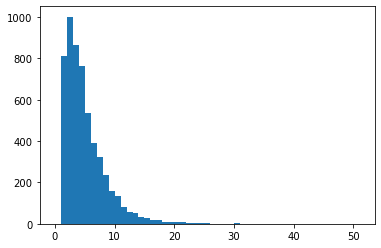

In [292]:
clusters = clustering.get_clusters_from_last_fathers(0.8)

clusters_size = []
for cluster in clusters:
    clusters_size.append(len(cluster))

plt.hist(clusters_size, bins=np.array(range(clusters_size[0]+2)))
plt.show()

In [ ]:
clusters_weighted_mean = compute_clusters_mean(df, shp, clusters, weighted=True)

In [ ]:
avg_corr_with_mean = correlations_sub_cluster(df_finer, clusters, clusters_weighted_mean)
no_singletons = remove_singletons(clusters)
print(f'No. clusters (w/o singletons): {len(no_singletons)}')
print(f'No. singletons): {len(avg_corr_with_mean) - len(no_singletons)}')
plot_hist_with_mean(avg_corr_with_mean, title="Clusters With Singletons")
plot_hist_with_mean(avg_corr_with_mean[:len(no_singletons)], title="Clusters Without Singletons")